# Mask RCNN - K-Fashion Segmentation

In [43]:
import os
import sys
import glob
import json
import cv2
import numpy as np
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import visualize
from mrcnn import model as modellib, utils
from mrcnn.model import log

# Path to trained weights file
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

IMAGE_SIZE = 800

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_DATASET_YEAR = "2020"

# Configurations

In [44]:
class FashionConfig(Config):
    # Give the configuration a recognizable name
    NAME = "fashion"
    
    IMAGES_PER_GPU = 2
    
    NUM_CLASSES = 1 + 21 #
    
    STEPS_PER_EPOCH = 100
    
    DETECTION_MIN_CONFIDENCE = 0.9

config=FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                34
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Notebook Preferences

In [45]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Dataset

In [46]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [93]:
!pip install tqdm
from tqdm import trange,notebook

class FashionDataset(utils.Dataset):
    def load_fashion(self, dataset_dir, subset):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        item=["아우터","하의","원피스","상의"]
        
        class_list = ["탑", "블라우스", "티셔츠", "니트웨어", "셔츠", "브라탑", "후드티",
                      "청바지","팬츠","스커트","레깅스","조거팬츠", 
                      "코트", "재킷", "점퍼", "패딩", "베스트", "가디건", "짚업",
                      "드레스", "점프수트"]
        class_list_to_dict = {}
        class_list_to_dict_key_num={}
        
        #Add classes
        for i, name in enumerate(class_list):
            self.add_class("fashion",i+1,name)
            class_list_to_dict[name]=i+1
            class_list_to_dict_key_num[i+1]=name
        
        #Train or validation dataset
        assert subset in ["Training", "Validation"]
        dataset_dir = os.path.join(dataset_dir, subset)

        codi = ["클래식","프레피"]
#         "매니시","톰보이",
#         "페미닌","로맨틱","섹시",
#         "히피","웨스턴","오리엔탈",
#         "모던","소피스트케이티드","아방가르드",
#         "컨트리","리조트",
#         "젠더리스",
#         "스포티",
#         "레트로","키치","힙합","펑크",
#         "밀리터리","스트리트"]
        

        json_dir = os.path.join(dataset_dir,"라벨링데이터")
        image_dir = os.path.join(dataset_dir,"원천데이터")
        for j in codi:
            json_dir_codi = os.path.join(json_dir,j)
            image_dir_codi = os.path.join(image_dir,j)
            labeling_data_list=glob.glob(json_dir_codi+'/*.json')
            for i in notebook.tqdm(labeling_data_list):
                file_path = i
                with open(file_path,'r',encoding='UTF=8') as file:
                    
                    file_data = json.load(file)
                    height=file_data["이미지 정보"]["이미지 높이"]
                    width=file_data["이미지 정보"]["이미지 너비"]
                    image_id=file_data["이미지 정보"]["이미지 파일명"]
                    image_path=os.path.join(image_dir_codi,image_id)
                    
                    labels=[]
                    polygons=[]
                    for j in item:
                        present = file_data["데이터셋 정보"]["데이터셋 상세설명"]["라벨링"][j]
                        value=present[0].get("카테고리")
                        inClass=class_list_to_dict.get(value)
                        if present[0]:
                            if inClass:
                                labels.append(class_list_to_dict[value])                            
                                polygons.append(file_data["데이터셋 정보"]["데이터셋 상세설명"]["폴리곤좌표"][j][0])
                            else:
                                continue
                        else:
                            continue
                    
                    self.add_image(
                        "fashion",
                        image_id=image_id,
                        path=image_path,
                        labels=labels,
                        width=width, height=height,
                        polygons=polygons
                        
                    )
        
    
    def load_mask(self, image_id):
        # polygon을 비트맵 마스크로 바꾸는 부분
        # 마스크 shape는 [height, width, instance_count]
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        labels=[]

        for i, (p, label) in enumerate(zip(info["polygons"], info["labels"])):
            # Get indexes of pixels inside the polygon and set them to 1
            x_labels=[]
            y_labels=[]
            m=np.full((info["height"],info["width"]), 0, dtype=np.uint8)
            for j in range(int(len(p)/2)):
                x_labels.append(int(p["X좌표"+str(j+1)]))
                y_labels.append(int(p["Y좌표"+str(j+1)]))
            rr, cc = skimage.draw.polygon(y_labels, x_labels)
            m[rr,cc]=1
                                       
            mask[:,:, i] = m
            labels.append(int(label))
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.array(labels)
    

    #나중에ㅔ에에에에에에에ㅔ
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        return info['path'],info["labels"] ,info["polygons"]

In [94]:
DATASET_DIR = "/Users/Yeonhwa/Desktop/K-Fashion 이미지"

#Training dataset.
dataset_train = FashionDataset()
dataset_train.load_fashion(DATASET_DIR, "Training")
dataset_train.prepare()

# Validation dataset
dataset_val = FashionDataset()
dataset_val.load_fashion(DATASET_DIR, "Validation")
dataset_val.prepare()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2429 [00:00<?, ?it/s]

  0%|          | 0/4821 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

('/Users/Yeonhwa/Desktop/K-Fashion 이미지\\Training\\원천데이터\\프레피\\cocobenny_057_04.jpg', [14], [{'X좌표31': 319.703, 'X좌표30': 453.703, 'X좌표8': 172.703, 'X좌표9': 207.703, 'Y좌표31': 9.0, 'Y좌표30': 22.0, 'X좌표2': 276.703, 'X좌표3': 247.703, 'X좌표1': 314.703, 'X좌표6': 173.703, 'X좌표7': 171.703, 'X좌표4': 219.703, 'X좌표5': 189.703, 'Y좌표26': 286.0, 'Y좌표25': 414.0, 'Y좌표28': 68.0, 'Y좌표9': 382.0, 'Y좌표27': 162.0, 'Y좌표22': 546.0, 'Y좌표21': 606.0, 'Y좌표24': 467.0, 'Y좌표23': 538.0, 'Y좌표20': 663.0, 'X좌표19': 561.703, 'X좌표18': 519.703, 'X좌표17': 493.703, 'X좌표16': 482.703, 'X좌표15': 479.703, 'X좌표14': 306.703, 'X좌표13': 239.703, 'X좌표12': 196.703, 'X좌표11': 206.703, 'Y좌표4': 61.0, 'X좌표10': 204.703, 'Y좌표3': 49.0, 'Y좌표2': 30.0, 'Y좌표1': 11.0, 'Y좌표8': 350.0, 'Y좌표7': 319.0, 'Y좌표29': 49.0, 'Y좌표6': 240.0, 'Y좌표5': 118.0, 'Y좌표15': 746.0, 'Y좌표14': 729.0, 'Y좌표17': 578.0, 'Y좌표16': 672.0, 'Y좌표11': 603.0, 'Y좌표10': 483.0, 'Y좌표13': 708.0, 'Y좌표12': 692.0, 'X좌표29': 475.703, 'X좌표28': 513.703, 'X좌표27': 546.703, 'X좌표26': 566.703, 'X좌표25': 598.703, 'X

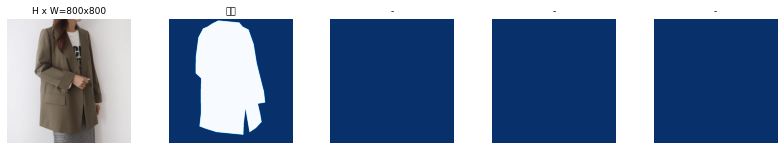

('/Users/Yeonhwa/Desktop/K-Fashion 이미지\\Training\\원천데이터\\프레피\\jk2254k04-jk2254k04-s_9.jpg', [10, 3], [{'Y좌표9': 938.438, 'X좌표19': 226.0, 'X좌표18': 246.0, 'X좌표17': 280.0, 'X좌표16': 333.0, 'X좌표15': 436.0, 'X좌표14': 524.0, 'X좌표13': 546.0, 'X좌표12': 601.0, 'X좌표11': 653.0, 'Y좌표4': 896.478, 'X좌표10': 658.0, 'Y좌표3': 794.575, 'Y좌표2': 588.772, 'Y좌표1': 444.909, 'Y좌표8': 951.425, 'Y좌표7': 959.418, 'Y좌표6': 958.419, 'Y좌표5': 952.425, 'Y좌표15': 442.911, 'Y좌표14': 440.913, 'X좌표8': 488.0, 'Y좌표17': 431.921, 'X좌표9': 581.0, 'Y좌표16': 436.916, 'Y좌표11': 864.508, 'Y좌표10': 915.46, 'Y좌표13': 464.89, 'Y좌표12': 696.669, 'X좌표2': 190.0, 'X좌표3': 160.0, 'X좌표1': 232.0, 'X좌표6': 298.0, 'Y좌표19': 439.914, 'X좌표7': 398.0, 'Y좌표18': 431.921, 'X좌표4': 164.0, 'X좌표5': 232.0}, {'X좌표8': 236.0, 'X좌표9': 246.0, 'X좌표2': 185.0, 'X좌표3': 166.0, 'X좌표1': 298.0, 'X좌표6': 129.0, 'X좌표7': 194.0, 'X좌표4': 124.0, 'X좌표5': 102.0, 'Y좌표26': 46.9552, 'Y좌표25': 65.9371, 'Y좌표9': 469.552, 'Y좌표22': 97.9066, 'Y좌표21': 59.9428, 'Y좌표24': 89.9142, 'Y좌표23': 102.902, 'Y좌표20': 

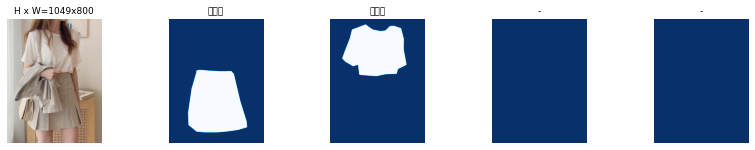

('/Users/Yeonhwa/Desktop/K-Fashion 이미지\\Training\\원천데이터\\프레피\\20191029(중국,샘플)-sk2490k9al(2)-바비제이(샘플,모모sk)1029얼굴컷-밝기보정해주세요-IMG_7578.jpg', [14, 10], [{'X좌표8': 378.0, 'X좌표9': 402.0, 'X좌표2': 393.0, 'X좌표3': 383.0, 'X좌표1': 423.0, 'X좌표6': 367.0, 'X좌표7': 368.0, 'X좌표4': 374.0, 'X좌표5': 368.0, 'Y좌표26': 548.657, 'Y좌표25': 558.65, 'Y좌표9': 696.564, 'Y좌표22': 550.655, 'Y좌표21': 549.656, 'Y좌표24': 564.647, 'Y좌표23': 549.656, 'Y좌표20': 568.644, 'X좌표19': 530.0, 'X좌표18': 534.0, 'X좌표17': 538.0, 'X좌표16': 529.0, 'X좌표15': 514.0, 'X좌표14': 515.0, 'X좌표13': 507.0, 'X좌표12': 490.0, 'X좌표11': 463.0, 'Y좌표4': 607.62, 'X좌표10': 422.0, 'Y좌표3': 580.637, 'Y좌표2': 554.653, 'Y좌표1': 549.656, 'Y좌표8': 689.568, 'Y좌표7': 673.578, 'Y좌표6': 646.595, 'Y좌표5': 633.604, 'Y좌표15': 680.574, 'Y좌표14': 689.568, 'Y좌표17': 656.589, 'Y좌표16': 676.577, 'Y좌표11': 703.56, 'Y좌표10': 700.562, 'Y좌표13': 701.561, 'Y좌표12': 702.56, 'X좌표26': 427.0, 'X좌표25': 442.0, 'X좌표24': 458.0, 'X좌표23': 472.0, 'X좌표22': 487.0, 'X좌표21': 510.0, 'X좌표20': 519.0, 'Y좌표19': 615.615, 'Y좌표18'

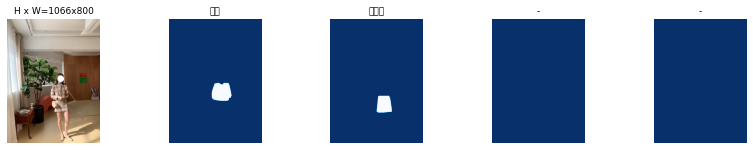

('/Users/Yeonhwa/Desktop/K-Fashion 이미지\\Training\\원천데이터\\프레피\\sk3022k09-sk3022k09-s_2.jpg', [10, 4], [{'Y좌표9': 876.142, 'X좌표19': 259.646, 'X좌표18': 247.662, 'X좌표17': 223.696, 'X좌표16': 215.707, 'X좌표15': 205.721, 'X좌표14': 259.646, 'X좌표13': 299.59, 'X좌표12': 389.465, 'X좌표11': 496.317, 'Y좌표4': 620.168, 'X좌표10': 586.192, 'Y좌표3': 640.166, 'Y좌표2': 628.167, 'Y좌표1': 591.17, 'Y좌표8': 826.147, 'Y좌표7': 781.152, 'Y좌표6': 700.16, 'Y좌표5': 598.17, 'Y좌표15': 911.139, 'Y좌표14': 956.134, 'X좌표8': 620.144, 'Y좌표17': 752.154, 'X좌표9': 613.154, 'Y좌표16': 813.148, 'Y좌표11': 925.137, 'Y좌표10': 905.139, 'Y좌표13': 959.134, 'Y좌표12': 945.135, 'X좌표2': 330.547, 'X좌표3': 427.412, 'X좌표1': 263.64, 'X좌표6': 610.158, 'Y좌표19': 589.171, 'X좌표7': 607.162, 'Y좌표18': 660.164, 'X좌표4': 546.247, 'X좌표5': 597.176}, {'Y좌표44': 170.99, 'Y좌표43': 273.202, 'Y좌표45': 128.994, 'Y좌표40': 439.186, 'Y좌표42': 356.194, 'Y좌표41': 383.191, 'X좌표39': 153.793, 'X좌표38': 200.728, 'X좌표37': 255.651, 'X좌표36': 253.654, 'X좌표35': 305.582, 'X좌표34': 371.49, 'X좌표33': 448.383, 'X

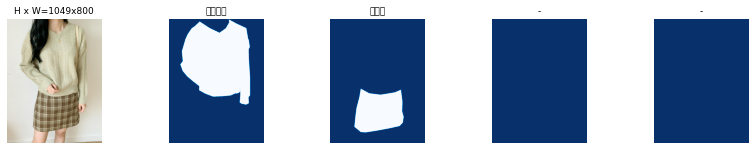

In [95]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(dataset_train.image_reference(image_id))
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [96]:
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=MODEL_DIR)

Instructions for updating:
box_ind is deprecated, use box_indices instead


In [97]:
model.train(dataset_train, dataset_val,
        learning_rate=config.LEARNING_RATE,
        epochs=30, layers="3+")


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\Yeonhwa\Desktop\Mask_RCNN\logs\fashion20210829T0902\mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNorm)
res3a_branch2c         (Conv2D)
res3a_branch1          (Conv2D)
bn3a_branch2c          (BatchNorm)
bn3a_branch1           (BatchNorm)
res3b_branch2a         (Conv2D)
bn3b_branch2a          (BatchNorm)
res3b_branch2b         (Conv2D)
bn3b_branch2b          (BatchNorm)
res3b_branch2c         (Conv2D)
bn3b_branch2c          (BatchNorm)
res3c_branch2a         (Conv2D)
bn3c_branch2a          (BatchNorm)
res3c_branch2b         (Conv2D)
bn3c_branch2b          (BatchNorm)
res3c_branch2c         (Conv2D)
bn3c_branch2c          (BatchNorm)
res3d_branch2a         (Conv2D)
bn3d_branch2a          (BatchNorm)
res3d_branch2b         (Conv2D)
bn3d_branch2b          (BatchNorm)
res3d_branch2c         (Con

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnin

  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 78.1896

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 22:29 - batch: 0.5000 - size: 2.0000 - loss: 52.0973 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 30:05 - batch: 1.0000 - size: 2.0000 - loss: 36.9111

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 32:48 - batch: 1.5000 - size: 2.0000 - loss: 32.0983

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 34:00 - batch: 2.0000 - size: 2.0000 - loss: 28.1144

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 34:44 - batch: 2.5000 - size: 2.0000 - loss: 24.7387

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 35:09 - batch: 3.0000 - size: 2.0000 - loss: 22.9064

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 35:25 - batch: 3.5000 - size: 2.0000 - loss: 20.7603

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 35:40 - batch: 4.0000 - size: 2.0000 - loss: 19.4867

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 35:36 - batch: 4.5000 - size: 2.0000 - loss: 18.1857

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 35:29 - batch: 5.0000 - size: 2.0000 - loss: 17.1901

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 35:20 - batch: 5.5000 - size: 2.0000 - loss: 16.1323

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 35:04 - batch: 6.0000 - size: 2.0000 - loss: 15.3086

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 34:53 - batch: 6.5000 - size: 2.0000 - loss: 14.6142

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 34:39 - batch: 7.0000 - size: 2.0000 - loss: 13.9111

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 34:23 - batch: 7.5000 - size: 2.0000 - loss: 13.3043

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 34:05 - batch: 8.0000 - size: 2.0000 - loss: 12.6883

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 33:48 - batch: 8.5000 - size: 2.0000 - loss: 12.1741

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 33:28 - batch: 9.0000 - size: 2.0000 - loss: 11.8473

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 33:07 - batch: 9.5000 - size: 2.0000 - loss: 11.4700

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 32:45 - batch: 10.0000 - size: 2.0000 - loss: 11.0926

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 32:24 - batch: 10.5000 - size: 2.0000 - loss: 10.7125

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 32:03 - batch: 11.0000 - size: 2.0000 - loss: 10.4114

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 31:43 - batch: 11.5000 - size: 2.0000 - loss: 10.1015

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 31:21 - batch: 12.0000 - size: 2.0000 - loss: 9.8311 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 31:00 - batch: 12.5000 - size: 2.0000 - loss: 9.5692

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 30:37 - batch: 13.0000 - size: 2.0000 - loss: 9.2876

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 30:15 - batch: 13.5000 - size: 2.0000 - loss: 9.0506

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 29:51 - batch: 14.0000 - size: 2.0000 - loss: 8.8530

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 29:29 - batch: 14.5000 - size: 2.0000 - loss: 8.6677

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 29:05 - batch: 15.0000 - size: 2.0000 - loss: 8.4564

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 28:41 - batch: 15.5000 - size: 2.0000 - loss: 8.2984

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 28:17 - batch: 16.0000 - size: 2.0000 - loss: 8.1122

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 27:53 - batch: 16.5000 - size: 2.0000 - loss: 7.9734

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 27:29 - batch: 17.0000 - size: 2.0000 - loss: 7.8232

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 27:06 - batch: 17.5000 - size: 2.0000 - loss: 7.6806

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 26:42 - batch: 18.0000 - size: 2.0000 - loss: 7.5356

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 26:18 - batch: 18.5000 - size: 2.0000 - loss: 7.3952

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 25:53 - batch: 19.0000 - size: 2.0000 - loss: 7.2644

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 25:29 - batch: 19.5000 - size: 2.0000 - loss: 7.1557

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 25:04 - batch: 20.0000 - size: 2.0000 - loss: 7.0342

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 24:40 - batch: 20.5000 - size: 2.0000 - loss: 6.9172

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 24:15 - batch: 21.0000 - size: 2.0000 - loss: 6.8181

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 23:50 - batch: 21.5000 - size: 2.0000 - loss: 6.7177

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 23:25 - batch: 22.0000 - size: 2.0000 - loss: 6.6290

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 23:00 - batch: 22.5000 - size: 2.0000 - loss: 6.5402

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 22:35 - batch: 23.0000 - size: 2.0000 - loss: 6.4477

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 22:10 - batch: 23.5000 - size: 2.0000 - loss: 6.3521

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 21:44 - batch: 24.0000 - size: 2.0000 - loss: 6.2681

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 21:19 - batch: 24.5000 - size: 2.0000 - loss: 6.1877

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 20:54 - batch: 25.0000 - size: 2.0000 - loss: 6.1126

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 20:30 - batch: 25.5000 - size: 2.0000 - loss: 6.0545

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 20:04 - batch: 26.0000 - size: 2.0000 - loss: 5.9795

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 19:39 - batch: 26.5000 - size: 2.0000 - loss: 5.9173

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 19:13 - batch: 27.0000 - size: 2.0000 - loss: 5.8590

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

 56/100 [===============>..............] - ETA: 18:47 - batch: 27.5000 - size: 2.0000 - loss: 5.7902

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 18:22 - batch: 28.0000 - size: 2.0000 - loss: 5.7268

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 17:56 - batch: 28.5000 - size: 2.0000 - loss: 5.6641

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 17:31 - batch: 29.0000 - size: 2.0000 - loss: 5.6092

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 17:05 - batch: 29.5000 - size: 2.0000 - loss: 5.5552

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 16:40 - batch: 30.0000 - size: 2.0000 - loss: 5.5029

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 16:14 - batch: 30.5000 - size: 2.0000 - loss: 5.4519

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 15:49 - batch: 31.0000 - size: 2.0000 - loss: 5.4058

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 15:23 - batch: 31.5000 - size: 2.0000 - loss: 5.3561

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:58 - batch: 32.0000 - size: 2.0000 - loss: 5.3143

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 14:32 - batch: 32.5000 - size: 2.0000 - loss: 5.2746

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 14:07 - batch: 33.0000 - size: 2.0000 - loss: 5.2323

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 13:41 - batch: 33.5000 - size: 2.0000 - loss: 5.1968

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 13:16 - batch: 34.0000 - size: 2.0000 - loss: 5.1550

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:50 - batch: 34.5000 - size: 2.0000 - loss: 5.1137

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 12:24 - batch: 35.0000 - size: 2.0000 - loss: 5.0717

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:59 - batch: 35.5000 - size: 2.0000 - loss: 5.0360

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 11:33 - batch: 36.0000 - size: 2.0000 - loss: 4.9975

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 11:08 - batch: 36.5000 - size: 2.0000 - loss: 4.9594

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:42 - batch: 37.0000 - size: 2.0000 - loss: 4.9245

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 10:16 - batch: 37.5000 - size: 2.0000 - loss: 4.8941

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:50 - batch: 38.0000 - size: 2.0000 - loss: 4.8611 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 9:24 - batch: 38.5000 - size: 2.0000 - loss: 4.8257

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:59 - batch: 39.0000 - size: 2.0000 - loss: 4.8020

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:33 - batch: 39.5000 - size: 2.0000 - loss: 4.7732

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 8:07 - batch: 40.0000 - size: 2.0000 - loss: 4.7394

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:41 - batch: 40.5000 - size: 2.0000 - loss: 4.7052

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 7:15 - batch: 41.0000 - size: 2.0000 - loss: 4.6763

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:50 - batch: 41.5000 - size: 2.0000 - loss: 4.6455

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:24 - batch: 42.0000 - size: 2.0000 - loss: 4.6263

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:58 - batch: 42.5000 - size: 2.0000 - loss: 4.6108

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:32 - batch: 43.0000 - size: 2.0000 - loss: 4.5885

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 5:07 - batch: 43.5000 - size: 2.0000 - loss: 4.5639

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:41 - batch: 44.0000 - size: 2.0000 - loss: 4.5368

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:15 - batch: 44.5000 - size: 2.0000 - loss: 4.5157

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:50 - batch: 45.0000 - size: 2.0000 - loss: 4.4877

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:24 - batch: 45.5000 - size: 2.0000 - loss: 4.4674

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:59 - batch: 46.0000 - size: 2.0000 - loss: 4.4380

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:33 - batch: 46.5000 - size: 2.0000 - loss: 4.4100

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:07 - batch: 47.0000 - size: 2.0000 - loss: 4.3863

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:42 - batch: 47.5000 - size: 2.0000 - loss: 4.3677

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:16 - batch: 48.0000 - size: 2.0000 - loss: 4.3512

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 51s - batch: 48.5000 - size: 2.0000 - loss: 4.3320 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 25s - batch: 49.0000 - size: 2.0000 - loss: 4.3116

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 4.2898 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2819s 28s/step - batch: 49.5000 - size: 2.0000 - loss: 4.2898 - val_loss: 2.5181
Epoch 2/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 2.5523

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:26 - batch: 0.5000 - size: 2.0000 - loss: 2.5278 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 27:09 - batch: 1.0000 - size: 2.0000 - loss: 2.5151

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 30:04 - batch: 1.5000 - size: 2.0000 - loss: 2.4534

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:42 - batch: 2.0000 - size: 2.0000 - loss: 2.4798

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:43 - batch: 2.5000 - size: 2.0000 - loss: 2.2566

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 33:17 - batch: 3.0000 - size: 2.0000 - loss: 2.2858

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:34 - batch: 3.5000 - size: 2.0000 - loss: 2.3488

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:45 - batch: 4.0000 - size: 2.0000 - loss: 2.3784

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:43 - batch: 4.5000 - size: 2.0000 - loss: 2.3381

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:38 - batch: 5.0000 - size: 2.0000 - loss: 2.2996

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:32 - batch: 5.5000 - size: 2.0000 - loss: 2.2887

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:20 - batch: 6.0000 - size: 2.0000 - loss: 2.2808

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 33:08 - batch: 6.5000 - size: 2.0000 - loss: 2.2767

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:54 - batch: 7.0000 - size: 2.0000 - loss: 2.2552

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:39 - batch: 7.5000 - size: 2.0000 - loss: 2.2363

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:23 - batch: 8.0000 - size: 2.0000 - loss: 2.2017

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 32:06 - batch: 8.5000 - size: 2.0000 - loss: 2.1770

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:48 - batch: 9.0000 - size: 2.0000 - loss: 2.1831

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:31 - batch: 9.5000 - size: 2.0000 - loss: 2.1763

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 31:12 - batch: 10.0000 - size: 2.0000 - loss: 2.1773

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:51 - batch: 10.5000 - size: 2.0000 - loss: 2.1547

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:31 - batch: 11.0000 - size: 2.0000 - loss: 2.1713

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:11 - batch: 11.5000 - size: 2.0000 - loss: 2.1552

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:50 - batch: 12.0000 - size: 2.0000 - loss: 2.1566

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:29 - batch: 12.5000 - size: 2.0000 - loss: 2.1617

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 29:08 - batch: 13.0000 - size: 2.0000 - loss: 2.1588

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:46 - batch: 13.5000 - size: 2.0000 - loss: 2.1572

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:24 - batch: 14.0000 - size: 2.0000 - loss: 2.1577

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 28:02 - batch: 14.5000 - size: 2.0000 - loss: 2.1595

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:40 - batch: 15.0000 - size: 2.0000 - loss: 2.1598

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:17 - batch: 15.5000 - size: 2.0000 - loss: 2.1539

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:55 - batch: 16.0000 - size: 2.0000 - loss: 2.1490

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:33 - batch: 16.5000 - size: 2.0000 - loss: 2.1546

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 26:10 - batch: 17.0000 - size: 2.0000 - loss: 2.1576

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:47 - batch: 17.5000 - size: 2.0000 - loss: 2.1667

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:24 - batch: 18.0000 - size: 2.0000 - loss: 2.1608

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 25:00 - batch: 18.5000 - size: 2.0000 - loss: 2.1557

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:37 - batch: 19.0000 - size: 2.0000 - loss: 2.1437

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:14 - batch: 19.5000 - size: 2.0000 - loss: 2.1398

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:50 - batch: 20.0000 - size: 2.0000 - loss: 2.1332

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:27 - batch: 20.5000 - size: 2.0000 - loss: 2.1503

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 23:04 - batch: 21.0000 - size: 2.0000 - loss: 2.1513

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:41 - batch: 21.5000 - size: 2.0000 - loss: 2.1507

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:17 - batch: 22.0000 - size: 2.0000 - loss: 2.1553

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:53 - batch: 22.5000 - size: 2.0000 - loss: 2.1446

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:29 - batch: 23.0000 - size: 2.0000 - loss: 2.1411

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 21:06 - batch: 23.5000 - size: 2.0000 - loss: 2.1361

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:42 - batch: 24.0000 - size: 2.0000 - loss: 2.1410

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:18 - batch: 24.5000 - size: 2.0000 - loss: 2.1404

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:54 - batch: 25.0000 - size: 2.0000 - loss: 2.1397

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:30 - batch: 25.5000 - size: 2.0000 - loss: 2.1389

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 19:06 - batch: 26.0000 - size: 2.0000 - loss: 2.1330

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:42 - batch: 26.5000 - size: 2.0000 - loss: 2.1399

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:18 - batch: 27.0000 - size: 2.0000 - loss: 2.1395

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:54 - batch: 27.5000 - size: 2.0000 - loss: 2.1809

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:30 - batch: 28.0000 - size: 2.0000 - loss: 2.1831

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 17:06 - batch: 28.5000 - size: 2.0000 - loss: 2.1838

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:41 - batch: 29.0000 - size: 2.0000 - loss: 2.1824

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:17 - batch: 29.5000 - size: 2.0000 - loss: 2.2035

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:53 - batch: 30.0000 - size: 2.0000 - loss: 2.2052

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
ERROR:root:Error processing image {'id': 'banhana_219_02.jpg', 'source': 'fashion', 'path': '/Users/Yeonhwa/Desktop/K-Fashion 이미지\\Training\\원천데이터\\프레피\\banhana_219_02.jpg', 'labels': [20], 'width': 800, 'height': 800, 'polygons': [{'X좌표8': 216.0, 'X좌표9': 225.778, 'X좌표2': 189.333, 'X좌표3': 204.444, 'X좌표1': 229.333, 'X좌표6': 251.556, 'X좌표7': 234.667, 'X좌표4': 212.444, 'X좌표5': 266.667, 'Y좌표26': 102.222, 'Y좌표25': 111.111, 'Y좌표9': 770.667, 'Y좌표22': 56.0, 'Y좌표21': 107.556, 'Y좌표24': 101.333, 'Y좌표23': 50.6667, 'Y좌표20': 201.778, 'X좌표19': 598.222, 'X좌표18': 512.889, 'X좌표17': 527.111, 'X좌표16': 540.445, 'X좌표15': 507.556, 

 62/100 [=================>............] - ETA: 15:29 - batch: 30.5000 - size: 2.0000 - loss: 2.2111

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 15:05 - batch: 31.0000 - size: 2.0000 - loss: 2.2088

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:41 - batch: 31.5000 - size: 2.0000 - loss: 2.2030

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:16 - batch: 32.0000 - size: 2.0000 - loss: 2.2046

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:52 - batch: 32.5000 - size: 2.0000 - loss: 2.2086

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:27 - batch: 33.0000 - size: 2.0000 - loss: 2.2112

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 13:03 - batch: 33.5000 - size: 2.0000 - loss: 2.2117

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:39 - batch: 34.0000 - size: 2.0000 - loss: 2.2124

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:14 - batch: 34.5000 - size: 2.0000 - loss: 2.2103

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:50 - batch: 35.0000 - size: 2.0000 - loss: 2.2109

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:25 - batch: 35.5000 - size: 2.0000 - loss: 2.2042

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 11:01 - batch: 36.0000 - size: 2.0000 - loss: 2.2005

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:37 - batch: 36.5000 - size: 2.0000 - loss: 2.2033

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:12 - batch: 37.0000 - size: 2.0000 - loss: 2.2021

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:48 - batch: 37.5000 - size: 2.0000 - loss: 2.1987 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:23 - batch: 38.0000 - size: 2.0000 - loss: 2.1935

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:59 - batch: 38.5000 - size: 2.0000 - loss: 2.1901

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:34 - batch: 39.0000 - size: 2.0000 - loss: 2.1861

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:10 - batch: 39.5000 - size: 2.0000 - loss: 2.1894

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:45 - batch: 40.0000 - size: 2.0000 - loss: 2.1895

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:21 - batch: 40.5000 - size: 2.0000 - loss: 2.1900

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:56 - batch: 41.0000 - size: 2.0000 - loss: 2.2009

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:32 - batch: 41.5000 - size: 2.0000 - loss: 2.1982

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:07 - batch: 42.0000 - size: 2.0000 - loss: 2.1991

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:43 - batch: 42.5000 - size: 2.0000 - loss: 2.1986

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:18 - batch: 43.0000 - size: 2.0000 - loss: 2.2008

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:54 - batch: 43.5000 - size: 2.0000 - loss: 2.2051

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:29 - batch: 44.0000 - size: 2.0000 - loss: 2.2082

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:05 - batch: 44.5000 - size: 2.0000 - loss: 2.2075

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:40 - batch: 45.0000 - size: 2.0000 - loss: 2.2060

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:16 - batch: 45.5000 - size: 2.0000 - loss: 2.2003

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:51 - batch: 46.0000 - size: 2.0000 - loss: 2.1968

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:27 - batch: 46.5000 - size: 2.0000 - loss: 2.1968

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 2.1962

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:38 - batch: 47.5000 - size: 2.0000 - loss: 2.1994

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 2.1980

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 49s - batch: 48.5000 - size: 2.0000 - loss: 2.2016 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 2.1995

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 2.1925 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2687s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 2.1925 - val_loss: 2.1201
Epoch 3/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 2.3532

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:11 - batch: 0.5000 - size: 2.0000 - loss: 2.3813 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:45 - batch: 1.0000 - size: 2.0000 - loss: 2.2321

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:47 - batch: 1.5000 - size: 2.0000 - loss: 2.1501

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:26 - batch: 2.0000 - size: 2.0000 - loss: 2.0984

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:22 - batch: 2.5000 - size: 2.0000 - loss: 2.0598

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 33:07 - batch: 3.0000 - size: 2.0000 - loss: 2.1629

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:25 - batch: 3.5000 - size: 2.0000 - loss: 2.0807

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:33 - batch: 4.0000 - size: 2.0000 - loss: 2.0937

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:34 - batch: 4.5000 - size: 2.0000 - loss: 2.0884

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:32 - batch: 5.0000 - size: 2.0000 - loss: 2.1194

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:27 - batch: 5.5000 - size: 2.0000 - loss: 2.1338

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:18 - batch: 6.0000 - size: 2.0000 - loss: 2.1026

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 33:06 - batch: 6.5000 - size: 2.0000 - loss: 2.0903

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:53 - batch: 7.0000 - size: 2.0000 - loss: 2.0958

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:39 - batch: 7.5000 - size: 2.0000 - loss: 2.1324

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:23 - batch: 8.0000 - size: 2.0000 - loss: 2.1112

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 32:06 - batch: 8.5000 - size: 2.0000 - loss: 2.1293

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:47 - batch: 9.0000 - size: 2.0000 - loss: 2.1341

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:28 - batch: 9.5000 - size: 2.0000 - loss: 2.1384

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 31:08 - batch: 10.0000 - size: 2.0000 - loss: 2.1470

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:48 - batch: 10.5000 - size: 2.0000 - loss: 2.1307

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:28 - batch: 11.0000 - size: 2.0000 - loss: 2.1328

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:07 - batch: 11.5000 - size: 2.0000 - loss: 2.1571

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:46 - batch: 12.0000 - size: 2.0000 - loss: 2.1587

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:25 - batch: 12.5000 - size: 2.0000 - loss: 2.1619

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 29:05 - batch: 13.0000 - size: 2.0000 - loss: 2.1670

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:43 - batch: 13.5000 - size: 2.0000 - loss: 2.1819

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:21 - batch: 14.0000 - size: 2.0000 - loss: 2.1686

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 28:00 - batch: 14.5000 - size: 2.0000 - loss: 2.1689

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:38 - batch: 15.0000 - size: 2.0000 - loss: 2.1883

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:16 - batch: 15.5000 - size: 2.0000 - loss: 2.1893

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:53 - batch: 16.0000 - size: 2.0000 - loss: 2.1841

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:31 - batch: 16.5000 - size: 2.0000 - loss: 2.1908

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 26:09 - batch: 17.0000 - size: 2.0000 - loss: 2.1956

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:46 - batch: 17.5000 - size: 2.0000 - loss: 2.1813

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:23 - batch: 18.0000 - size: 2.0000 - loss: 2.1824

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 25:00 - batch: 18.5000 - size: 2.0000 - loss: 2.1778

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:37 - batch: 19.0000 - size: 2.0000 - loss: 2.1776

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:13 - batch: 19.5000 - size: 2.0000 - loss: 2.1689

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:49 - batch: 20.0000 - size: 2.0000 - loss: 2.1664

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:26 - batch: 20.5000 - size: 2.0000 - loss: 2.1571

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 23:02 - batch: 21.0000 - size: 2.0000 - loss: 2.1483

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:39 - batch: 21.5000 - size: 2.0000 - loss: 2.1440

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:15 - batch: 22.0000 - size: 2.0000 - loss: 2.1444

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:52 - batch: 22.5000 - size: 2.0000 - loss: 2.1418

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:28 - batch: 23.0000 - size: 2.0000 - loss: 2.1444

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 21:04 - batch: 23.5000 - size: 2.0000 - loss: 2.1367

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:40 - batch: 24.0000 - size: 2.0000 - loss: 2.1353

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:16 - batch: 24.5000 - size: 2.0000 - loss: 2.1310

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:52 - batch: 25.0000 - size: 2.0000 - loss: 2.1220

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:28 - batch: 25.5000 - size: 2.0000 - loss: 2.1219

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 19:04 - batch: 26.0000 - size: 2.0000 - loss: 2.1184

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:40 - batch: 26.5000 - size: 2.0000 - loss: 2.1116

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:16 - batch: 27.0000 - size: 2.0000 - loss: 2.1127

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:52 - batch: 27.5000 - size: 2.0000 - loss: 2.1060

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:28 - batch: 28.0000 - size: 2.0000 - loss: 2.1124

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 17:04 - batch: 28.5000 - size: 2.0000 - loss: 2.1117

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:40 - batch: 29.0000 - size: 2.0000 - loss: 2.1225

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:16 - batch: 29.5000 - size: 2.0000 - loss: 2.1210

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:52 - batch: 30.0000 - size: 2.0000 - loss: 2.1289

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:28 - batch: 30.5000 - size: 2.0000 - loss: 2.1257

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 15:05 - batch: 31.0000 - size: 2.0000 - loss: 2.1296

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:41 - batch: 31.5000 - size: 2.0000 - loss: 2.1328

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:17 - batch: 32.0000 - size: 2.0000 - loss: 2.1335

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:52 - batch: 32.5000 - size: 2.0000 - loss: 2.1321

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:28 - batch: 33.0000 - size: 2.0000 - loss: 2.1359

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 13:03 - batch: 33.5000 - size: 2.0000 - loss: 2.1393

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:39 - batch: 34.0000 - size: 2.0000 - loss: 2.1650

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:15 - batch: 34.5000 - size: 2.0000 - loss: 2.1701

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:50 - batch: 35.0000 - size: 2.0000 - loss: 2.1936

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:26 - batch: 35.5000 - size: 2.0000 - loss: 2.1956

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 11:01 - batch: 36.0000 - size: 2.0000 - loss: 2.1933

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:37 - batch: 36.5000 - size: 2.0000 - loss: 2.2004

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:13 - batch: 37.0000 - size: 2.0000 - loss: 2.2029

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:48 - batch: 37.5000 - size: 2.0000 - loss: 2.2017 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:24 - batch: 38.0000 - size: 2.0000 - loss: 2.2038

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:59 - batch: 38.5000 - size: 2.0000 - loss: 2.2046

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:35 - batch: 39.0000 - size: 2.0000 - loss: 2.2125

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:10 - batch: 39.5000 - size: 2.0000 - loss: 2.2141

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:46 - batch: 40.0000 - size: 2.0000 - loss: 2.2162

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:22 - batch: 40.5000 - size: 2.0000 - loss: 2.2195

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:57 - batch: 41.0000 - size: 2.0000 - loss: 2.2185

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:33 - batch: 41.5000 - size: 2.0000 - loss: 2.2186

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:08 - batch: 42.0000 - size: 2.0000 - loss: 2.2222

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:44 - batch: 42.5000 - size: 2.0000 - loss: 2.2207

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:19 - batch: 43.0000 - size: 2.0000 - loss: 2.2229

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:54 - batch: 43.5000 - size: 2.0000 - loss: 2.2193

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:30 - batch: 44.0000 - size: 2.0000 - loss: 2.2159

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:05 - batch: 44.5000 - size: 2.0000 - loss: 2.2183

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:41 - batch: 45.0000 - size: 2.0000 - loss: 2.2153

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:16 - batch: 45.5000 - size: 2.0000 - loss: 2.2188

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:52 - batch: 46.0000 - size: 2.0000 - loss: 2.2182

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:27 - batch: 46.5000 - size: 2.0000 - loss: 2.2174

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:03 - batch: 47.0000 - size: 2.0000 - loss: 2.2221

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:38 - batch: 47.5000 - size: 2.0000 - loss: 2.2326

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 2.2290

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 49s - batch: 48.5000 - size: 2.0000 - loss: 2.2261 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 2.2254

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 2.2209 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2698s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 2.2209 - val_loss: 2.1330
Epoch 4/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.9287

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:07 - batch: 0.5000 - size: 2.0000 - loss: 1.9039 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:50 - batch: 1.0000 - size: 2.0000 - loss: 1.9453

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:46 - batch: 1.5000 - size: 2.0000 - loss: 2.0684

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:26 - batch: 2.0000 - size: 2.0000 - loss: 2.1261

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:28 - batch: 2.5000 - size: 2.0000 - loss: 2.1488

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:58 - batch: 3.0000 - size: 2.0000 - loss: 2.1007

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:15 - batch: 3.5000 - size: 2.0000 - loss: 2.0971

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:23 - batch: 4.0000 - size: 2.0000 - loss: 2.1007

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:23 - batch: 4.5000 - size: 2.0000 - loss: 2.0706

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:21 - batch: 5.0000 - size: 2.0000 - loss: 2.0702

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:15 - batch: 5.5000 - size: 2.0000 - loss: 2.0356

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:05 - batch: 6.0000 - size: 2.0000 - loss: 2.0506

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 32:55 - batch: 6.5000 - size: 2.0000 - loss: 2.0394

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:41 - batch: 7.0000 - size: 2.0000 - loss: 2.0144

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:27 - batch: 7.5000 - size: 2.0000 - loss: 1.9928

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:11 - batch: 8.0000 - size: 2.0000 - loss: 1.9695

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 31:55 - batch: 8.5000 - size: 2.0000 - loss: 1.9754

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:37 - batch: 9.0000 - size: 2.0000 - loss: 1.9573

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:19 - batch: 9.5000 - size: 2.0000 - loss: 1.9751

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 31:00 - batch: 10.0000 - size: 2.0000 - loss: 1.9661

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:41 - batch: 10.5000 - size: 2.0000 - loss: 1.9636

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:20 - batch: 11.0000 - size: 2.0000 - loss: 1.9523

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:00 - batch: 11.5000 - size: 2.0000 - loss: 1.9587

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:39 - batch: 12.0000 - size: 2.0000 - loss: 1.9482

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:18 - batch: 12.5000 - size: 2.0000 - loss: 1.9477

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 28:57 - batch: 13.0000 - size: 2.0000 - loss: 1.9432

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:36 - batch: 13.5000 - size: 2.0000 - loss: 1.9451

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:13 - batch: 14.0000 - size: 2.0000 - loss: 1.9598

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 27:51 - batch: 14.5000 - size: 2.0000 - loss: 1.9816

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:28 - batch: 15.0000 - size: 2.0000 - loss: 1.9793

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:06 - batch: 15.5000 - size: 2.0000 - loss: 1.9787

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:43 - batch: 16.0000 - size: 2.0000 - loss: 1.9699

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:21 - batch: 16.5000 - size: 2.0000 - loss: 1.9805

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 25:58 - batch: 17.0000 - size: 2.0000 - loss: 1.9761

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:35 - batch: 17.5000 - size: 2.0000 - loss: 1.9768

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:12 - batch: 18.0000 - size: 2.0000 - loss: 1.9673

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:49 - batch: 18.5000 - size: 2.0000 - loss: 1.9657

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:26 - batch: 19.0000 - size: 2.0000 - loss: 1.9689

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:02 - batch: 19.5000 - size: 2.0000 - loss: 1.9713

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:39 - batch: 20.0000 - size: 2.0000 - loss: 1.9723

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:16 - batch: 20.5000 - size: 2.0000 - loss: 1.9744

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 22:53 - batch: 21.0000 - size: 2.0000 - loss: 1.9814

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:29 - batch: 21.5000 - size: 2.0000 - loss: 1.9724

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:06 - batch: 22.0000 - size: 2.0000 - loss: 1.9773

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:42 - batch: 22.5000 - size: 2.0000 - loss: 1.9716

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:19 - batch: 23.0000 - size: 2.0000 - loss: 1.9713

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 20:55 - batch: 23.5000 - size: 2.0000 - loss: 1.9700

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:31 - batch: 24.0000 - size: 2.0000 - loss: 1.9713

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:08 - batch: 24.5000 - size: 2.0000 - loss: 1.9669

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:44 - batch: 25.0000 - size: 2.0000 - loss: 1.9663

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:20 - batch: 25.5000 - size: 2.0000 - loss: 1.9609

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 18:57 - batch: 26.0000 - size: 2.0000 - loss: 1.9531

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:33 - batch: 26.5000 - size: 2.0000 - loss: 1.9525

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:09 - batch: 27.0000 - size: 2.0000 - loss: 1.9563

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:45 - batch: 27.5000 - size: 2.0000 - loss: 1.9502

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:21 - batch: 28.0000 - size: 2.0000 - loss: 1.9517

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 16:57 - batch: 28.5000 - size: 2.0000 - loss: 1.9539

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:33 - batch: 29.0000 - size: 2.0000 - loss: 1.9624

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:09 - batch: 29.5000 - size: 2.0000 - loss: 1.9728

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:45 - batch: 30.0000 - size: 2.0000 - loss: 1.9670

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:21 - batch: 30.5000 - size: 2.0000 - loss: 1.9708

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 14:56 - batch: 31.0000 - size: 2.0000 - loss: 1.9723

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:33 - batch: 31.5000 - size: 2.0000 - loss: 1.9698

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:08 - batch: 32.0000 - size: 2.0000 - loss: 1.9666

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:44 - batch: 32.5000 - size: 2.0000 - loss: 1.9671

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:20 - batch: 33.0000 - size: 2.0000 - loss: 1.9720

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 12:56 - batch: 33.5000 - size: 2.0000 - loss: 1.9662

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:32 - batch: 34.0000 - size: 2.0000 - loss: 1.9610

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:08 - batch: 34.5000 - size: 2.0000 - loss: 1.9585

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:44 - batch: 35.0000 - size: 2.0000 - loss: 1.9631

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:20 - batch: 35.5000 - size: 2.0000 - loss: 1.9629

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:55 - batch: 36.0000 - size: 2.0000 - loss: 1.9636

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:31 - batch: 36.5000 - size: 2.0000 - loss: 1.9678

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:07 - batch: 37.0000 - size: 2.0000 - loss: 1.9774

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:43 - batch: 37.5000 - size: 2.0000 - loss: 1.9785 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:19 - batch: 38.0000 - size: 2.0000 - loss: 1.9793

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:55 - batch: 38.5000 - size: 2.0000 - loss: 1.9829

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:30 - batch: 39.0000 - size: 2.0000 - loss: 1.9924

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:06 - batch: 39.5000 - size: 2.0000 - loss: 1.9928

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:42 - batch: 40.0000 - size: 2.0000 - loss: 1.9907

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:18 - batch: 40.5000 - size: 2.0000 - loss: 1.9918

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:53 - batch: 41.0000 - size: 2.0000 - loss: 1.9914

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:29 - batch: 41.5000 - size: 2.0000 - loss: 1.9876

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:05 - batch: 42.0000 - size: 2.0000 - loss: 1.9871

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:40 - batch: 42.5000 - size: 2.0000 - loss: 1.9877

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:16 - batch: 43.0000 - size: 2.0000 - loss: 1.9864

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:52 - batch: 43.5000 - size: 2.0000 - loss: 1.9856

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:28 - batch: 44.0000 - size: 2.0000 - loss: 1.9899

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:03 - batch: 44.5000 - size: 2.0000 - loss: 2.0028

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:39 - batch: 45.0000 - size: 2.0000 - loss: 2.0030

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:15 - batch: 45.5000 - size: 2.0000 - loss: 2.0014

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:50 - batch: 46.0000 - size: 2.0000 - loss: 1.9969

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:26 - batch: 46.5000 - size: 2.0000 - loss: 1.9933

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:01 - batch: 47.0000 - size: 2.0000 - loss: 1.9921

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:37 - batch: 47.5000 - size: 2.0000 - loss: 1.9927

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.9953

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 48s - batch: 48.5000 - size: 2.0000 - loss: 1.9922 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.9950

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.9968 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2668s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.9968 - val_loss: 2.0136
Epoch 5/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.6976

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:11 - batch: 0.5000 - size: 2.0000 - loss: 1.6957 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:37 - batch: 1.0000 - size: 2.0000 - loss: 1.7851

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:43 - batch: 1.5000 - size: 2.0000 - loss: 1.9063

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:25 - batch: 2.0000 - size: 2.0000 - loss: 1.9030

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:18 - batch: 2.5000 - size: 2.0000 - loss: 1.8451

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:53 - batch: 3.0000 - size: 2.0000 - loss: 1.9870

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:14 - batch: 3.5000 - size: 2.0000 - loss: 1.9497

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:22 - batch: 4.0000 - size: 2.0000 - loss: 1.9062

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:27 - batch: 4.5000 - size: 2.0000 - loss: 1.9235

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:27 - batch: 5.0000 - size: 2.0000 - loss: 1.9765

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:21 - batch: 5.5000 - size: 2.0000 - loss: 1.9439

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:13 - batch: 6.0000 - size: 2.0000 - loss: 1.9362

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 33:00 - batch: 6.5000 - size: 2.0000 - loss: 1.9298

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:48 - batch: 7.0000 - size: 2.0000 - loss: 1.9641

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:34 - batch: 7.5000 - size: 2.0000 - loss: 1.9722

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:18 - batch: 8.0000 - size: 2.0000 - loss: 1.9585

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 32:01 - batch: 8.5000 - size: 2.0000 - loss: 1.9605

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:44 - batch: 9.0000 - size: 2.0000 - loss: 1.9779

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:25 - batch: 9.5000 - size: 2.0000 - loss: 1.9587

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 31:06 - batch: 10.0000 - size: 2.0000 - loss: 1.9587

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:47 - batch: 10.5000 - size: 2.0000 - loss: 1.9653

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:26 - batch: 11.0000 - size: 2.0000 - loss: 1.9684

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:05 - batch: 11.5000 - size: 2.0000 - loss: 1.9596

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:45 - batch: 12.0000 - size: 2.0000 - loss: 1.9602

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:24 - batch: 12.5000 - size: 2.0000 - loss: 1.9712

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 29:02 - batch: 13.0000 - size: 2.0000 - loss: 1.9596

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:41 - batch: 13.5000 - size: 2.0000 - loss: 1.9641

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:19 - batch: 14.0000 - size: 2.0000 - loss: 1.9695

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 27:57 - batch: 14.5000 - size: 2.0000 - loss: 1.9761

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:34 - batch: 15.0000 - size: 2.0000 - loss: 1.9675

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:12 - batch: 15.5000 - size: 2.0000 - loss: 1.9558

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:49 - batch: 16.0000 - size: 2.0000 - loss: 1.9498

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:26 - batch: 16.5000 - size: 2.0000 - loss: 1.9701

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 26:04 - batch: 17.0000 - size: 2.0000 - loss: 1.9777

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:41 - batch: 17.5000 - size: 2.0000 - loss: 1.9690

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:19 - batch: 18.0000 - size: 2.0000 - loss: 1.9725

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:56 - batch: 18.5000 - size: 2.0000 - loss: 1.9781

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:33 - batch: 19.0000 - size: 2.0000 - loss: 1.9729

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:09 - batch: 19.5000 - size: 2.0000 - loss: 1.9720

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:46 - batch: 20.0000 - size: 2.0000 - loss: 1.9586

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:22 - batch: 20.5000 - size: 2.0000 - loss: 1.9634

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 22:59 - batch: 21.0000 - size: 2.0000 - loss: 1.9545

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:35 - batch: 21.5000 - size: 2.0000 - loss: 1.9517

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:11 - batch: 22.0000 - size: 2.0000 - loss: 1.9723

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:48 - batch: 22.5000 - size: 2.0000 - loss: 1.9619

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:24 - batch: 23.0000 - size: 2.0000 - loss: 1.9577

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 21:01 - batch: 23.5000 - size: 2.0000 - loss: 1.9626

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:37 - batch: 24.0000 - size: 2.0000 - loss: 1.9703

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:14 - batch: 24.5000 - size: 2.0000 - loss: 1.9590

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:50 - batch: 25.0000 - size: 2.0000 - loss: 1.9641

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:26 - batch: 25.5000 - size: 2.0000 - loss: 1.9652

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 19:02 - batch: 26.0000 - size: 2.0000 - loss: 1.9698

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:38 - batch: 26.5000 - size: 2.0000 - loss: 1.9789

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:14 - batch: 27.0000 - size: 2.0000 - loss: 1.9842

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:50 - batch: 27.5000 - size: 2.0000 - loss: 1.9813

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:26 - batch: 28.0000 - size: 2.0000 - loss: 1.9801

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 17:02 - batch: 28.5000 - size: 2.0000 - loss: 1.9832

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:38 - batch: 29.0000 - size: 2.0000 - loss: 1.9818

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:14 - batch: 29.5000 - size: 2.0000 - loss: 1.9766

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:50 - batch: 30.0000 - size: 2.0000 - loss: 1.9794

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:26 - batch: 30.5000 - size: 2.0000 - loss: 1.9877

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 15:02 - batch: 31.0000 - size: 2.0000 - loss: 1.9891

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:38 - batch: 31.5000 - size: 2.0000 - loss: 2.0008

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:13 - batch: 32.0000 - size: 2.0000 - loss: 1.9948

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:49 - batch: 32.5000 - size: 2.0000 - loss: 2.0160

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:25 - batch: 33.0000 - size: 2.0000 - loss: 2.0141

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 13:01 - batch: 33.5000 - size: 2.0000 - loss: 2.0096

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:36 - batch: 34.0000 - size: 2.0000 - loss: 2.0106

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:12 - batch: 34.5000 - size: 2.0000 - loss: 2.0135

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:48 - batch: 35.0000 - size: 2.0000 - loss: 2.0114

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:23 - batch: 35.5000 - size: 2.0000 - loss: 2.0106

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:59 - batch: 36.0000 - size: 2.0000 - loss: 2.0082

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:35 - batch: 36.5000 - size: 2.0000 - loss: 2.0097

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:10 - batch: 37.0000 - size: 2.0000 - loss: 2.0094

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:46 - batch: 37.5000 - size: 2.0000 - loss: 2.0075 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:22 - batch: 38.0000 - size: 2.0000 - loss: 2.0119

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:57 - batch: 38.5000 - size: 2.0000 - loss: 2.0138

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:33 - batch: 39.0000 - size: 2.0000 - loss: 2.0140

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:08 - batch: 39.5000 - size: 2.0000 - loss: 2.0118

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:44 - batch: 40.0000 - size: 2.0000 - loss: 2.0072

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:20 - batch: 40.5000 - size: 2.0000 - loss: 2.0068

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:55 - batch: 41.0000 - size: 2.0000 - loss: 2.0032

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:31 - batch: 41.5000 - size: 2.0000 - loss: 2.0041

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:06 - batch: 42.0000 - size: 2.0000 - loss: 1.9951

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:42 - batch: 42.5000 - size: 2.0000 - loss: 1.9951

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:17 - batch: 43.0000 - size: 2.0000 - loss: 1.9970

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:53 - batch: 43.5000 - size: 2.0000 - loss: 2.0003

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:29 - batch: 44.0000 - size: 2.0000 - loss: 1.9980

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:04 - batch: 44.5000 - size: 2.0000 - loss: 1.9920

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:40 - batch: 45.0000 - size: 2.0000 - loss: 1.9891

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:15 - batch: 45.5000 - size: 2.0000 - loss: 1.9905

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:51 - batch: 46.0000 - size: 2.0000 - loss: 1.9887

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:26 - batch: 46.5000 - size: 2.0000 - loss: 1.9865

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 1.9914

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:37 - batch: 47.5000 - size: 2.0000 - loss: 1.9919

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.9935

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 48s - batch: 48.5000 - size: 2.0000 - loss: 1.9911 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.9848

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.9827 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2677s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.9827 - val_loss: 2.0054
Epoch 6/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 2.0937

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:14 - batch: 0.5000 - size: 2.0000 - loss: 2.1103 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:37 - batch: 1.0000 - size: 2.0000 - loss: 2.0415

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:37 - batch: 1.5000 - size: 2.0000 - loss: 1.9493

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:10 - batch: 2.0000 - size: 2.0000 - loss: 1.8580

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:11 - batch: 2.5000 - size: 2.0000 - loss: 1.8288

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:46 - batch: 3.0000 - size: 2.0000 - loss: 1.8621

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:04 - batch: 3.5000 - size: 2.0000 - loss: 1.8677

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:14 - batch: 4.0000 - size: 2.0000 - loss: 1.8896

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:16 - batch: 4.5000 - size: 2.0000 - loss: 1.8587

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:15 - batch: 5.0000 - size: 2.0000 - loss: 1.8788

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:09 - batch: 5.5000 - size: 2.0000 - loss: 1.9021

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:00 - batch: 6.0000 - size: 2.0000 - loss: 1.8728

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 32:50 - batch: 6.5000 - size: 2.0000 - loss: 1.8663

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:36 - batch: 7.0000 - size: 2.0000 - loss: 1.8498

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:23 - batch: 7.5000 - size: 2.0000 - loss: 1.8372

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:08 - batch: 8.0000 - size: 2.0000 - loss: 1.8686

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 31:50 - batch: 8.5000 - size: 2.0000 - loss: 1.8550

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:32 - batch: 9.0000 - size: 2.0000 - loss: 1.8711

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:16 - batch: 9.5000 - size: 2.0000 - loss: 1.8550

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 30:56 - batch: 10.0000 - size: 2.0000 - loss: 1.8543

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:38 - batch: 10.5000 - size: 2.0000 - loss: 1.8379

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:18 - batch: 11.0000 - size: 2.0000 - loss: 1.8488

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 29:58 - batch: 11.5000 - size: 2.0000 - loss: 1.8734

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:39 - batch: 12.0000 - size: 2.0000 - loss: 1.8828

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:18 - batch: 12.5000 - size: 2.0000 - loss: 1.8922

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 28:57 - batch: 13.0000 - size: 2.0000 - loss: 1.8936

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:35 - batch: 13.5000 - size: 2.0000 - loss: 1.8993

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:14 - batch: 14.0000 - size: 2.0000 - loss: 1.9101

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 27:52 - batch: 14.5000 - size: 2.0000 - loss: 1.9063

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:30 - batch: 15.0000 - size: 2.0000 - loss: 1.8983

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:07 - batch: 15.5000 - size: 2.0000 - loss: 1.8952

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:45 - batch: 16.0000 - size: 2.0000 - loss: 1.8945

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:22 - batch: 16.5000 - size: 2.0000 - loss: 1.8816

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 25:59 - batch: 17.0000 - size: 2.0000 - loss: 1.8847

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:36 - batch: 17.5000 - size: 2.0000 - loss: 1.8873

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:13 - batch: 18.0000 - size: 2.0000 - loss: 1.8855

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:50 - batch: 18.5000 - size: 2.0000 - loss: 1.8954

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:28 - batch: 19.0000 - size: 2.0000 - loss: 1.9069

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:04 - batch: 19.5000 - size: 2.0000 - loss: 1.8996

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:42 - batch: 20.0000 - size: 2.0000 - loss: 1.9120

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:19 - batch: 20.5000 - size: 2.0000 - loss: 1.9124

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 22:55 - batch: 21.0000 - size: 2.0000 - loss: 1.9081

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:32 - batch: 21.5000 - size: 2.0000 - loss: 1.9141

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:08 - batch: 22.0000 - size: 2.0000 - loss: 1.9214

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:44 - batch: 22.5000 - size: 2.0000 - loss: 1.9148

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:21 - batch: 23.0000 - size: 2.0000 - loss: 1.9142

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 20:57 - batch: 23.5000 - size: 2.0000 - loss: 1.9115

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:34 - batch: 24.0000 - size: 2.0000 - loss: 1.9101

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:10 - batch: 24.5000 - size: 2.0000 - loss: 1.9201

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:46 - batch: 25.0000 - size: 2.0000 - loss: 1.9260

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:23 - batch: 25.5000 - size: 2.0000 - loss: 1.9325

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 18:59 - batch: 26.0000 - size: 2.0000 - loss: 1.9265

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:35 - batch: 26.5000 - size: 2.0000 - loss: 1.9288

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:11 - batch: 27.0000 - size: 2.0000 - loss: 1.9244

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:47 - batch: 27.5000 - size: 2.0000 - loss: 1.9114

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:23 - batch: 28.0000 - size: 2.0000 - loss: 1.9057

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 16:59 - batch: 28.5000 - size: 2.0000 - loss: 1.9056

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:35 - batch: 29.0000 - size: 2.0000 - loss: 1.9012

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:11 - batch: 29.5000 - size: 2.0000 - loss: 1.8921

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:47 - batch: 30.0000 - size: 2.0000 - loss: 1.8904

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:23 - batch: 30.5000 - size: 2.0000 - loss: 1.8906

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 14:59 - batch: 31.0000 - size: 2.0000 - loss: 1.8900

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:35 - batch: 31.5000 - size: 2.0000 - loss: 1.8854

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:10 - batch: 32.0000 - size: 2.0000 - loss: 1.8908

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:47 - batch: 32.5000 - size: 2.0000 - loss: 1.8975

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:22 - batch: 33.0000 - size: 2.0000 - loss: 1.8939

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 12:58 - batch: 33.5000 - size: 2.0000 - loss: 1.8909

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:34 - batch: 34.0000 - size: 2.0000 - loss: 1.8881

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:10 - batch: 34.5000 - size: 2.0000 - loss: 1.8858

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:46 - batch: 35.0000 - size: 2.0000 - loss: 1.8869

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:21 - batch: 35.5000 - size: 2.0000 - loss: 1.8885

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:57 - batch: 36.0000 - size: 2.0000 - loss: 1.8930

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:33 - batch: 36.5000 - size: 2.0000 - loss: 1.8899

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:09 - batch: 37.0000 - size: 2.0000 - loss: 1.8969

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:44 - batch: 37.5000 - size: 2.0000 - loss: 1.8998 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:20 - batch: 38.0000 - size: 2.0000 - loss: 1.8946

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:56 - batch: 38.5000 - size: 2.0000 - loss: 1.8928

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:32 - batch: 39.0000 - size: 2.0000 - loss: 1.8932

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:07 - batch: 39.5000 - size: 2.0000 - loss: 1.9028

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:43 - batch: 40.0000 - size: 2.0000 - loss: 1.9023

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:19 - batch: 40.5000 - size: 2.0000 - loss: 1.9000

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:54 - batch: 41.0000 - size: 2.0000 - loss: 1.8967

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:30 - batch: 41.5000 - size: 2.0000 - loss: 1.8945

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:05 - batch: 42.0000 - size: 2.0000 - loss: 1.8883

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:41 - batch: 42.5000 - size: 2.0000 - loss: 1.8960

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:17 - batch: 43.0000 - size: 2.0000 - loss: 1.8963

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:52 - batch: 43.5000 - size: 2.0000 - loss: 1.8900

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:28 - batch: 44.0000 - size: 2.0000 - loss: 1.8916

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:04 - batch: 44.5000 - size: 2.0000 - loss: 1.8966

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:39 - batch: 45.0000 - size: 2.0000 - loss: 1.8959

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:15 - batch: 45.5000 - size: 2.0000 - loss: 1.8968

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:50 - batch: 46.0000 - size: 2.0000 - loss: 1.9014

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:26 - batch: 46.5000 - size: 2.0000 - loss: 1.9048

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 1.9116

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:37 - batch: 47.5000 - size: 2.0000 - loss: 1.9059

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.9046

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 48s - batch: 48.5000 - size: 2.0000 - loss: 1.9055 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.9077

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.9084 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2675s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.9084 - val_loss: 2.0205
Epoch 7/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.7612

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:13 - batch: 0.5000 - size: 2.0000 - loss: 1.6118 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:37 - batch: 1.0000 - size: 2.0000 - loss: 1.8067

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:46 - batch: 1.5000 - size: 2.0000 - loss: 1.9533

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:23 - batch: 2.0000 - size: 2.0000 - loss: 1.9013

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:20 - batch: 2.5000 - size: 2.0000 - loss: 1.8677

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:55 - batch: 3.0000 - size: 2.0000 - loss: 1.8925

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:15 - batch: 3.5000 - size: 2.0000 - loss: 1.9158

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:24 - batch: 4.0000 - size: 2.0000 - loss: 1.8814

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:28 - batch: 4.5000 - size: 2.0000 - loss: 1.9382

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:25 - batch: 5.0000 - size: 2.0000 - loss: 1.9388

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:19 - batch: 5.5000 - size: 2.0000 - loss: 1.9337

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:11 - batch: 6.0000 - size: 2.0000 - loss: 2.0098

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 32:58 - batch: 6.5000 - size: 2.0000 - loss: 1.9685

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:45 - batch: 7.0000 - size: 2.0000 - loss: 1.9433

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:31 - batch: 7.5000 - size: 2.0000 - loss: 1.9426

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:16 - batch: 8.0000 - size: 2.0000 - loss: 1.9447

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 31:58 - batch: 8.5000 - size: 2.0000 - loss: 1.9374

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:41 - batch: 9.0000 - size: 2.0000 - loss: 1.9082

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:23 - batch: 9.5000 - size: 2.0000 - loss: 1.9343

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 31:04 - batch: 10.0000 - size: 2.0000 - loss: 1.9447

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:45 - batch: 10.5000 - size: 2.0000 - loss: 1.9213

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:24 - batch: 11.0000 - size: 2.0000 - loss: 1.9114

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:04 - batch: 11.5000 - size: 2.0000 - loss: 1.9225

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:44 - batch: 12.0000 - size: 2.0000 - loss: 1.8995

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:23 - batch: 12.5000 - size: 2.0000 - loss: 1.8977

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 29:02 - batch: 13.0000 - size: 2.0000 - loss: 1.8842

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:40 - batch: 13.5000 - size: 2.0000 - loss: 1.9022

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:18 - batch: 14.0000 - size: 2.0000 - loss: 1.8966

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 27:57 - batch: 14.5000 - size: 2.0000 - loss: 1.8876

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:36 - batch: 15.0000 - size: 2.0000 - loss: 1.9078

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:13 - batch: 15.5000 - size: 2.0000 - loss: 1.9078

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:51 - batch: 16.0000 - size: 2.0000 - loss: 1.9012

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:28 - batch: 16.5000 - size: 2.0000 - loss: 1.9010

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 26:06 - batch: 17.0000 - size: 2.0000 - loss: 1.9196

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:43 - batch: 17.5000 - size: 2.0000 - loss: 1.9130

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:20 - batch: 18.0000 - size: 2.0000 - loss: 1.9113

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:57 - batch: 18.5000 - size: 2.0000 - loss: 1.9048

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:34 - batch: 19.0000 - size: 2.0000 - loss: 1.9149

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:10 - batch: 19.5000 - size: 2.0000 - loss: 1.9101

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:47 - batch: 20.0000 - size: 2.0000 - loss: 1.9022

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:23 - batch: 20.5000 - size: 2.0000 - loss: 1.8924

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 23:00 - batch: 21.0000 - size: 2.0000 - loss: 1.8908

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:37 - batch: 21.5000 - size: 2.0000 - loss: 1.8900

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:13 - batch: 22.0000 - size: 2.0000 - loss: 1.8874

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:49 - batch: 22.5000 - size: 2.0000 - loss: 1.8834

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:25 - batch: 23.0000 - size: 2.0000 - loss: 1.8820

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 21:02 - batch: 23.5000 - size: 2.0000 - loss: 1.8814

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:38 - batch: 24.0000 - size: 2.0000 - loss: 1.8839

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:14 - batch: 24.5000 - size: 2.0000 - loss: 1.8794

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:50 - batch: 25.0000 - size: 2.0000 - loss: 1.8859

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:26 - batch: 25.5000 - size: 2.0000 - loss: 1.8903

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 19:02 - batch: 26.0000 - size: 2.0000 - loss: 1.8841

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:38 - batch: 26.5000 - size: 2.0000 - loss: 1.8742

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:14 - batch: 27.0000 - size: 2.0000 - loss: 1.8799

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:50 - batch: 27.5000 - size: 2.0000 - loss: 1.8845

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:26 - batch: 28.0000 - size: 2.0000 - loss: 1.8914

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 17:03 - batch: 28.5000 - size: 2.0000 - loss: 1.8894

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:38 - batch: 29.0000 - size: 2.0000 - loss: 1.8879

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:14 - batch: 29.5000 - size: 2.0000 - loss: 1.8806

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:50 - batch: 30.0000 - size: 2.0000 - loss: 1.8774

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:26 - batch: 30.5000 - size: 2.0000 - loss: 1.8767

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 15:02 - batch: 31.0000 - size: 2.0000 - loss: 1.8797

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:38 - batch: 31.5000 - size: 2.0000 - loss: 1.8850

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:14 - batch: 32.0000 - size: 2.0000 - loss: 1.8808

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:50 - batch: 32.5000 - size: 2.0000 - loss: 1.8783

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:26 - batch: 33.0000 - size: 2.0000 - loss: 1.8798

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 13:02 - batch: 33.5000 - size: 2.0000 - loss: 1.8718

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:37 - batch: 34.0000 - size: 2.0000 - loss: 1.8722

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:13 - batch: 34.5000 - size: 2.0000 - loss: 1.8685

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:49 - batch: 35.0000 - size: 2.0000 - loss: 1.8690

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:24 - batch: 35.5000 - size: 2.0000 - loss: 1.8704

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 11:00 - batch: 36.0000 - size: 2.0000 - loss: 1.8714

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:36 - batch: 36.5000 - size: 2.0000 - loss: 1.8631

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:11 - batch: 37.0000 - size: 2.0000 - loss: 1.8559

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:47 - batch: 37.5000 - size: 2.0000 - loss: 1.8530 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:22 - batch: 38.0000 - size: 2.0000 - loss: 1.8476

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:58 - batch: 38.5000 - size: 2.0000 - loss: 1.8410

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:34 - batch: 39.0000 - size: 2.0000 - loss: 1.8446

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:09 - batch: 39.5000 - size: 2.0000 - loss: 1.8423

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:45 - batch: 40.0000 - size: 2.0000 - loss: 1.8436

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:20 - batch: 40.5000 - size: 2.0000 - loss: 1.8432

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:56 - batch: 41.0000 - size: 2.0000 - loss: 1.8438

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:31 - batch: 41.5000 - size: 2.0000 - loss: 1.8411

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:07 - batch: 42.0000 - size: 2.0000 - loss: 1.8422

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:43 - batch: 42.5000 - size: 2.0000 - loss: 1.8375

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:18 - batch: 43.0000 - size: 2.0000 - loss: 1.8352

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:54 - batch: 43.5000 - size: 2.0000 - loss: 1.8426

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:29 - batch: 44.0000 - size: 2.0000 - loss: 1.8406

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:05 - batch: 44.5000 - size: 2.0000 - loss: 1.8359

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:40 - batch: 45.0000 - size: 2.0000 - loss: 1.8396

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:16 - batch: 45.5000 - size: 2.0000 - loss: 1.8370

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:51 - batch: 46.0000 - size: 2.0000 - loss: 1.8393

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:27 - batch: 46.5000 - size: 2.0000 - loss: 1.8394

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 1.8384

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:38 - batch: 47.5000 - size: 2.0000 - loss: 1.8406

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.8398

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 49s - batch: 48.5000 - size: 2.0000 - loss: 1.8383 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.8371

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.8391 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2685s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.8391 - val_loss: 1.9224
Epoch 8/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 2.5208

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:23 - batch: 0.5000 - size: 2.0000 - loss: 2.5386 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:36 - batch: 1.0000 - size: 2.0000 - loss: 2.2071

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:30 - batch: 1.5000 - size: 2.0000 - loss: 2.0338

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:10 - batch: 2.0000 - size: 2.0000 - loss: 1.9797

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:07 - batch: 2.5000 - size: 2.0000 - loss: 1.9538

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:43 - batch: 3.0000 - size: 2.0000 - loss: 1.9208

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:04 - batch: 3.5000 - size: 2.0000 - loss: 1.9008

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:15 - batch: 4.0000 - size: 2.0000 - loss: 1.9038

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:15 - batch: 4.5000 - size: 2.0000 - loss: 1.9254

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:13 - batch: 5.0000 - size: 2.0000 - loss: 1.9000

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:07 - batch: 5.5000 - size: 2.0000 - loss: 1.9167

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:00 - batch: 6.0000 - size: 2.0000 - loss: 1.9216

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 32:50 - batch: 6.5000 - size: 2.0000 - loss: 1.8876

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:37 - batch: 7.0000 - size: 2.0000 - loss: 1.9430

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:24 - batch: 7.5000 - size: 2.0000 - loss: 1.9317

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:09 - batch: 8.0000 - size: 2.0000 - loss: 1.9067

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 31:53 - batch: 8.5000 - size: 2.0000 - loss: 1.9227

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:34 - batch: 9.0000 - size: 2.0000 - loss: 1.8965

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:17 - batch: 9.5000 - size: 2.0000 - loss: 1.8953

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 30:58 - batch: 10.0000 - size: 2.0000 - loss: 1.9015

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:39 - batch: 10.5000 - size: 2.0000 - loss: 1.9134

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:19 - batch: 11.0000 - size: 2.0000 - loss: 1.9333

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 29:58 - batch: 11.5000 - size: 2.0000 - loss: 1.9400

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:38 - batch: 12.0000 - size: 2.0000 - loss: 1.9627

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:18 - batch: 12.5000 - size: 2.0000 - loss: 1.9618

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 28:58 - batch: 13.0000 - size: 2.0000 - loss: 1.9696

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:37 - batch: 13.5000 - size: 2.0000 - loss: 1.9890

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:14 - batch: 14.0000 - size: 2.0000 - loss: 1.9778

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 27:53 - batch: 14.5000 - size: 2.0000 - loss: 1.9665

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:30 - batch: 15.0000 - size: 2.0000 - loss: 1.9679

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:08 - batch: 15.5000 - size: 2.0000 - loss: 1.9823

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:45 - batch: 16.0000 - size: 2.0000 - loss: 1.9760

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:23 - batch: 16.5000 - size: 2.0000 - loss: 1.9617

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 25:59 - batch: 17.0000 - size: 2.0000 - loss: 1.9584

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:37 - batch: 17.5000 - size: 2.0000 - loss: 1.9658

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:14 - batch: 18.0000 - size: 2.0000 - loss: 1.9653

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:51 - batch: 18.5000 - size: 2.0000 - loss: 1.9439

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:28 - batch: 19.0000 - size: 2.0000 - loss: 1.9403

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:05 - batch: 19.5000 - size: 2.0000 - loss: 1.9368

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:41 - batch: 20.0000 - size: 2.0000 - loss: 1.9291

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:18 - batch: 20.5000 - size: 2.0000 - loss: 1.9332

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 22:55 - batch: 21.0000 - size: 2.0000 - loss: 1.9262

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:31 - batch: 21.5000 - size: 2.0000 - loss: 1.9332

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:07 - batch: 22.0000 - size: 2.0000 - loss: 1.9243

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:44 - batch: 22.5000 - size: 2.0000 - loss: 1.9241

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:21 - batch: 23.0000 - size: 2.0000 - loss: 1.9159

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 20:57 - batch: 23.5000 - size: 2.0000 - loss: 1.9119

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:33 - batch: 24.0000 - size: 2.0000 - loss: 1.9086

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:10 - batch: 24.5000 - size: 2.0000 - loss: 1.9130

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:46 - batch: 25.0000 - size: 2.0000 - loss: 1.9061

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:22 - batch: 25.5000 - size: 2.0000 - loss: 1.8991

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 18:58 - batch: 26.0000 - size: 2.0000 - loss: 1.9002

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:35 - batch: 26.5000 - size: 2.0000 - loss: 1.8919

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:10 - batch: 27.0000 - size: 2.0000 - loss: 1.8815

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:47 - batch: 27.5000 - size: 2.0000 - loss: 1.8827

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:23 - batch: 28.0000 - size: 2.0000 - loss: 1.8743

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 16:59 - batch: 28.5000 - size: 2.0000 - loss: 1.8750

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:35 - batch: 29.0000 - size: 2.0000 - loss: 1.8698

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:11 - batch: 29.5000 - size: 2.0000 - loss: 1.8626

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:47 - batch: 30.0000 - size: 2.0000 - loss: 1.8716

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:23 - batch: 30.5000 - size: 2.0000 - loss: 1.8741

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 14:59 - batch: 31.0000 - size: 2.0000 - loss: 1.8706

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:35 - batch: 31.5000 - size: 2.0000 - loss: 1.8820

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:11 - batch: 32.0000 - size: 2.0000 - loss: 1.8832

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:46 - batch: 32.5000 - size: 2.0000 - loss: 1.8762

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:22 - batch: 33.0000 - size: 2.0000 - loss: 1.8756

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 12:58 - batch: 33.5000 - size: 2.0000 - loss: 1.8655

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:34 - batch: 34.0000 - size: 2.0000 - loss: 1.8672

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:10 - batch: 34.5000 - size: 2.0000 - loss: 1.8657

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:46 - batch: 35.0000 - size: 2.0000 - loss: 1.8780

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:22 - batch: 35.5000 - size: 2.0000 - loss: 1.8816

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:57 - batch: 36.0000 - size: 2.0000 - loss: 1.8765

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:33 - batch: 36.5000 - size: 2.0000 - loss: 1.8757

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:09 - batch: 37.0000 - size: 2.0000 - loss: 1.8669

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:45 - batch: 37.5000 - size: 2.0000 - loss: 1.8679 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:20 - batch: 38.0000 - size: 2.0000 - loss: 1.8731

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:56 - batch: 38.5000 - size: 2.0000 - loss: 1.8752

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:32 - batch: 39.0000 - size: 2.0000 - loss: 1.8706

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:08 - batch: 39.5000 - size: 2.0000 - loss: 1.8732

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:43 - batch: 40.0000 - size: 2.0000 - loss: 1.8749

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:19 - batch: 40.5000 - size: 2.0000 - loss: 1.8809

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:55 - batch: 41.0000 - size: 2.0000 - loss: 1.8733

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:30 - batch: 41.5000 - size: 2.0000 - loss: 1.8722

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:06 - batch: 42.0000 - size: 2.0000 - loss: 1.8693

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:42 - batch: 42.5000 - size: 2.0000 - loss: 1.8698

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:17 - batch: 43.0000 - size: 2.0000 - loss: 1.8686

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:53 - batch: 43.5000 - size: 2.0000 - loss: 1.8689

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:28 - batch: 44.0000 - size: 2.0000 - loss: 1.8709

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:04 - batch: 44.5000 - size: 2.0000 - loss: 1.8680

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:40 - batch: 45.0000 - size: 2.0000 - loss: 1.8729

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:15 - batch: 45.5000 - size: 2.0000 - loss: 1.8715

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:51 - batch: 46.0000 - size: 2.0000 - loss: 1.8614

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:26 - batch: 46.5000 - size: 2.0000 - loss: 1.8627

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 1.8586

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:37 - batch: 47.5000 - size: 2.0000 - loss: 1.8601

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.8614

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 48s - batch: 48.5000 - size: 2.0000 - loss: 1.8569 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.8621

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.8592 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2678s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.8592 - val_loss: 1.8845
Epoch 9/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.3896

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 19:54 - batch: 0.5000 - size: 2.0000 - loss: 1.4947 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:23 - batch: 1.0000 - size: 2.0000 - loss: 1.6679

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:22 - batch: 1.5000 - size: 2.0000 - loss: 1.5983

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:01 - batch: 2.0000 - size: 2.0000 - loss: 1.6561

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 31:59 - batch: 2.5000 - size: 2.0000 - loss: 1.6741

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:36 - batch: 3.0000 - size: 2.0000 - loss: 1.6853

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 32:57 - batch: 3.5000 - size: 2.0000 - loss: 1.6655

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:08 - batch: 4.0000 - size: 2.0000 - loss: 1.6578

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:13 - batch: 4.5000 - size: 2.0000 - loss: 1.6923

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:12 - batch: 5.0000 - size: 2.0000 - loss: 1.7021

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:06 - batch: 5.5000 - size: 2.0000 - loss: 1.7133

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 32:58 - batch: 6.0000 - size: 2.0000 - loss: 1.7053

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 32:50 - batch: 6.5000 - size: 2.0000 - loss: 1.7048

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:38 - batch: 7.0000 - size: 2.0000 - loss: 1.7020

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:24 - batch: 7.5000 - size: 2.0000 - loss: 1.6729

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:07 - batch: 8.0000 - size: 2.0000 - loss: 1.6867

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 31:50 - batch: 8.5000 - size: 2.0000 - loss: 1.6979

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:33 - batch: 9.0000 - size: 2.0000 - loss: 1.6953

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:14 - batch: 9.5000 - size: 2.0000 - loss: 1.7160

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 30:54 - batch: 10.0000 - size: 2.0000 - loss: 1.7293

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:35 - batch: 10.5000 - size: 2.0000 - loss: 1.7653

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:16 - batch: 11.0000 - size: 2.0000 - loss: 1.7773

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 29:56 - batch: 11.5000 - size: 2.0000 - loss: 1.7864

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:35 - batch: 12.0000 - size: 2.0000 - loss: 1.8010

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:14 - batch: 12.5000 - size: 2.0000 - loss: 1.8417

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 28:53 - batch: 13.0000 - size: 2.0000 - loss: 1.8477

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:31 - batch: 13.5000 - size: 2.0000 - loss: 1.8414

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:09 - batch: 14.0000 - size: 2.0000 - loss: 1.8341

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 27:47 - batch: 14.5000 - size: 2.0000 - loss: 1.8312

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:26 - batch: 15.0000 - size: 2.0000 - loss: 1.8437

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:05 - batch: 15.5000 - size: 2.0000 - loss: 1.8635

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:43 - batch: 16.0000 - size: 2.0000 - loss: 1.8681

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:21 - batch: 16.5000 - size: 2.0000 - loss: 1.8638

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 25:58 - batch: 17.0000 - size: 2.0000 - loss: 1.8599

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:36 - batch: 17.5000 - size: 2.0000 - loss: 1.8745

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:13 - batch: 18.0000 - size: 2.0000 - loss: 1.8710

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:50 - batch: 18.5000 - size: 2.0000 - loss: 1.8742

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:27 - batch: 19.0000 - size: 2.0000 - loss: 1.8658

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:04 - batch: 19.5000 - size: 2.0000 - loss: 1.8545

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:41 - batch: 20.0000 - size: 2.0000 - loss: 1.8515

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:18 - batch: 20.5000 - size: 2.0000 - loss: 1.8546

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 22:55 - batch: 21.0000 - size: 2.0000 - loss: 1.8594

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:32 - batch: 21.5000 - size: 2.0000 - loss: 1.8525

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:08 - batch: 22.0000 - size: 2.0000 - loss: 1.8551

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:45 - batch: 22.5000 - size: 2.0000 - loss: 1.8625

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:21 - batch: 23.0000 - size: 2.0000 - loss: 1.8773

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 20:58 - batch: 23.5000 - size: 2.0000 - loss: 1.8738

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:34 - batch: 24.0000 - size: 2.0000 - loss: 1.8700

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:10 - batch: 24.5000 - size: 2.0000 - loss: 1.8747

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:46 - batch: 25.0000 - size: 2.0000 - loss: 1.8783

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:23 - batch: 25.5000 - size: 2.0000 - loss: 1.8825

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 18:59 - batch: 26.0000 - size: 2.0000 - loss: 1.8880

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:35 - batch: 26.5000 - size: 2.0000 - loss: 1.8812

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:11 - batch: 27.0000 - size: 2.0000 - loss: 1.8818

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:47 - batch: 27.5000 - size: 2.0000 - loss: 1.8921

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:23 - batch: 28.0000 - size: 2.0000 - loss: 1.8931

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 16:59 - batch: 28.5000 - size: 2.0000 - loss: 1.8983

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:35 - batch: 29.0000 - size: 2.0000 - loss: 1.8979

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:12 - batch: 29.5000 - size: 2.0000 - loss: 1.8990

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:47 - batch: 30.0000 - size: 2.0000 - loss: 1.8971

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:23 - batch: 30.5000 - size: 2.0000 - loss: 1.9043

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 14:59 - batch: 31.0000 - size: 2.0000 - loss: 1.9116

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:36 - batch: 31.5000 - size: 2.0000 - loss: 1.9099

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:12 - batch: 32.0000 - size: 2.0000 - loss: 1.9094

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:47 - batch: 32.5000 - size: 2.0000 - loss: 1.9130

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:23 - batch: 33.0000 - size: 2.0000 - loss: 1.9175

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 12:59 - batch: 33.5000 - size: 2.0000 - loss: 1.9110

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:35 - batch: 34.0000 - size: 2.0000 - loss: 1.9074

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:11 - batch: 34.5000 - size: 2.0000 - loss: 1.9128

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:46 - batch: 35.0000 - size: 2.0000 - loss: 1.9104

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:22 - batch: 35.5000 - size: 2.0000 - loss: 1.9101

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:58 - batch: 36.0000 - size: 2.0000 - loss: 1.9041

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:34 - batch: 36.5000 - size: 2.0000 - loss: 1.9050

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:09 - batch: 37.0000 - size: 2.0000 - loss: 1.9045

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:45 - batch: 37.5000 - size: 2.0000 - loss: 1.9052 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:21 - batch: 38.0000 - size: 2.0000 - loss: 1.9001

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:56 - batch: 38.5000 - size: 2.0000 - loss: 1.8992

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:32 - batch: 39.0000 - size: 2.0000 - loss: 1.9040

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:08 - batch: 39.5000 - size: 2.0000 - loss: 1.9034

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:44 - batch: 40.0000 - size: 2.0000 - loss: 1.9030

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:19 - batch: 40.5000 - size: 2.0000 - loss: 1.9047

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:55 - batch: 41.0000 - size: 2.0000 - loss: 1.9026

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:31 - batch: 41.5000 - size: 2.0000 - loss: 1.9093

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:06 - batch: 42.0000 - size: 2.0000 - loss: 1.9070

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:42 - batch: 42.5000 - size: 2.0000 - loss: 1.9049

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:17 - batch: 43.0000 - size: 2.0000 - loss: 1.9078

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:53 - batch: 43.5000 - size: 2.0000 - loss: 1.9154

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:29 - batch: 44.0000 - size: 2.0000 - loss: 1.9163

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:04 - batch: 44.5000 - size: 2.0000 - loss: 1.9178

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:40 - batch: 45.0000 - size: 2.0000 - loss: 1.9144

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:15 - batch: 45.5000 - size: 2.0000 - loss: 1.9106

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:51 - batch: 46.0000 - size: 2.0000 - loss: 1.9104

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:26 - batch: 46.5000 - size: 2.0000 - loss: 1.9138

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 1.9097

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:37 - batch: 47.5000 - size: 2.0000 - loss: 1.9096

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.9099

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 48s - batch: 48.5000 - size: 2.0000 - loss: 1.9110 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.9135

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.9115 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2681s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.9115 - val_loss: 1.9116
Epoch 10/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.6087

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:10 - batch: 0.5000 - size: 2.0000 - loss: 1.9169 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:27 - batch: 1.0000 - size: 2.0000 - loss: 1.8617

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:28 - batch: 1.5000 - size: 2.0000 - loss: 1.8839

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:12 - batch: 2.0000 - size: 2.0000 - loss: 1.8292

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:08 - batch: 2.5000 - size: 2.0000 - loss: 1.8204

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:44 - batch: 3.0000 - size: 2.0000 - loss: 1.7640

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:11 - batch: 3.5000 - size: 2.0000 - loss: 1.8766

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:21 - batch: 4.0000 - size: 2.0000 - loss: 1.8922

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:25 - batch: 4.5000 - size: 2.0000 - loss: 1.8805

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:23 - batch: 5.0000 - size: 2.0000 - loss: 1.8456

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:19 - batch: 5.5000 - size: 2.0000 - loss: 1.8796

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:10 - batch: 6.0000 - size: 2.0000 - loss: 1.9145

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 33:00 - batch: 6.5000 - size: 2.0000 - loss: 1.8918

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:47 - batch: 7.0000 - size: 2.0000 - loss: 1.8739

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:35 - batch: 7.5000 - size: 2.0000 - loss: 1.9012

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:18 - batch: 8.0000 - size: 2.0000 - loss: 1.8853

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 32:00 - batch: 8.5000 - size: 2.0000 - loss: 1.8666

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:43 - batch: 9.0000 - size: 2.0000 - loss: 1.8696

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:27 - batch: 9.5000 - size: 2.0000 - loss: 1.9005

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 31:08 - batch: 10.0000 - size: 2.0000 - loss: 1.8917

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:48 - batch: 10.5000 - size: 2.0000 - loss: 1.8913

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:28 - batch: 11.0000 - size: 2.0000 - loss: 1.8876

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:08 - batch: 11.5000 - size: 2.0000 - loss: 1.9070

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:48 - batch: 12.0000 - size: 2.0000 - loss: 1.9079

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:30 - batch: 12.5000 - size: 2.0000 - loss: 1.9225

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 29:09 - batch: 13.0000 - size: 2.0000 - loss: 1.9237

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:47 - batch: 13.5000 - size: 2.0000 - loss: 1.9059

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:24 - batch: 14.0000 - size: 2.0000 - loss: 1.8940

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 28:02 - batch: 14.5000 - size: 2.0000 - loss: 1.8875

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:39 - batch: 15.0000 - size: 2.0000 - loss: 1.8839

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:16 - batch: 15.5000 - size: 2.0000 - loss: 1.8843

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:54 - batch: 16.0000 - size: 2.0000 - loss: 1.8818

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:31 - batch: 16.5000 - size: 2.0000 - loss: 1.8814

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 26:09 - batch: 17.0000 - size: 2.0000 - loss: 1.8910

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:45 - batch: 17.5000 - size: 2.0000 - loss: 1.8892

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:23 - batch: 18.0000 - size: 2.0000 - loss: 1.8874

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 25:00 - batch: 18.5000 - size: 2.0000 - loss: 1.8705

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:36 - batch: 19.0000 - size: 2.0000 - loss: 1.8678

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:13 - batch: 19.5000 - size: 2.0000 - loss: 1.8760

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:50 - batch: 20.0000 - size: 2.0000 - loss: 1.8749

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:26 - batch: 20.5000 - size: 2.0000 - loss: 1.8685

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 23:03 - batch: 21.0000 - size: 2.0000 - loss: 1.8694

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:39 - batch: 21.5000 - size: 2.0000 - loss: 1.8548

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:15 - batch: 22.0000 - size: 2.0000 - loss: 1.8540

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:51 - batch: 22.5000 - size: 2.0000 - loss: 1.8515

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:28 - batch: 23.0000 - size: 2.0000 - loss: 1.8584

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 21:04 - batch: 23.5000 - size: 2.0000 - loss: 1.8490

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:39 - batch: 24.0000 - size: 2.0000 - loss: 1.8374

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:16 - batch: 24.5000 - size: 2.0000 - loss: 1.8325

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:52 - batch: 25.0000 - size: 2.0000 - loss: 1.8360

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:28 - batch: 25.5000 - size: 2.0000 - loss: 1.8348

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 19:04 - batch: 26.0000 - size: 2.0000 - loss: 1.8427

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:40 - batch: 26.5000 - size: 2.0000 - loss: 1.8408

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:16 - batch: 27.0000 - size: 2.0000 - loss: 1.8419

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:51 - batch: 27.5000 - size: 2.0000 - loss: 1.8425

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:27 - batch: 28.0000 - size: 2.0000 - loss: 1.8462

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 17:03 - batch: 28.5000 - size: 2.0000 - loss: 1.8515

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:39 - batch: 29.0000 - size: 2.0000 - loss: 1.8493

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:15 - batch: 29.5000 - size: 2.0000 - loss: 1.8507

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:51 - batch: 30.0000 - size: 2.0000 - loss: 1.8443

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:27 - batch: 30.5000 - size: 2.0000 - loss: 1.8414

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 15:02 - batch: 31.0000 - size: 2.0000 - loss: 1.8337

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:38 - batch: 31.5000 - size: 2.0000 - loss: 1.8358

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:14 - batch: 32.0000 - size: 2.0000 - loss: 1.8400

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:50 - batch: 32.5000 - size: 2.0000 - loss: 1.8398

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:25 - batch: 33.0000 - size: 2.0000 - loss: 1.8330

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 13:01 - batch: 33.5000 - size: 2.0000 - loss: 1.8340

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:37 - batch: 34.0000 - size: 2.0000 - loss: 1.8316

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:12 - batch: 34.5000 - size: 2.0000 - loss: 1.8288

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:48 - batch: 35.0000 - size: 2.0000 - loss: 1.8272

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:24 - batch: 35.5000 - size: 2.0000 - loss: 1.8213

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:59 - batch: 36.0000 - size: 2.0000 - loss: 1.8196

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:35 - batch: 36.5000 - size: 2.0000 - loss: 1.8109

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:11 - batch: 37.0000 - size: 2.0000 - loss: 1.8076

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:46 - batch: 37.5000 - size: 2.0000 - loss: 1.8076 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:22 - batch: 38.0000 - size: 2.0000 - loss: 1.8016

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:57 - batch: 38.5000 - size: 2.0000 - loss: 1.7961

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:33 - batch: 39.0000 - size: 2.0000 - loss: 1.8031

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:09 - batch: 39.5000 - size: 2.0000 - loss: 1.7982

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:44 - batch: 40.0000 - size: 2.0000 - loss: 1.7918

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:20 - batch: 40.5000 - size: 2.0000 - loss: 1.7860

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:56 - batch: 41.0000 - size: 2.0000 - loss: 1.7906

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:31 - batch: 41.5000 - size: 2.0000 - loss: 1.7889

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:07 - batch: 42.0000 - size: 2.0000 - loss: 1.7865

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:42 - batch: 42.5000 - size: 2.0000 - loss: 1.7901

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:18 - batch: 43.0000 - size: 2.0000 - loss: 1.7892

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:53 - batch: 43.5000 - size: 2.0000 - loss: 1.7902

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:29 - batch: 44.0000 - size: 2.0000 - loss: 1.7961

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:05 - batch: 44.5000 - size: 2.0000 - loss: 1.7997

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:40 - batch: 45.0000 - size: 2.0000 - loss: 1.7988

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:16 - batch: 45.5000 - size: 2.0000 - loss: 1.8009

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:51 - batch: 46.0000 - size: 2.0000 - loss: 1.8002

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:27 - batch: 46.5000 - size: 2.0000 - loss: 1.7967

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 1.8007

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:38 - batch: 47.5000 - size: 2.0000 - loss: 1.8023

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.8015

ERROR:root:Error processing image {'id': 'banhana_219_00_JJ_헤링본5부.jpg', 'source': 'fashion', 'path': '/Users/Yeonhwa/Desktop/K-Fashion 이미지\\Training\\원천데이터\\프레피\\banhana_219_00_JJ_헤링본5부.jpg', 'labels': [20], 'width': 800, 'height': 800, 'polygons': [{'Y좌표9': 792.0, 'Y좌표22': 108.444, 'Y좌표21': 108.444, 'Y좌표23': 83.5556, 'Y좌표20': 89.7778, 'X좌표19': 547.556, 'X좌표18': 629.333, 'X좌표17': 648.0, 'X좌표16': 672.0, 'X좌표15': 676.445, 'X좌표14': 595.556, 'X좌표13': 613.333, 'X좌표12': 592.889, 'X좌표11': 608.889, 'Y좌표4': 384.889, 'X좌표10': 640.889, 'Y좌표3': 385.778, 'Y좌표2': 155.556, 'Y좌표1': 96.8889, 'Y좌표8': 802.667, 'Y좌표7': 745.778, 'Y좌표6': 621.333, 'Y좌표5': 496.0, 'Y좌표15': 334.222, 'Y좌표14': 364.444, 'X좌표8': 295.111, 'Y좌표17': 119.111, 'X좌표9': 667.556, 'Y좌표16': 221.333, 'Y좌표11': 523.556, 'Y좌표10': 637.333, 'Y좌표13': 441.778, 'Y좌표12': 462.222, 'X좌표23': 323.556, 'X좌표22': 391.111, 'X좌표2': 240.889, 'X좌표21': 457.778, 'X좌표3': 276.444, 'X좌표20': 509.333, 'X좌표1': 291.556, 'X좌표6': 286.222, 'Y좌표19': 40.8889, 'X좌표7': 283.556,

 98/100 [============================>.] - ETA: 49s - batch: 48.5000 - size: 2.0000 - loss: 1.7964 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.7915

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.7871 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2684s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.7871 - val_loss: 1.9107
Epoch 11/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.5596

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:14 - batch: 0.5000 - size: 2.0000 - loss: 1.5558 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:49 - batch: 1.0000 - size: 2.0000 - loss: 1.6363

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:46 - batch: 1.5000 - size: 2.0000 - loss: 1.6490

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:24 - batch: 2.0000 - size: 2.0000 - loss: 1.6903

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:26 - batch: 2.5000 - size: 2.0000 - loss: 1.7353

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 33:02 - batch: 3.0000 - size: 2.0000 - loss: 1.7137

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:18 - batch: 3.5000 - size: 2.0000 - loss: 1.7744

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:28 - batch: 4.0000 - size: 2.0000 - loss: 1.7779

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:32 - batch: 4.5000 - size: 2.0000 - loss: 1.8206

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:34 - batch: 5.0000 - size: 2.0000 - loss: 1.8720

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:28 - batch: 5.5000 - size: 2.0000 - loss: 1.8703

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:20 - batch: 6.0000 - size: 2.0000 - loss: 1.9067

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 33:09 - batch: 6.5000 - size: 2.0000 - loss: 1.8868

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:57 - batch: 7.0000 - size: 2.0000 - loss: 1.9109

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:41 - batch: 7.5000 - size: 2.0000 - loss: 1.9009

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:25 - batch: 8.0000 - size: 2.0000 - loss: 1.9095

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 32:07 - batch: 8.5000 - size: 2.0000 - loss: 1.9258

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:50 - batch: 9.0000 - size: 2.0000 - loss: 1.9000

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:30 - batch: 9.5000 - size: 2.0000 - loss: 1.8965

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 31:11 - batch: 10.0000 - size: 2.0000 - loss: 1.8816

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:51 - batch: 10.5000 - size: 2.0000 - loss: 1.8837

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:31 - batch: 11.0000 - size: 2.0000 - loss: 1.8798

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:11 - batch: 11.5000 - size: 2.0000 - loss: 1.8687

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:50 - batch: 12.0000 - size: 2.0000 - loss: 1.8688

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:28 - batch: 12.5000 - size: 2.0000 - loss: 1.8581

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 29:06 - batch: 13.0000 - size: 2.0000 - loss: 1.8547

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:44 - batch: 13.5000 - size: 2.0000 - loss: 1.8395

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:22 - batch: 14.0000 - size: 2.0000 - loss: 1.8350

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 28:00 - batch: 14.5000 - size: 2.0000 - loss: 1.8412

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:38 - batch: 15.0000 - size: 2.0000 - loss: 1.8397

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:16 - batch: 15.5000 - size: 2.0000 - loss: 1.8397

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:54 - batch: 16.0000 - size: 2.0000 - loss: 1.8687

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:31 - batch: 16.5000 - size: 2.0000 - loss: 1.8700

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 26:08 - batch: 17.0000 - size: 2.0000 - loss: 1.8613

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:45 - batch: 17.5000 - size: 2.0000 - loss: 1.8618

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:22 - batch: 18.0000 - size: 2.0000 - loss: 1.8594

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 25:00 - batch: 18.5000 - size: 2.0000 - loss: 1.8731

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:36 - batch: 19.0000 - size: 2.0000 - loss: 1.8745

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:13 - batch: 19.5000 - size: 2.0000 - loss: 1.8691

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:49 - batch: 20.0000 - size: 2.0000 - loss: 1.8644

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:26 - batch: 20.5000 - size: 2.0000 - loss: 1.8551

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 23:03 - batch: 21.0000 - size: 2.0000 - loss: 1.8505

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:39 - batch: 21.5000 - size: 2.0000 - loss: 1.8394

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:16 - batch: 22.0000 - size: 2.0000 - loss: 1.8376

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:53 - batch: 22.5000 - size: 2.0000 - loss: 1.8366

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:29 - batch: 23.0000 - size: 2.0000 - loss: 1.8356

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 21:06 - batch: 23.5000 - size: 2.0000 - loss: 1.8316

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:42 - batch: 24.0000 - size: 2.0000 - loss: 1.8255

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:18 - batch: 24.5000 - size: 2.0000 - loss: 1.8244

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:54 - batch: 25.0000 - size: 2.0000 - loss: 1.8161

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:30 - batch: 25.5000 - size: 2.0000 - loss: 1.8189

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

 53/100 [==============>...............] - ETA: 19:06 - batch: 26.0000 - size: 2.0000 - loss: 1.8234

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:42 - batch: 26.5000 - size: 2.0000 - loss: 1.8226

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:18 - batch: 27.0000 - size: 2.0000 - loss: 1.8309

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:55 - batch: 27.5000 - size: 2.0000 - loss: 1.8425

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:31 - batch: 28.0000 - size: 2.0000 - loss: 1.8471

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 17:07 - batch: 28.5000 - size: 2.0000 - loss: 1.8617

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:43 - batch: 29.0000 - size: 2.0000 - loss: 1.8660

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:18 - batch: 29.5000 - size: 2.0000 - loss: 1.8687

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:54 - batch: 30.0000 - size: 2.0000 - loss: 1.8627

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:30 - batch: 30.5000 - size: 2.0000 - loss: 1.8652

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 15:05 - batch: 31.0000 - size: 2.0000 - loss: 1.8682

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:41 - batch: 31.5000 - size: 2.0000 - loss: 1.8641

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:17 - batch: 32.0000 - size: 2.0000 - loss: 1.8633

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:52 - batch: 32.5000 - size: 2.0000 - loss: 1.8593

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:28 - batch: 33.0000 - size: 2.0000 - loss: 1.8641

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 13:04 - batch: 33.5000 - size: 2.0000 - loss: 1.8585

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:39 - batch: 34.0000 - size: 2.0000 - loss: 1.8537

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:15 - batch: 34.5000 - size: 2.0000 - loss: 1.8548

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:51 - batch: 35.0000 - size: 2.0000 - loss: 1.8597

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:26 - batch: 35.5000 - size: 2.0000 - loss: 1.8556

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 11:02 - batch: 36.0000 - size: 2.0000 - loss: 1.8507

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:37 - batch: 36.5000 - size: 2.0000 - loss: 1.8428

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:13 - batch: 37.0000 - size: 2.0000 - loss: 1.8454

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:48 - batch: 37.5000 - size: 2.0000 - loss: 1.8403 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:24 - batch: 38.0000 - size: 2.0000 - loss: 1.8329

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:59 - batch: 38.5000 - size: 2.0000 - loss: 1.8333

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:35 - batch: 39.0000 - size: 2.0000 - loss: 1.8349

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:10 - batch: 39.5000 - size: 2.0000 - loss: 1.8362

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:46 - batch: 40.0000 - size: 2.0000 - loss: 1.8334

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:21 - batch: 40.5000 - size: 2.0000 - loss: 1.8358

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:57 - batch: 41.0000 - size: 2.0000 - loss: 1.8363

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:32 - batch: 41.5000 - size: 2.0000 - loss: 1.8366

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:08 - batch: 42.0000 - size: 2.0000 - loss: 1.8375

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:43 - batch: 42.5000 - size: 2.0000 - loss: 1.8365

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:19 - batch: 43.0000 - size: 2.0000 - loss: 1.8339

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:54 - batch: 43.5000 - size: 2.0000 - loss: 1.8397

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:30 - batch: 44.0000 - size: 2.0000 - loss: 1.8388

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:05 - batch: 44.5000 - size: 2.0000 - loss: 1.8379

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:41 - batch: 45.0000 - size: 2.0000 - loss: 1.8332

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:16 - batch: 45.5000 - size: 2.0000 - loss: 1.8308

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:52 - batch: 46.0000 - size: 2.0000 - loss: 1.8294

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:27 - batch: 46.5000 - size: 2.0000 - loss: 1.8270

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 1.8294

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:38 - batch: 47.5000 - size: 2.0000 - loss: 1.8249

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.8247

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 49s - batch: 48.5000 - size: 2.0000 - loss: 1.8279 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.8281

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.8311 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2692s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.8311 - val_loss: 1.9662
Epoch 12/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.8619

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:24 - batch: 0.5000 - size: 2.0000 - loss: 2.0542 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:53 - batch: 1.0000 - size: 2.0000 - loss: 2.0825

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 30:03 - batch: 1.5000 - size: 2.0000 - loss: 2.0330

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:39 - batch: 2.0000 - size: 2.0000 - loss: 2.0311

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:32 - batch: 2.5000 - size: 2.0000 - loss: 1.9954

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 33:11 - batch: 3.0000 - size: 2.0000 - loss: 1.9950

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:26 - batch: 3.5000 - size: 2.0000 - loss: 2.0309

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:33 - batch: 4.0000 - size: 2.0000 - loss: 2.0560

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:35 - batch: 4.5000 - size: 2.0000 - loss: 2.0932

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:34 - batch: 5.0000 - size: 2.0000 - loss: 2.0623

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:27 - batch: 5.5000 - size: 2.0000 - loss: 2.0433

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:15 - batch: 6.0000 - size: 2.0000 - loss: 2.0404

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 33:05 - batch: 6.5000 - size: 2.0000 - loss: 2.0019

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:52 - batch: 7.0000 - size: 2.0000 - loss: 2.0136

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:38 - batch: 7.5000 - size: 2.0000 - loss: 1.9859

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:23 - batch: 8.0000 - size: 2.0000 - loss: 2.0065

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 32:06 - batch: 8.5000 - size: 2.0000 - loss: 1.9948

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:48 - batch: 9.0000 - size: 2.0000 - loss: 2.0150

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:29 - batch: 9.5000 - size: 2.0000 - loss: 2.0115

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 31:09 - batch: 10.0000 - size: 2.0000 - loss: 2.0178

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:49 - batch: 10.5000 - size: 2.0000 - loss: 1.9914

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:29 - batch: 11.0000 - size: 2.0000 - loss: 1.9773

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:10 - batch: 11.5000 - size: 2.0000 - loss: 1.9765

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:49 - batch: 12.0000 - size: 2.0000 - loss: 1.9796

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:29 - batch: 12.5000 - size: 2.0000 - loss: 1.9848

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 29:07 - batch: 13.0000 - size: 2.0000 - loss: 1.9636

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:45 - batch: 13.5000 - size: 2.0000 - loss: 1.9410

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:22 - batch: 14.0000 - size: 2.0000 - loss: 1.9395

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 28:00 - batch: 14.5000 - size: 2.0000 - loss: 1.9213

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:38 - batch: 15.0000 - size: 2.0000 - loss: 1.9063

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:15 - batch: 15.5000 - size: 2.0000 - loss: 1.9024

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:52 - batch: 16.0000 - size: 2.0000 - loss: 1.8942

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:29 - batch: 16.5000 - size: 2.0000 - loss: 1.8803

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 26:06 - batch: 17.0000 - size: 2.0000 - loss: 1.8697

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:43 - batch: 17.5000 - size: 2.0000 - loss: 1.8773

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:19 - batch: 18.0000 - size: 2.0000 - loss: 1.8707

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:56 - batch: 18.5000 - size: 2.0000 - loss: 1.8580

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:32 - batch: 19.0000 - size: 2.0000 - loss: 1.8523

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:09 - batch: 19.5000 - size: 2.0000 - loss: 1.8559

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:46 - batch: 20.0000 - size: 2.0000 - loss: 1.8503

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:22 - batch: 20.5000 - size: 2.0000 - loss: 1.8476

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 22:59 - batch: 21.0000 - size: 2.0000 - loss: 1.8454

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:36 - batch: 21.5000 - size: 2.0000 - loss: 1.8476

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:12 - batch: 22.0000 - size: 2.0000 - loss: 1.8478

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:49 - batch: 22.5000 - size: 2.0000 - loss: 1.8486

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:25 - batch: 23.0000 - size: 2.0000 - loss: 1.8639

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 21:01 - batch: 23.5000 - size: 2.0000 - loss: 1.8722

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:38 - batch: 24.0000 - size: 2.0000 - loss: 1.8675

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:14 - batch: 24.5000 - size: 2.0000 - loss: 1.8636

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:50 - batch: 25.0000 - size: 2.0000 - loss: 1.8674

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:26 - batch: 25.5000 - size: 2.0000 - loss: 1.8612

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 19:02 - batch: 26.0000 - size: 2.0000 - loss: 1.8740

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:38 - batch: 26.5000 - size: 2.0000 - loss: 1.8848

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:14 - batch: 27.0000 - size: 2.0000 - loss: 1.8846

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:50 - batch: 27.5000 - size: 2.0000 - loss: 1.8835

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:26 - batch: 28.0000 - size: 2.0000 - loss: 1.8790

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 17:02 - batch: 28.5000 - size: 2.0000 - loss: 1.8768

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:38 - batch: 29.0000 - size: 2.0000 - loss: 1.8746

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:14 - batch: 29.5000 - size: 2.0000 - loss: 1.8719

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:50 - batch: 30.0000 - size: 2.0000 - loss: 1.8772

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:25 - batch: 30.5000 - size: 2.0000 - loss: 1.8719

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 15:01 - batch: 31.0000 - size: 2.0000 - loss: 1.8697

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:37 - batch: 31.5000 - size: 2.0000 - loss: 1.8706

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:13 - batch: 32.0000 - size: 2.0000 - loss: 1.8741

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:48 - batch: 32.5000 - size: 2.0000 - loss: 1.8739

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:24 - batch: 33.0000 - size: 2.0000 - loss: 1.8737

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 13:00 - batch: 33.5000 - size: 2.0000 - loss: 1.8718

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:36 - batch: 34.0000 - size: 2.0000 - loss: 1.8644

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:12 - batch: 34.5000 - size: 2.0000 - loss: 1.8580

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:47 - batch: 35.0000 - size: 2.0000 - loss: 1.8532

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:23 - batch: 35.5000 - size: 2.0000 - loss: 1.8497

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:59 - batch: 36.0000 - size: 2.0000 - loss: 1.8483

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:35 - batch: 36.5000 - size: 2.0000 - loss: 1.8534

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:10 - batch: 37.0000 - size: 2.0000 - loss: 1.8540

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:46 - batch: 37.5000 - size: 2.0000 - loss: 1.8501 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:21 - batch: 38.0000 - size: 2.0000 - loss: 1.8435

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:57 - batch: 38.5000 - size: 2.0000 - loss: 1.8375

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:33 - batch: 39.0000 - size: 2.0000 - loss: 1.8435

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:08 - batch: 39.5000 - size: 2.0000 - loss: 1.8371

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:44 - batch: 40.0000 - size: 2.0000 - loss: 1.8380

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:20 - batch: 40.5000 - size: 2.0000 - loss: 1.8371

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:55 - batch: 41.0000 - size: 2.0000 - loss: 1.8371

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:31 - batch: 41.5000 - size: 2.0000 - loss: 1.8369

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:06 - batch: 42.0000 - size: 2.0000 - loss: 1.8303

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:42 - batch: 42.5000 - size: 2.0000 - loss: 1.8238

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:17 - batch: 43.0000 - size: 2.0000 - loss: 1.8188

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:53 - batch: 43.5000 - size: 2.0000 - loss: 1.8154

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:29 - batch: 44.0000 - size: 2.0000 - loss: 1.8111

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:04 - batch: 44.5000 - size: 2.0000 - loss: 1.8047

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:40 - batch: 45.0000 - size: 2.0000 - loss: 1.8034

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:15 - batch: 45.5000 - size: 2.0000 - loss: 1.8101

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:51 - batch: 46.0000 - size: 2.0000 - loss: 1.8101

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:26 - batch: 46.5000 - size: 2.0000 - loss: 1.8088

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 1.8130

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:37 - batch: 47.5000 - size: 2.0000 - loss: 1.8198

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.8220

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 48s - batch: 48.5000 - size: 2.0000 - loss: 1.8183 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.8260

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.8273 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2681s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.8273 - val_loss: 2.0113
Epoch 13/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 2.2408

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:13 - batch: 0.5000 - size: 2.0000 - loss: 1.9993 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:35 - batch: 1.0000 - size: 2.0000 - loss: 1.8576

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:41 - batch: 1.5000 - size: 2.0000 - loss: 1.8830

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:22 - batch: 2.0000 - size: 2.0000 - loss: 1.7834

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:17 - batch: 2.5000 - size: 2.0000 - loss: 1.7157

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:53 - batch: 3.0000 - size: 2.0000 - loss: 1.7609

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:11 - batch: 3.5000 - size: 2.0000 - loss: 1.7036

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:20 - batch: 4.0000 - size: 2.0000 - loss: 1.7068

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:21 - batch: 4.5000 - size: 2.0000 - loss: 1.7582

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:18 - batch: 5.0000 - size: 2.0000 - loss: 1.7535

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:12 - batch: 5.5000 - size: 2.0000 - loss: 1.7262

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:03 - batch: 6.0000 - size: 2.0000 - loss: 1.6836

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 32:53 - batch: 6.5000 - size: 2.0000 - loss: 1.7073

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:40 - batch: 7.0000 - size: 2.0000 - loss: 1.6715

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:25 - batch: 7.5000 - size: 2.0000 - loss: 1.6653

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:09 - batch: 8.0000 - size: 2.0000 - loss: 1.6770

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 31:54 - batch: 8.5000 - size: 2.0000 - loss: 1.7197

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:37 - batch: 9.0000 - size: 2.0000 - loss: 1.7344

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:19 - batch: 9.5000 - size: 2.0000 - loss: 1.7113

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 31:00 - batch: 10.0000 - size: 2.0000 - loss: 1.7136

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:41 - batch: 10.5000 - size: 2.0000 - loss: 1.7124

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:22 - batch: 11.0000 - size: 2.0000 - loss: 1.7344

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:01 - batch: 11.5000 - size: 2.0000 - loss: 1.7484

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:40 - batch: 12.0000 - size: 2.0000 - loss: 1.7530

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:19 - batch: 12.5000 - size: 2.0000 - loss: 1.7370

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 28:58 - batch: 13.0000 - size: 2.0000 - loss: 1.7225

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:36 - batch: 13.5000 - size: 2.0000 - loss: 1.7399

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:14 - batch: 14.0000 - size: 2.0000 - loss: 1.7330

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 27:52 - batch: 14.5000 - size: 2.0000 - loss: 1.7154

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:30 - batch: 15.0000 - size: 2.0000 - loss: 1.7036

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:08 - batch: 15.5000 - size: 2.0000 - loss: 1.6940

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:45 - batch: 16.0000 - size: 2.0000 - loss: 1.7094

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:23 - batch: 16.5000 - size: 2.0000 - loss: 1.7177

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 26:00 - batch: 17.0000 - size: 2.0000 - loss: 1.7114

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:38 - batch: 17.5000 - size: 2.0000 - loss: 1.7238

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:15 - batch: 18.0000 - size: 2.0000 - loss: 1.7383

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:53 - batch: 18.5000 - size: 2.0000 - loss: 1.7567

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:30 - batch: 19.0000 - size: 2.0000 - loss: 1.7483

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:07 - batch: 19.5000 - size: 2.0000 - loss: 1.7431

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:44 - batch: 20.0000 - size: 2.0000 - loss: 1.7405

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:20 - batch: 20.5000 - size: 2.0000 - loss: 1.7406

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 22:57 - batch: 21.0000 - size: 2.0000 - loss: 1.7545

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:33 - batch: 21.5000 - size: 2.0000 - loss: 1.7651

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:10 - batch: 22.0000 - size: 2.0000 - loss: 1.7614

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:46 - batch: 22.5000 - size: 2.0000 - loss: 1.7557

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:23 - batch: 23.0000 - size: 2.0000 - loss: 1.7453

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 21:00 - batch: 23.5000 - size: 2.0000 - loss: 1.7580

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:36 - batch: 24.0000 - size: 2.0000 - loss: 1.7680

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:12 - batch: 24.5000 - size: 2.0000 - loss: 1.7638

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:48 - batch: 25.0000 - size: 2.0000 - loss: 1.7773

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:25 - batch: 25.5000 - size: 2.0000 - loss: 1.7702

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 19:01 - batch: 26.0000 - size: 2.0000 - loss: 1.7721

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:37 - batch: 26.5000 - size: 2.0000 - loss: 1.7716

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:13 - batch: 27.0000 - size: 2.0000 - loss: 1.7722

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:49 - batch: 27.5000 - size: 2.0000 - loss: 1.7703

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:25 - batch: 28.0000 - size: 2.0000 - loss: 1.7682

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 17:01 - batch: 28.5000 - size: 2.0000 - loss: 1.7679

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:37 - batch: 29.0000 - size: 2.0000 - loss: 1.7772

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:13 - batch: 29.5000 - size: 2.0000 - loss: 1.7668

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:49 - batch: 30.0000 - size: 2.0000 - loss: 1.7686

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:25 - batch: 30.5000 - size: 2.0000 - loss: 1.7762

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 15:01 - batch: 31.0000 - size: 2.0000 - loss: 1.7816

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:36 - batch: 31.5000 - size: 2.0000 - loss: 1.7871

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:12 - batch: 32.0000 - size: 2.0000 - loss: 1.7856

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:48 - batch: 32.5000 - size: 2.0000 - loss: 1.7834

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:24 - batch: 33.0000 - size: 2.0000 - loss: 1.7850

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 12:59 - batch: 33.5000 - size: 2.0000 - loss: 1.7905

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:35 - batch: 34.0000 - size: 2.0000 - loss: 1.7951

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:11 - batch: 34.5000 - size: 2.0000 - loss: 1.7993

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:47 - batch: 35.0000 - size: 2.0000 - loss: 1.8007

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:23 - batch: 35.5000 - size: 2.0000 - loss: 1.7976

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:58 - batch: 36.0000 - size: 2.0000 - loss: 1.7968

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:34 - batch: 36.5000 - size: 2.0000 - loss: 1.7979

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:10 - batch: 37.0000 - size: 2.0000 - loss: 1.7955

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:45 - batch: 37.5000 - size: 2.0000 - loss: 1.8008 

ERROR:root:Error processing image {'id': 'banhana_219_02.jpg', 'source': 'fashion', 'path': '/Users/Yeonhwa/Desktop/K-Fashion 이미지\\Training\\원천데이터\\프레피\\banhana_219_02.jpg', 'labels': [20], 'width': 800, 'height': 800, 'polygons': [{'X좌표8': 216.0, 'X좌표9': 225.778, 'X좌표2': 189.333, 'X좌표3': 204.444, 'X좌표1': 229.333, 'X좌표6': 251.556, 'X좌표7': 234.667, 'X좌표4': 212.444, 'X좌표5': 266.667, 'Y좌표26': 102.222, 'Y좌표25': 111.111, 'Y좌표9': 770.667, 'Y좌표22': 56.0, 'Y좌표21': 107.556, 'Y좌표24': 101.333, 'Y좌표23': 50.6667, 'Y좌표20': 201.778, 'X좌표19': 598.222, 'X좌표18': 512.889, 'X좌표17': 527.111, 'X좌표16': 540.445, 'X좌표15': 507.556, 'X좌표14': 517.333, 'X좌표13': 529.778, 'X좌표12': 565.333, 'X좌표11': 594.667, 'Y좌표4': 378.667, 'X좌표10': 224.0, 'Y좌표3': 281.778, 'Y좌표2': 130.667, 'Y좌표1': 93.3333, 'Y좌표8': 629.333, 'Y좌표7': 505.778, 'Y좌표6': 445.333, 'Y좌표5': 372.444, 'Y좌표15': 442.667, 'Y좌표14': 479.111, 'Y좌표17': 361.778, 'Y좌표16': 427.556, 'Y좌표11': 785.778, 'Y좌표10': 800.0, 'Y좌표13': 559.111, 'Y좌표12': 695.111, 'X좌표26': 275.556, 'X

 77/100 [======================>.......] - ETA: 9:21 - batch: 38.0000 - size: 2.0000 - loss: 1.8006

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:57 - batch: 38.5000 - size: 2.0000 - loss: 1.7982

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:32 - batch: 39.0000 - size: 2.0000 - loss: 1.7969

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:08 - batch: 39.5000 - size: 2.0000 - loss: 1.7935

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:44 - batch: 40.0000 - size: 2.0000 - loss: 1.7979

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:19 - batch: 40.5000 - size: 2.0000 - loss: 1.7952

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:55 - batch: 41.0000 - size: 2.0000 - loss: 1.7969

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:31 - batch: 41.5000 - size: 2.0000 - loss: 1.7936

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:06 - batch: 42.0000 - size: 2.0000 - loss: 1.7916

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:42 - batch: 42.5000 - size: 2.0000 - loss: 1.7918

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:17 - batch: 43.0000 - size: 2.0000 - loss: 1.7919

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:53 - batch: 43.5000 - size: 2.0000 - loss: 1.7846

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:28 - batch: 44.0000 - size: 2.0000 - loss: 1.7790

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:04 - batch: 44.5000 - size: 2.0000 - loss: 1.7739

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:40 - batch: 45.0000 - size: 2.0000 - loss: 1.7668

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:15 - batch: 45.5000 - size: 2.0000 - loss: 1.7718

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:51 - batch: 46.0000 - size: 2.0000 - loss: 1.7735

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:26 - batch: 46.5000 - size: 2.0000 - loss: 1.7716

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 1.7728

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:37 - batch: 47.5000 - size: 2.0000 - loss: 1.7739

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.7754

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 48s - batch: 48.5000 - size: 2.0000 - loss: 1.7735 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.7718

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.7715 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2677s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.7715 - val_loss: 1.8402
Epoch 14/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 2.1669

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:25 - batch: 0.5000 - size: 2.0000 - loss: 1.9887 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:45 - batch: 1.0000 - size: 2.0000 - loss: 2.0083

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:45 - batch: 1.5000 - size: 2.0000 - loss: 1.9813

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:22 - batch: 2.0000 - size: 2.0000 - loss: 1.9462

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:18 - batch: 2.5000 - size: 2.0000 - loss: 1.9178

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:51 - batch: 3.0000 - size: 2.0000 - loss: 1.8601

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:11 - batch: 3.5000 - size: 2.0000 - loss: 1.8548

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:22 - batch: 4.0000 - size: 2.0000 - loss: 1.8808

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:28 - batch: 4.5000 - size: 2.0000 - loss: 1.8857

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:27 - batch: 5.0000 - size: 2.0000 - loss: 1.8659

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:19 - batch: 5.5000 - size: 2.0000 - loss: 1.8242

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:08 - batch: 6.0000 - size: 2.0000 - loss: 1.8180

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 32:57 - batch: 6.5000 - size: 2.0000 - loss: 1.8114

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:43 - batch: 7.0000 - size: 2.0000 - loss: 1.7895

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:30 - batch: 7.5000 - size: 2.0000 - loss: 1.8205

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:14 - batch: 8.0000 - size: 2.0000 - loss: 1.8242

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 31:59 - batch: 8.5000 - size: 2.0000 - loss: 1.8183

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:42 - batch: 9.0000 - size: 2.0000 - loss: 1.8447

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:24 - batch: 9.5000 - size: 2.0000 - loss: 1.8366

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 31:04 - batch: 10.0000 - size: 2.0000 - loss: 1.8361

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:44 - batch: 10.5000 - size: 2.0000 - loss: 1.8333

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:23 - batch: 11.0000 - size: 2.0000 - loss: 1.8366

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:02 - batch: 11.5000 - size: 2.0000 - loss: 1.8372

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:43 - batch: 12.0000 - size: 2.0000 - loss: 1.8609

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:22 - batch: 12.5000 - size: 2.0000 - loss: 1.8742

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 29:00 - batch: 13.0000 - size: 2.0000 - loss: 1.8686

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:38 - batch: 13.5000 - size: 2.0000 - loss: 1.8664

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:17 - batch: 14.0000 - size: 2.0000 - loss: 1.8873

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 27:54 - batch: 14.5000 - size: 2.0000 - loss: 1.8696

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:32 - batch: 15.0000 - size: 2.0000 - loss: 1.8533

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:09 - batch: 15.5000 - size: 2.0000 - loss: 1.8331

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:46 - batch: 16.0000 - size: 2.0000 - loss: 1.8470

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:24 - batch: 16.5000 - size: 2.0000 - loss: 1.8494

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 26:02 - batch: 17.0000 - size: 2.0000 - loss: 1.8424

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:39 - batch: 17.5000 - size: 2.0000 - loss: 1.8281

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:16 - batch: 18.0000 - size: 2.0000 - loss: 1.8258

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:53 - batch: 18.5000 - size: 2.0000 - loss: 1.8276

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:30 - batch: 19.0000 - size: 2.0000 - loss: 1.8365

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:07 - batch: 19.5000 - size: 2.0000 - loss: 1.8278

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:43 - batch: 20.0000 - size: 2.0000 - loss: 1.8307

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:20 - batch: 20.5000 - size: 2.0000 - loss: 1.8170

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 22:57 - batch: 21.0000 - size: 2.0000 - loss: 1.8228

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:34 - batch: 21.5000 - size: 2.0000 - loss: 1.8232

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:10 - batch: 22.0000 - size: 2.0000 - loss: 1.8095

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:47 - batch: 22.5000 - size: 2.0000 - loss: 1.8143

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:23 - batch: 23.0000 - size: 2.0000 - loss: 1.8062

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 20:59 - batch: 23.5000 - size: 2.0000 - loss: 1.7885

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:36 - batch: 24.0000 - size: 2.0000 - loss: 1.7847

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:12 - batch: 24.5000 - size: 2.0000 - loss: 1.7780

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:48 - batch: 25.0000 - size: 2.0000 - loss: 1.7700

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:24 - batch: 25.5000 - size: 2.0000 - loss: 1.7602

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 19:00 - batch: 26.0000 - size: 2.0000 - loss: 1.7561

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:36 - batch: 26.5000 - size: 2.0000 - loss: 1.7518

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:12 - batch: 27.0000 - size: 2.0000 - loss: 1.7450

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:48 - batch: 27.5000 - size: 2.0000 - loss: 1.7433

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:24 - batch: 28.0000 - size: 2.0000 - loss: 1.7393

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 17:00 - batch: 28.5000 - size: 2.0000 - loss: 1.7346

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:37 - batch: 29.0000 - size: 2.0000 - loss: 1.7398

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:12 - batch: 29.5000 - size: 2.0000 - loss: 1.7479

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:48 - batch: 30.0000 - size: 2.0000 - loss: 1.7449

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:24 - batch: 30.5000 - size: 2.0000 - loss: 1.7498

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 15:00 - batch: 31.0000 - size: 2.0000 - loss: 1.7590

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:36 - batch: 31.5000 - size: 2.0000 - loss: 1.7517

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:12 - batch: 32.0000 - size: 2.0000 - loss: 1.7505

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:48 - batch: 32.5000 - size: 2.0000 - loss: 1.7576

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:24 - batch: 33.0000 - size: 2.0000 - loss: 1.7605

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 12:59 - batch: 33.5000 - size: 2.0000 - loss: 1.7609

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:35 - batch: 34.0000 - size: 2.0000 - loss: 1.7638

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:11 - batch: 34.5000 - size: 2.0000 - loss: 1.7575

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:47 - batch: 35.0000 - size: 2.0000 - loss: 1.7608

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:22 - batch: 35.5000 - size: 2.0000 - loss: 1.7537

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:58 - batch: 36.0000 - size: 2.0000 - loss: 1.7534

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:34 - batch: 36.5000 - size: 2.0000 - loss: 1.7516

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:10 - batch: 37.0000 - size: 2.0000 - loss: 1.7550

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:45 - batch: 37.5000 - size: 2.0000 - loss: 1.7576 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:21 - batch: 38.0000 - size: 2.0000 - loss: 1.7623

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:57 - batch: 38.5000 - size: 2.0000 - loss: 1.7558

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:32 - batch: 39.0000 - size: 2.0000 - loss: 1.7511

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:08 - batch: 39.5000 - size: 2.0000 - loss: 1.7473

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:43 - batch: 40.0000 - size: 2.0000 - loss: 1.7503

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:19 - batch: 40.5000 - size: 2.0000 - loss: 1.7454

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:55 - batch: 41.0000 - size: 2.0000 - loss: 1.7454

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:30 - batch: 41.5000 - size: 2.0000 - loss: 1.7426

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:06 - batch: 42.0000 - size: 2.0000 - loss: 1.7372

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:42 - batch: 42.5000 - size: 2.0000 - loss: 1.7333

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:17 - batch: 43.0000 - size: 2.0000 - loss: 1.7310

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:53 - batch: 43.5000 - size: 2.0000 - loss: 1.7292

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:28 - batch: 44.0000 - size: 2.0000 - loss: 1.7265

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:04 - batch: 44.5000 - size: 2.0000 - loss: 1.7254

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:40 - batch: 45.0000 - size: 2.0000 - loss: 1.7257

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:15 - batch: 45.5000 - size: 2.0000 - loss: 1.7278

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:51 - batch: 46.0000 - size: 2.0000 - loss: 1.7283

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:26 - batch: 46.5000 - size: 2.0000 - loss: 1.7278

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 1.7338

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:37 - batch: 47.5000 - size: 2.0000 - loss: 1.7304

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.7376

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 48s - batch: 48.5000 - size: 2.0000 - loss: 1.7340 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.7372

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.7361 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2679s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.7361 - val_loss: 1.8601
Epoch 15/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.4436

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:11 - batch: 0.5000 - size: 2.0000 - loss: 1.5382 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:42 - batch: 1.0000 - size: 2.0000 - loss: 1.5709

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:44 - batch: 1.5000 - size: 2.0000 - loss: 1.6547

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:28 - batch: 2.0000 - size: 2.0000 - loss: 1.7995

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:20 - batch: 2.5000 - size: 2.0000 - loss: 1.7788

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:57 - batch: 3.0000 - size: 2.0000 - loss: 1.7491

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:18 - batch: 3.5000 - size: 2.0000 - loss: 1.7671

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:27 - batch: 4.0000 - size: 2.0000 - loss: 1.7581

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:29 - batch: 4.5000 - size: 2.0000 - loss: 1.7798

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:27 - batch: 5.0000 - size: 2.0000 - loss: 1.7808

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:20 - batch: 5.5000 - size: 2.0000 - loss: 1.7123

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:13 - batch: 6.0000 - size: 2.0000 - loss: 1.7176

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 33:00 - batch: 6.5000 - size: 2.0000 - loss: 1.6872

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:46 - batch: 7.0000 - size: 2.0000 - loss: 1.6814

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:32 - batch: 7.5000 - size: 2.0000 - loss: 1.6705

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:15 - batch: 8.0000 - size: 2.0000 - loss: 1.6731

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 31:59 - batch: 8.5000 - size: 2.0000 - loss: 1.7006

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:41 - batch: 9.0000 - size: 2.0000 - loss: 1.6678

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:22 - batch: 9.5000 - size: 2.0000 - loss: 1.6375

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 31:03 - batch: 10.0000 - size: 2.0000 - loss: 1.6531

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:43 - batch: 10.5000 - size: 2.0000 - loss: 1.6589

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:24 - batch: 11.0000 - size: 2.0000 - loss: 1.6684

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:03 - batch: 11.5000 - size: 2.0000 - loss: 1.6756

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:42 - batch: 12.0000 - size: 2.0000 - loss: 1.6861

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:20 - batch: 12.5000 - size: 2.0000 - loss: 1.6810

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 28:59 - batch: 13.0000 - size: 2.0000 - loss: 1.6738

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:38 - batch: 13.5000 - size: 2.0000 - loss: 1.6809

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:16 - batch: 14.0000 - size: 2.0000 - loss: 1.6961

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 27:53 - batch: 14.5000 - size: 2.0000 - loss: 1.7121

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:31 - batch: 15.0000 - size: 2.0000 - loss: 1.7014

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:08 - batch: 15.5000 - size: 2.0000 - loss: 1.7097

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:46 - batch: 16.0000 - size: 2.0000 - loss: 1.7062

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:23 - batch: 16.5000 - size: 2.0000 - loss: 1.7060

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 26:01 - batch: 17.0000 - size: 2.0000 - loss: 1.7116

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:38 - batch: 17.5000 - size: 2.0000 - loss: 1.7310

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:15 - batch: 18.0000 - size: 2.0000 - loss: 1.7365

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:52 - batch: 18.5000 - size: 2.0000 - loss: 1.7491

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:28 - batch: 19.0000 - size: 2.0000 - loss: 1.7331

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:05 - batch: 19.5000 - size: 2.0000 - loss: 1.7403

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:42 - batch: 20.0000 - size: 2.0000 - loss: 1.7475

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:18 - batch: 20.5000 - size: 2.0000 - loss: 1.7662

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 22:55 - batch: 21.0000 - size: 2.0000 - loss: 1.7658

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:32 - batch: 21.5000 - size: 2.0000 - loss: 1.7535

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:08 - batch: 22.0000 - size: 2.0000 - loss: 1.7540

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:45 - batch: 22.5000 - size: 2.0000 - loss: 1.7503

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:22 - batch: 23.0000 - size: 2.0000 - loss: 1.7414

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 20:58 - batch: 23.5000 - size: 2.0000 - loss: 1.7395

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:34 - batch: 24.0000 - size: 2.0000 - loss: 1.7282

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:10 - batch: 24.5000 - size: 2.0000 - loss: 1.7332

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:47 - batch: 25.0000 - size: 2.0000 - loss: 1.7335

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:23 - batch: 25.5000 - size: 2.0000 - loss: 1.7394

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 18:59 - batch: 26.0000 - size: 2.0000 - loss: 1.7454

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:35 - batch: 26.5000 - size: 2.0000 - loss: 1.7392

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:12 - batch: 27.0000 - size: 2.0000 - loss: 1.7618

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:48 - batch: 27.5000 - size: 2.0000 - loss: 1.7563

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:23 - batch: 28.0000 - size: 2.0000 - loss: 1.7505

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 16:59 - batch: 28.5000 - size: 2.0000 - loss: 1.7487

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:36 - batch: 29.0000 - size: 2.0000 - loss: 1.7468

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:12 - batch: 29.5000 - size: 2.0000 - loss: 1.7522

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:48 - batch: 30.0000 - size: 2.0000 - loss: 1.7479

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:24 - batch: 30.5000 - size: 2.0000 - loss: 1.7461

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 14:59 - batch: 31.0000 - size: 2.0000 - loss: 1.7417

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:35 - batch: 31.5000 - size: 2.0000 - loss: 1.7377

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:11 - batch: 32.0000 - size: 2.0000 - loss: 1.7352

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:47 - batch: 32.5000 - size: 2.0000 - loss: 1.7382

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:23 - batch: 33.0000 - size: 2.0000 - loss: 1.7374

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 12:59 - batch: 33.5000 - size: 2.0000 - loss: 1.7367

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:34 - batch: 34.0000 - size: 2.0000 - loss: 1.7322

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:10 - batch: 34.5000 - size: 2.0000 - loss: 1.7362

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:46 - batch: 35.0000 - size: 2.0000 - loss: 1.7363

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:22 - batch: 35.5000 - size: 2.0000 - loss: 1.7407

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:57 - batch: 36.0000 - size: 2.0000 - loss: 1.7345

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:33 - batch: 36.5000 - size: 2.0000 - loss: 1.7352

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:09 - batch: 37.0000 - size: 2.0000 - loss: 1.7322

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:45 - batch: 37.5000 - size: 2.0000 - loss: 1.7311 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:20 - batch: 38.0000 - size: 2.0000 - loss: 1.7295

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:56 - batch: 38.5000 - size: 2.0000 - loss: 1.7288

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:31 - batch: 39.0000 - size: 2.0000 - loss: 1.7249

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:07 - batch: 39.5000 - size: 2.0000 - loss: 1.7240

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:43 - batch: 40.0000 - size: 2.0000 - loss: 1.7219

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:18 - batch: 40.5000 - size: 2.0000 - loss: 1.7239

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:54 - batch: 41.0000 - size: 2.0000 - loss: 1.7329

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:30 - batch: 41.5000 - size: 2.0000 - loss: 1.7273

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:05 - batch: 42.0000 - size: 2.0000 - loss: 1.7293

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:41 - batch: 42.5000 - size: 2.0000 - loss: 1.7256

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:17 - batch: 43.0000 - size: 2.0000 - loss: 1.7265

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:52 - batch: 43.5000 - size: 2.0000 - loss: 1.7229

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:28 - batch: 44.0000 - size: 2.0000 - loss: 1.7267

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:03 - batch: 44.5000 - size: 2.0000 - loss: 1.7245

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:39 - batch: 45.0000 - size: 2.0000 - loss: 1.7330

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:15 - batch: 45.5000 - size: 2.0000 - loss: 1.7342

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:50 - batch: 46.0000 - size: 2.0000 - loss: 1.7368

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:26 - batch: 46.5000 - size: 2.0000 - loss: 1.7587

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 1.7542

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:37 - batch: 47.5000 - size: 2.0000 - loss: 1.7534

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.7536

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 48s - batch: 48.5000 - size: 2.0000 - loss: 1.7559 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.7514

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.7485 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2671s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.7485 - val_loss: 1.8165
Epoch 16/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.6517

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:02 - batch: 0.5000 - size: 2.0000 - loss: 1.5624 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:43 - batch: 1.0000 - size: 2.0000 - loss: 1.5104

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:49 - batch: 1.5000 - size: 2.0000 - loss: 1.5910

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:24 - batch: 2.0000 - size: 2.0000 - loss: 1.6405

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:22 - batch: 2.5000 - size: 2.0000 - loss: 1.6990

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:55 - batch: 3.0000 - size: 2.0000 - loss: 1.6915

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:15 - batch: 3.5000 - size: 2.0000 - loss: 1.6793

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:23 - batch: 4.0000 - size: 2.0000 - loss: 1.6809

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:24 - batch: 4.5000 - size: 2.0000 - loss: 1.6637

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:24 - batch: 5.0000 - size: 2.0000 - loss: 1.6208

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:18 - batch: 5.5000 - size: 2.0000 - loss: 1.6694

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:08 - batch: 6.0000 - size: 2.0000 - loss: 1.6307

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 32:56 - batch: 6.5000 - size: 2.0000 - loss: 1.6453

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:44 - batch: 7.0000 - size: 2.0000 - loss: 1.6321

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:28 - batch: 7.5000 - size: 2.0000 - loss: 1.6138

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:11 - batch: 8.0000 - size: 2.0000 - loss: 1.6141

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 31:55 - batch: 8.5000 - size: 2.0000 - loss: 1.5951

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:38 - batch: 9.0000 - size: 2.0000 - loss: 1.6002

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:21 - batch: 9.5000 - size: 2.0000 - loss: 1.6384

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 31:03 - batch: 10.0000 - size: 2.0000 - loss: 1.6441

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:43 - batch: 10.5000 - size: 2.0000 - loss: 1.6474

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:24 - batch: 11.0000 - size: 2.0000 - loss: 1.6456

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:05 - batch: 11.5000 - size: 2.0000 - loss: 1.6670

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:44 - batch: 12.0000 - size: 2.0000 - loss: 1.6504

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:22 - batch: 12.5000 - size: 2.0000 - loss: 1.6322

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 29:00 - batch: 13.0000 - size: 2.0000 - loss: 1.6454

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:38 - batch: 13.5000 - size: 2.0000 - loss: 1.6409

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:16 - batch: 14.0000 - size: 2.0000 - loss: 1.6392

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 27:55 - batch: 14.5000 - size: 2.0000 - loss: 1.6405

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:33 - batch: 15.0000 - size: 2.0000 - loss: 1.6430

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:11 - batch: 15.5000 - size: 2.0000 - loss: 1.6513

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:49 - batch: 16.0000 - size: 2.0000 - loss: 1.6445

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:26 - batch: 16.5000 - size: 2.0000 - loss: 1.6345

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 26:04 - batch: 17.0000 - size: 2.0000 - loss: 1.6380

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:40 - batch: 17.5000 - size: 2.0000 - loss: 1.6300

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:17 - batch: 18.0000 - size: 2.0000 - loss: 1.6264

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:54 - batch: 18.5000 - size: 2.0000 - loss: 1.6224

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:31 - batch: 19.0000 - size: 2.0000 - loss: 1.6332

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:07 - batch: 19.5000 - size: 2.0000 - loss: 1.6349

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:44 - batch: 20.0000 - size: 2.0000 - loss: 1.6250

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:20 - batch: 20.5000 - size: 2.0000 - loss: 1.6240

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 22:57 - batch: 21.0000 - size: 2.0000 - loss: 1.6127

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:33 - batch: 21.5000 - size: 2.0000 - loss: 1.6127

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:10 - batch: 22.0000 - size: 2.0000 - loss: 1.6105

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:46 - batch: 22.5000 - size: 2.0000 - loss: 1.6088

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:22 - batch: 23.0000 - size: 2.0000 - loss: 1.6139

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 20:58 - batch: 23.5000 - size: 2.0000 - loss: 1.6244

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:35 - batch: 24.0000 - size: 2.0000 - loss: 1.6259

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:11 - batch: 24.5000 - size: 2.0000 - loss: 1.6309

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:47 - batch: 25.0000 - size: 2.0000 - loss: 1.6261

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:23 - batch: 25.5000 - size: 2.0000 - loss: 1.6223

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 18:59 - batch: 26.0000 - size: 2.0000 - loss: 1.6266

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:35 - batch: 26.5000 - size: 2.0000 - loss: 1.6281

ERROR:root:Error processing image {'id': 'banhana_219_00_JJ_헤링본5부.jpg', 'source': 'fashion', 'path': '/Users/Yeonhwa/Desktop/K-Fashion 이미지\\Training\\원천데이터\\프레피\\banhana_219_00_JJ_헤링본5부.jpg', 'labels': [20], 'width': 800, 'height': 800, 'polygons': [{'Y좌표9': 792.0, 'Y좌표22': 108.444, 'Y좌표21': 108.444, 'Y좌표23': 83.5556, 'Y좌표20': 89.7778, 'X좌표19': 547.556, 'X좌표18': 629.333, 'X좌표17': 648.0, 'X좌표16': 672.0, 'X좌표15': 676.445, 'X좌표14': 595.556, 'X좌표13': 613.333, 'X좌표12': 592.889, 'X좌표11': 608.889, 'Y좌표4': 384.889, 'X좌표10': 640.889, 'Y좌표3': 385.778, 'Y좌표2': 155.556, 'Y좌표1': 96.8889, 'Y좌표8': 802.667, 'Y좌표7': 745.778, 'Y좌표6': 621.333, 'Y좌표5': 496.0, 'Y좌표15': 334.222, 'Y좌표14': 364.444, 'X좌표8': 295.111, 'Y좌표17': 119.111, 'X좌표9': 667.556, 'Y좌표16': 221.333, 'Y좌표11': 523.556, 'Y좌표10': 637.333, 'Y좌표13': 441.778, 'Y좌표12': 462.222, 'X좌표23': 323.556, 'X좌표22': 391.111, 'X좌표2': 240.889, 'X좌표21': 457.778, 'X좌표3': 276.444, 'X좌표20': 509.333, 'X좌표1': 291.556, 'X좌표6': 286.222, 'Y좌표19': 40.8889, 'X좌표7': 283.556,

 55/100 [===============>..............] - ETA: 18:12 - batch: 27.0000 - size: 2.0000 - loss: 1.6374

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:48 - batch: 27.5000 - size: 2.0000 - loss: 1.6346

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:24 - batch: 28.0000 - size: 2.0000 - loss: 1.6470

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 17:00 - batch: 28.5000 - size: 2.0000 - loss: 1.6493

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:36 - batch: 29.0000 - size: 2.0000 - loss: 1.6485

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:12 - batch: 29.5000 - size: 2.0000 - loss: 1.6488

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:48 - batch: 30.0000 - size: 2.0000 - loss: 1.6425

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:24 - batch: 30.5000 - size: 2.0000 - loss: 1.6468

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 14:59 - batch: 31.0000 - size: 2.0000 - loss: 1.6435

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:35 - batch: 31.5000 - size: 2.0000 - loss: 1.6437

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:11 - batch: 32.0000 - size: 2.0000 - loss: 1.6427

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:47 - batch: 32.5000 - size: 2.0000 - loss: 1.6501

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:23 - batch: 33.0000 - size: 2.0000 - loss: 1.6525

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 12:59 - batch: 33.5000 - size: 2.0000 - loss: 1.6603

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:34 - batch: 34.0000 - size: 2.0000 - loss: 1.6673

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:10 - batch: 34.5000 - size: 2.0000 - loss: 1.6699

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:46 - batch: 35.0000 - size: 2.0000 - loss: 1.6670

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:22 - batch: 35.5000 - size: 2.0000 - loss: 1.6646

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:58 - batch: 36.0000 - size: 2.0000 - loss: 1.6642

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:33 - batch: 36.5000 - size: 2.0000 - loss: 1.6671

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:09 - batch: 37.0000 - size: 2.0000 - loss: 1.6714

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:45 - batch: 37.5000 - size: 2.0000 - loss: 1.6692 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:20 - batch: 38.0000 - size: 2.0000 - loss: 1.6704

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:56 - batch: 38.5000 - size: 2.0000 - loss: 1.6650

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:32 - batch: 39.0000 - size: 2.0000 - loss: 1.6639

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:07 - batch: 39.5000 - size: 2.0000 - loss: 1.6610

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:43 - batch: 40.0000 - size: 2.0000 - loss: 1.6591

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:19 - batch: 40.5000 - size: 2.0000 - loss: 1.6589

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:54 - batch: 41.0000 - size: 2.0000 - loss: 1.6572

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:30 - batch: 41.5000 - size: 2.0000 - loss: 1.6509

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:06 - batch: 42.0000 - size: 2.0000 - loss: 1.6466

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:41 - batch: 42.5000 - size: 2.0000 - loss: 1.6440

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:17 - batch: 43.0000 - size: 2.0000 - loss: 1.6391

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:52 - batch: 43.5000 - size: 2.0000 - loss: 1.6369

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:28 - batch: 44.0000 - size: 2.0000 - loss: 1.6387

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:04 - batch: 44.5000 - size: 2.0000 - loss: 1.6355

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:39 - batch: 45.0000 - size: 2.0000 - loss: 1.6364

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:15 - batch: 45.5000 - size: 2.0000 - loss: 1.6341

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:51 - batch: 46.0000 - size: 2.0000 - loss: 1.6314

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:26 - batch: 46.5000 - size: 2.0000 - loss: 1.6259

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 1.6296

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:37 - batch: 47.5000 - size: 2.0000 - loss: 1.6309

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.6366

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 48s - batch: 48.5000 - size: 2.0000 - loss: 1.6407 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.6364

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.6358 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2676s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.6358 - val_loss: 1.8091
Epoch 17/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.6364

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:11 - batch: 0.5000 - size: 2.0000 - loss: 1.5273 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:30 - batch: 1.0000 - size: 2.0000 - loss: 1.4789

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:37 - batch: 1.5000 - size: 2.0000 - loss: 1.5464

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:18 - batch: 2.0000 - size: 2.0000 - loss: 1.6418

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:17 - batch: 2.5000 - size: 2.0000 - loss: 1.5873

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:48 - batch: 3.0000 - size: 2.0000 - loss: 1.5770

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:04 - batch: 3.5000 - size: 2.0000 - loss: 1.5742

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:15 - batch: 4.0000 - size: 2.0000 - loss: 1.5631

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:18 - batch: 4.5000 - size: 2.0000 - loss: 1.5449

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:17 - batch: 5.0000 - size: 2.0000 - loss: 1.5699

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:12 - batch: 5.5000 - size: 2.0000 - loss: 1.5893

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:04 - batch: 6.0000 - size: 2.0000 - loss: 1.5553

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 32:54 - batch: 6.5000 - size: 2.0000 - loss: 1.5739

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:40 - batch: 7.0000 - size: 2.0000 - loss: 1.5801

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:25 - batch: 7.5000 - size: 2.0000 - loss: 1.6187

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:09 - batch: 8.0000 - size: 2.0000 - loss: 1.6742

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 31:53 - batch: 8.5000 - size: 2.0000 - loss: 1.6563

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:35 - batch: 9.0000 - size: 2.0000 - loss: 1.6536

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:16 - batch: 9.5000 - size: 2.0000 - loss: 1.6731

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 30:57 - batch: 10.0000 - size: 2.0000 - loss: 1.6645

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:38 - batch: 10.5000 - size: 2.0000 - loss: 1.6631

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:19 - batch: 11.0000 - size: 2.0000 - loss: 1.6466

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 29:58 - batch: 11.5000 - size: 2.0000 - loss: 1.6345

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:37 - batch: 12.0000 - size: 2.0000 - loss: 1.6257

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:16 - batch: 12.5000 - size: 2.0000 - loss: 1.6046

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 28:55 - batch: 13.0000 - size: 2.0000 - loss: 1.6037

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:34 - batch: 13.5000 - size: 2.0000 - loss: 1.6079

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:12 - batch: 14.0000 - size: 2.0000 - loss: 1.6071

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 27:50 - batch: 14.5000 - size: 2.0000 - loss: 1.6082

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:28 - batch: 15.0000 - size: 2.0000 - loss: 1.6154

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:06 - batch: 15.5000 - size: 2.0000 - loss: 1.6133

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:44 - batch: 16.0000 - size: 2.0000 - loss: 1.6098

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:21 - batch: 16.5000 - size: 2.0000 - loss: 1.6195

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 25:58 - batch: 17.0000 - size: 2.0000 - loss: 1.6140

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:36 - batch: 17.5000 - size: 2.0000 - loss: 1.6127

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:13 - batch: 18.0000 - size: 2.0000 - loss: 1.6065

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:50 - batch: 18.5000 - size: 2.0000 - loss: 1.5967

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:26 - batch: 19.0000 - size: 2.0000 - loss: 1.5980

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:03 - batch: 19.5000 - size: 2.0000 - loss: 1.5972

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:41 - batch: 20.0000 - size: 2.0000 - loss: 1.5990

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:18 - batch: 20.5000 - size: 2.0000 - loss: 1.5954

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 22:55 - batch: 21.0000 - size: 2.0000 - loss: 1.5882

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:31 - batch: 21.5000 - size: 2.0000 - loss: 1.5943

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:08 - batch: 22.0000 - size: 2.0000 - loss: 1.5953

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:44 - batch: 22.5000 - size: 2.0000 - loss: 1.5946

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:21 - batch: 23.0000 - size: 2.0000 - loss: 1.5988

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 20:57 - batch: 23.5000 - size: 2.0000 - loss: 1.5870

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:33 - batch: 24.0000 - size: 2.0000 - loss: 1.5786

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:09 - batch: 24.5000 - size: 2.0000 - loss: 1.5820

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:45 - batch: 25.0000 - size: 2.0000 - loss: 1.5765

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:22 - batch: 25.5000 - size: 2.0000 - loss: 1.5749

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 18:58 - batch: 26.0000 - size: 2.0000 - loss: 1.5760

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:34 - batch: 26.5000 - size: 2.0000 - loss: 1.5808

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:11 - batch: 27.0000 - size: 2.0000 - loss: 1.5878

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:47 - batch: 27.5000 - size: 2.0000 - loss: 1.5902

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:23 - batch: 28.0000 - size: 2.0000 - loss: 1.5885

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 16:59 - batch: 28.5000 - size: 2.0000 - loss: 1.5910

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:35 - batch: 29.0000 - size: 2.0000 - loss: 1.5940

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:11 - batch: 29.5000 - size: 2.0000 - loss: 1.5965

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:47 - batch: 30.0000 - size: 2.0000 - loss: 1.5954

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:23 - batch: 30.5000 - size: 2.0000 - loss: 1.6051

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 14:59 - batch: 31.0000 - size: 2.0000 - loss: 1.6043

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:35 - batch: 31.5000 - size: 2.0000 - loss: 1.6108

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:11 - batch: 32.0000 - size: 2.0000 - loss: 1.6145

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:47 - batch: 32.5000 - size: 2.0000 - loss: 1.6104

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:22 - batch: 33.0000 - size: 2.0000 - loss: 1.6093

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 12:58 - batch: 33.5000 - size: 2.0000 - loss: 1.6241

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:34 - batch: 34.0000 - size: 2.0000 - loss: 1.6274

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:10 - batch: 34.5000 - size: 2.0000 - loss: 1.6323

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:45 - batch: 35.0000 - size: 2.0000 - loss: 1.6342

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:21 - batch: 35.5000 - size: 2.0000 - loss: 1.6376

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:57 - batch: 36.0000 - size: 2.0000 - loss: 1.6360

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:33 - batch: 36.5000 - size: 2.0000 - loss: 1.6352

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:08 - batch: 37.0000 - size: 2.0000 - loss: 1.6312

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:44 - batch: 37.5000 - size: 2.0000 - loss: 1.6337 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:20 - batch: 38.0000 - size: 2.0000 - loss: 1.6336

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:56 - batch: 38.5000 - size: 2.0000 - loss: 1.6352

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:31 - batch: 39.0000 - size: 2.0000 - loss: 1.6364

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:07 - batch: 39.5000 - size: 2.0000 - loss: 1.6341

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:43 - batch: 40.0000 - size: 2.0000 - loss: 1.6338

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:18 - batch: 40.5000 - size: 2.0000 - loss: 1.6325

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:54 - batch: 41.0000 - size: 2.0000 - loss: 1.6341

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:30 - batch: 41.5000 - size: 2.0000 - loss: 1.6377

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:05 - batch: 42.0000 - size: 2.0000 - loss: 1.6440

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:41 - batch: 42.5000 - size: 2.0000 - loss: 1.6406

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:17 - batch: 43.0000 - size: 2.0000 - loss: 1.6358

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:52 - batch: 43.5000 - size: 2.0000 - loss: 1.6332

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:28 - batch: 44.0000 - size: 2.0000 - loss: 1.6316

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:04 - batch: 44.5000 - size: 2.0000 - loss: 1.6340

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:39 - batch: 45.0000 - size: 2.0000 - loss: 1.6302

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:15 - batch: 45.5000 - size: 2.0000 - loss: 1.6259

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:50 - batch: 46.0000 - size: 2.0000 - loss: 1.6346

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:26 - batch: 46.5000 - size: 2.0000 - loss: 1.6277

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:02 - batch: 47.0000 - size: 2.0000 - loss: 1.6255

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:37 - batch: 47.5000 - size: 2.0000 - loss: 1.6221

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.6289

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 48s - batch: 48.5000 - size: 2.0000 - loss: 1.6280 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.6290

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.6312 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2675s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.6312 - val_loss: 1.7652
Epoch 18/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.4941

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 20:29 - batch: 0.5000 - size: 2.0000 - loss: 1.9055 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:51 - batch: 1.0000 - size: 2.0000 - loss: 1.8460

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:50 - batch: 1.5000 - size: 2.0000 - loss: 1.7866

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 31:22 - batch: 2.0000 - size: 2.0000 - loss: 1.8605

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 32:24 - batch: 2.5000 - size: 2.0000 - loss: 1.7840

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:54 - batch: 3.0000 - size: 2.0000 - loss: 1.7880

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 33:13 - batch: 3.5000 - size: 2.0000 - loss: 1.7918

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 33:21 - batch: 4.0000 - size: 2.0000 - loss: 1.7688

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 33:23 - batch: 4.5000 - size: 2.0000 - loss: 1.7940

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 33:21 - batch: 5.0000 - size: 2.0000 - loss: 1.7781

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 33:14 - batch: 5.5000 - size: 2.0000 - loss: 1.7586

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 33:05 - batch: 6.0000 - size: 2.0000 - loss: 1.7528

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 32:54 - batch: 6.5000 - size: 2.0000 - loss: 1.7682

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:40 - batch: 7.0000 - size: 2.0000 - loss: 1.7449

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:25 - batch: 7.5000 - size: 2.0000 - loss: 1.7415

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 32:10 - batch: 8.0000 - size: 2.0000 - loss: 1.7310

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 31:52 - batch: 8.5000 - size: 2.0000 - loss: 1.7561

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:36 - batch: 9.0000 - size: 2.0000 - loss: 1.7400

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:19 - batch: 9.5000 - size: 2.0000 - loss: 1.7187

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 30:59 - batch: 10.0000 - size: 2.0000 - loss: 1.7335

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:40 - batch: 10.5000 - size: 2.0000 - loss: 1.7709

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:20 - batch: 11.0000 - size: 2.0000 - loss: 1.7581

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:00 - batch: 11.5000 - size: 2.0000 - loss: 1.7586

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:39 - batch: 12.0000 - size: 2.0000 - loss: 1.7444

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:18 - batch: 12.5000 - size: 2.0000 - loss: 1.7421

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 28:57 - batch: 13.0000 - size: 2.0000 - loss: 1.7284

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:35 - batch: 13.5000 - size: 2.0000 - loss: 1.7212

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:13 - batch: 14.0000 - size: 2.0000 - loss: 1.6998

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 27:52 - batch: 14.5000 - size: 2.0000 - loss: 1.6863

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:29 - batch: 15.0000 - size: 2.0000 - loss: 1.6749

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:07 - batch: 15.5000 - size: 2.0000 - loss: 1.6760

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:45 - batch: 16.0000 - size: 2.0000 - loss: 1.6574

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:22 - batch: 16.5000 - size: 2.0000 - loss: 1.6510

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 26:00 - batch: 17.0000 - size: 2.0000 - loss: 1.6409

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:37 - batch: 17.5000 - size: 2.0000 - loss: 1.6353

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:14 - batch: 18.0000 - size: 2.0000 - loss: 1.6443

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:51 - batch: 18.5000 - size: 2.0000 - loss: 1.6505

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:28 - batch: 19.0000 - size: 2.0000 - loss: 1.6589

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:06 - batch: 19.5000 - size: 2.0000 - loss: 1.6681

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:42 - batch: 20.0000 - size: 2.0000 - loss: 1.6803

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:19 - batch: 20.5000 - size: 2.0000 - loss: 1.6954

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 22:55 - batch: 21.0000 - size: 2.0000 - loss: 1.7174

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:32 - batch: 21.5000 - size: 2.0000 - loss: 1.7258

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:09 - batch: 22.0000 - size: 2.0000 - loss: 1.7173

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:45 - batch: 22.5000 - size: 2.0000 - loss: 1.7120

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:22 - batch: 23.0000 - size: 2.0000 - loss: 1.7174

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 20:58 - batch: 23.5000 - size: 2.0000 - loss: 1.7181

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:34 - batch: 24.0000 - size: 2.0000 - loss: 1.7085

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:11 - batch: 24.5000 - size: 2.0000 - loss: 1.7049

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:47 - batch: 25.0000 - size: 2.0000 - loss: 1.7009

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:23 - batch: 25.5000 - size: 2.0000 - loss: 1.7039

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 18:59 - batch: 26.0000 - size: 2.0000 - loss: 1.7050

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:35 - batch: 26.5000 - size: 2.0000 - loss: 1.7008

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:11 - batch: 27.0000 - size: 2.0000 - loss: 1.7033

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:47 - batch: 27.5000 - size: 2.0000 - loss: 1.7005

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:23 - batch: 28.0000 - size: 2.0000 - loss: 1.6892

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 16:59 - batch: 28.5000 - size: 2.0000 - loss: 1.6869

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:36 - batch: 29.0000 - size: 2.0000 - loss: 1.7042

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:11 - batch: 29.5000 - size: 2.0000 - loss: 1.7064

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:47 - batch: 30.0000 - size: 2.0000 - loss: 1.7071

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:23 - batch: 30.5000 - size: 2.0000 - loss: 1.7036

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 14:59 - batch: 31.0000 - size: 2.0000 - loss: 1.6984

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:35 - batch: 31.5000 - size: 2.0000 - loss: 1.7002

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:11 - batch: 32.0000 - size: 2.0000 - loss: 1.6996

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:47 - batch: 32.5000 - size: 2.0000 - loss: 1.7046

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:23 - batch: 33.0000 - size: 2.0000 - loss: 1.7117

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 12:59 - batch: 33.5000 - size: 2.0000 - loss: 1.7234

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:35 - batch: 34.0000 - size: 2.0000 - loss: 1.7224

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:11 - batch: 34.5000 - size: 2.0000 - loss: 1.7244

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:47 - batch: 35.0000 - size: 2.0000 - loss: 1.7220

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:23 - batch: 35.5000 - size: 2.0000 - loss: 1.7198

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:59 - batch: 36.0000 - size: 2.0000 - loss: 1.7150

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:34 - batch: 36.5000 - size: 2.0000 - loss: 1.7149

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:10 - batch: 37.0000 - size: 2.0000 - loss: 1.7089

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:46 - batch: 37.5000 - size: 2.0000 - loss: 1.7104 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:21 - batch: 38.0000 - size: 2.0000 - loss: 1.7143

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:57 - batch: 38.5000 - size: 2.0000 - loss: 1.7106

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:33 - batch: 39.0000 - size: 2.0000 - loss: 1.7106

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:08 - batch: 39.5000 - size: 2.0000 - loss: 1.7130

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:44 - batch: 40.0000 - size: 2.0000 - loss: 1.7114

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:20 - batch: 40.5000 - size: 2.0000 - loss: 1.7124

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:55 - batch: 41.0000 - size: 2.0000 - loss: 1.7087

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:31 - batch: 41.5000 - size: 2.0000 - loss: 1.7059

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:07 - batch: 42.0000 - size: 2.0000 - loss: 1.7057

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:43 - batch: 42.5000 - size: 2.0000 - loss: 1.7049

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:19 - batch: 43.0000 - size: 2.0000 - loss: 1.7006

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:55 - batch: 43.5000 - size: 2.0000 - loss: 1.6963

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:30 - batch: 44.0000 - size: 2.0000 - loss: 1.6944

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:06 - batch: 44.5000 - size: 2.0000 - loss: 1.6940

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:42 - batch: 45.0000 - size: 2.0000 - loss: 1.6910

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:17 - batch: 45.5000 - size: 2.0000 - loss: 1.6906

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:53 - batch: 46.0000 - size: 2.0000 - loss: 1.6956

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:28 - batch: 46.5000 - size: 2.0000 - loss: 1.6948

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:03 - batch: 47.0000 - size: 2.0000 - loss: 1.7070

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:39 - batch: 47.5000 - size: 2.0000 - loss: 1.7053

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:14 - batch: 48.0000 - size: 2.0000 - loss: 1.7100

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 49s - batch: 48.5000 - size: 2.0000 - loss: 1.7082 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.7055

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.7043 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2761s 28s/step - batch: 49.5000 - size: 2.0000 - loss: 1.7043 - val_loss: 1.8668
Epoch 19/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.4380

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 27:50 - batch: 0.5000 - size: 2.0000 - loss: 1.5493 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 34:46 - batch: 1.0000 - size: 2.0000 - loss: 1.6832

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 37:05 - batch: 1.5000 - size: 2.0000 - loss: 1.6400

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 38:16 - batch: 2.0000 - size: 2.0000 - loss: 1.7539

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 39:01 - batch: 2.5000 - size: 2.0000 - loss: 1.7868

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 39:14 - batch: 3.0000 - size: 2.0000 - loss: 1.7952

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 39:23 - batch: 3.5000 - size: 2.0000 - loss: 1.7777

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 39:23 - batch: 4.0000 - size: 2.0000 - loss: 1.7748

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 39:08 - batch: 4.5000 - size: 2.0000 - loss: 1.7954

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 38:57 - batch: 5.0000 - size: 2.0000 - loss: 1.8384

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 38:39 - batch: 5.5000 - size: 2.0000 - loss: 1.8073

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 38:22 - batch: 6.0000 - size: 2.0000 - loss: 1.8021

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 37:57 - batch: 6.5000 - size: 2.0000 - loss: 1.8147

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 37:34 - batch: 7.0000 - size: 2.0000 - loss: 1.8706

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 37:10 - batch: 7.5000 - size: 2.0000 - loss: 1.8863

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 36:48 - batch: 8.0000 - size: 2.0000 - loss: 1.8871

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 36:23 - batch: 8.5000 - size: 2.0000 - loss: 1.8569

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 35:59 - batch: 9.0000 - size: 2.0000 - loss: 1.8445

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 35:35 - batch: 9.5000 - size: 2.0000 - loss: 1.8247

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 35:13 - batch: 10.0000 - size: 2.0000 - loss: 1.8135

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 34:51 - batch: 10.5000 - size: 2.0000 - loss: 1.8067

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 34:24 - batch: 11.0000 - size: 2.0000 - loss: 1.7870

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 33:59 - batch: 11.5000 - size: 2.0000 - loss: 1.7825

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 33:35 - batch: 12.0000 - size: 2.0000 - loss: 1.7814

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 33:09 - batch: 12.5000 - size: 2.0000 - loss: 1.7684

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 32:43 - batch: 13.0000 - size: 2.0000 - loss: 1.7654

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 32:16 - batch: 13.5000 - size: 2.0000 - loss: 1.7609

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 31:50 - batch: 14.0000 - size: 2.0000 - loss: 1.7440

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 31:24 - batch: 14.5000 - size: 2.0000 - loss: 1.7319

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 30:58 - batch: 15.0000 - size: 2.0000 - loss: 1.7191

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 30:32 - batch: 15.5000 - size: 2.0000 - loss: 1.7085

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 30:06 - batch: 16.0000 - size: 2.0000 - loss: 1.7283

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 29:38 - batch: 16.5000 - size: 2.0000 - loss: 1.7159

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 29:10 - batch: 17.0000 - size: 2.0000 - loss: 1.7197

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 28:42 - batch: 17.5000 - size: 2.0000 - loss: 1.7356

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 28:17 - batch: 18.0000 - size: 2.0000 - loss: 1.7270

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 27:51 - batch: 18.5000 - size: 2.0000 - loss: 1.7189

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 27:25 - batch: 19.0000 - size: 2.0000 - loss: 1.7087

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 26:59 - batch: 19.5000 - size: 2.0000 - loss: 1.7047

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 26:33 - batch: 20.0000 - size: 2.0000 - loss: 1.6916

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 26:08 - batch: 20.5000 - size: 2.0000 - loss: 1.6798

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 25:44 - batch: 21.0000 - size: 2.0000 - loss: 1.6769

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 25:17 - batch: 21.5000 - size: 2.0000 - loss: 1.6700

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 24:51 - batch: 22.0000 - size: 2.0000 - loss: 1.6661

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 24:25 - batch: 22.5000 - size: 2.0000 - loss: 1.6603

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 23:58 - batch: 23.0000 - size: 2.0000 - loss: 1.6567

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 23:31 - batch: 23.5000 - size: 2.0000 - loss: 1.6510

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 23:04 - batch: 24.0000 - size: 2.0000 - loss: 1.6617

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 22:37 - batch: 24.5000 - size: 2.0000 - loss: 1.6604

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 22:09 - batch: 25.0000 - size: 2.0000 - loss: 1.6682

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 21:42 - batch: 25.5000 - size: 2.0000 - loss: 1.6612

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 21:16 - batch: 26.0000 - size: 2.0000 - loss: 1.6630

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 20:48 - batch: 26.5000 - size: 2.0000 - loss: 1.6649

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 20:22 - batch: 27.0000 - size: 2.0000 - loss: 1.6654

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 19:55 - batch: 27.5000 - size: 2.0000 - loss: 1.6678

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 19:28 - batch: 28.0000 - size: 2.0000 - loss: 1.6668

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 19:00 - batch: 28.5000 - size: 2.0000 - loss: 1.6691

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 18:33 - batch: 29.0000 - size: 2.0000 - loss: 1.6692

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 18:06 - batch: 29.5000 - size: 2.0000 - loss: 1.6682

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 17:39 - batch: 30.0000 - size: 2.0000 - loss: 1.6604

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 17:12 - batch: 30.5000 - size: 2.0000 - loss: 1.6571

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 16:45 - batch: 31.0000 - size: 2.0000 - loss: 1.6531

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 16:17 - batch: 31.5000 - size: 2.0000 - loss: 1.6463

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 15:50 - batch: 32.0000 - size: 2.0000 - loss: 1.6432

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 15:23 - batch: 32.5000 - size: 2.0000 - loss: 1.6422

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 14:56 - batch: 33.0000 - size: 2.0000 - loss: 1.6420

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 14:28 - batch: 33.5000 - size: 2.0000 - loss: 1.6355

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 14:01 - batch: 34.0000 - size: 2.0000 - loss: 1.6345

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 13:34 - batch: 34.5000 - size: 2.0000 - loss: 1.6345

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 13:07 - batch: 35.0000 - size: 2.0000 - loss: 1.6301

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 12:40 - batch: 35.5000 - size: 2.0000 - loss: 1.6374

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 12:13 - batch: 36.0000 - size: 2.0000 - loss: 1.6438

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 11:46 - batch: 36.5000 - size: 2.0000 - loss: 1.6435

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 11:19 - batch: 37.0000 - size: 2.0000 - loss: 1.6455

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 10:52 - batch: 37.5000 - size: 2.0000 - loss: 1.6445

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 10:25 - batch: 38.0000 - size: 2.0000 - loss: 1.6404

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 9:58 - batch: 38.5000 - size: 2.0000 - loss: 1.6418 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 9:31 - batch: 39.0000 - size: 2.0000 - loss: 1.6424

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 9:04 - batch: 39.5000 - size: 2.0000 - loss: 1.6376

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 8:36 - batch: 40.0000 - size: 2.0000 - loss: 1.6329

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 8:09 - batch: 40.5000 - size: 2.0000 - loss: 1.6290

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 7:42 - batch: 41.0000 - size: 2.0000 - loss: 1.6351

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 7:15 - batch: 41.5000 - size: 2.0000 - loss: 1.6299

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:48 - batch: 42.0000 - size: 2.0000 - loss: 1.6326

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 6:21 - batch: 42.5000 - size: 2.0000 - loss: 1.6327

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:53 - batch: 43.0000 - size: 2.0000 - loss: 1.6317

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 5:26 - batch: 43.5000 - size: 2.0000 - loss: 1.6274

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:59 - batch: 44.0000 - size: 2.0000 - loss: 1.6361

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:32 - batch: 44.5000 - size: 2.0000 - loss: 1.6356

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 4:04 - batch: 45.0000 - size: 2.0000 - loss: 1.6414

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:37 - batch: 45.5000 - size: 2.0000 - loss: 1.6419

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 3:10 - batch: 46.0000 - size: 2.0000 - loss: 1.6462

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:43 - batch: 46.5000 - size: 2.0000 - loss: 1.6467

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:16 - batch: 47.0000 - size: 2.0000 - loss: 1.6482

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:48 - batch: 47.5000 - size: 2.0000 - loss: 1.6477

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:21 - batch: 48.0000 - size: 2.0000 - loss: 1.6432

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 54s - batch: 48.5000 - size: 2.0000 - loss: 1.6404 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 27s - batch: 49.0000 - size: 2.0000 - loss: 1.6462

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.6454 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2979s 30s/step - batch: 49.5000 - size: 2.0000 - loss: 1.6454 - val_loss: 1.8578
Epoch 20/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.4523

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 27:29 - batch: 0.5000 - size: 2.0000 - loss: 1.5769 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 35:46 - batch: 1.0000 - size: 2.0000 - loss: 1.5889

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 39:20 - batch: 1.5000 - size: 2.0000 - loss: 1.5878

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 41:16 - batch: 2.0000 - size: 2.0000 - loss: 1.5467

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 41:49 - batch: 2.5000 - size: 2.0000 - loss: 1.5917

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 41:49 - batch: 3.0000 - size: 2.0000 - loss: 1.5786

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 41:32 - batch: 3.5000 - size: 2.0000 - loss: 1.5464

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 41:12 - batch: 4.0000 - size: 2.0000 - loss: 1.5833

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 40:47 - batch: 4.5000 - size: 2.0000 - loss: 1.5719

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 40:21 - batch: 5.0000 - size: 2.0000 - loss: 1.5776

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 39:49 - batch: 5.5000 - size: 2.0000 - loss: 1.5978

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 39:20 - batch: 6.0000 - size: 2.0000 - loss: 1.5819

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 38:59 - batch: 6.5000 - size: 2.0000 - loss: 1.5634

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 38:35 - batch: 7.0000 - size: 2.0000 - loss: 1.5532

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 38:12 - batch: 7.5000 - size: 2.0000 - loss: 1.5365

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 37:48 - batch: 8.0000 - size: 2.0000 - loss: 1.5601

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 37:25 - batch: 8.5000 - size: 2.0000 - loss: 1.5746

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 37:03 - batch: 9.0000 - size: 2.0000 - loss: 1.5922

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 36:36 - batch: 9.5000 - size: 2.0000 - loss: 1.5978

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 36:10 - batch: 10.0000 - size: 2.0000 - loss: 1.5787

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 35:43 - batch: 10.5000 - size: 2.0000 - loss: 1.5819

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 35:16 - batch: 11.0000 - size: 2.0000 - loss: 1.5857

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 34:49 - batch: 11.5000 - size: 2.0000 - loss: 1.6162

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 34:22 - batch: 12.0000 - size: 2.0000 - loss: 1.6074

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 33:55 - batch: 12.5000 - size: 2.0000 - loss: 1.5995

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 33:28 - batch: 13.0000 - size: 2.0000 - loss: 1.5953

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 33:05 - batch: 13.5000 - size: 2.0000 - loss: 1.5886

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 32:38 - batch: 14.0000 - size: 2.0000 - loss: 1.5776

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 32:10 - batch: 14.5000 - size: 2.0000 - loss: 1.5678

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 31:42 - batch: 15.0000 - size: 2.0000 - loss: 1.5733

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 31:18 - batch: 15.5000 - size: 2.0000 - loss: 1.5754

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 30:53 - batch: 16.0000 - size: 2.0000 - loss: 1.5913

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 30:25 - batch: 16.5000 - size: 2.0000 - loss: 1.5869

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 29:59 - batch: 17.0000 - size: 2.0000 - loss: 1.5966

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 29:33 - batch: 17.5000 - size: 2.0000 - loss: 1.5891

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 29:10 - batch: 18.0000 - size: 2.0000 - loss: 1.5776

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 28:43 - batch: 18.5000 - size: 2.0000 - loss: 1.5842

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 28:16 - batch: 19.0000 - size: 2.0000 - loss: 1.5970

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 27:52 - batch: 19.5000 - size: 2.0000 - loss: 1.6032

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 27:26 - batch: 20.0000 - size: 2.0000 - loss: 1.6048

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 26:58 - batch: 20.5000 - size: 2.0000 - loss: 1.6003

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 26:29 - batch: 21.0000 - size: 2.0000 - loss: 1.5984

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 26:01 - batch: 21.5000 - size: 2.0000 - loss: 1.5938

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 25:35 - batch: 22.0000 - size: 2.0000 - loss: 1.5960

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 25:08 - batch: 22.5000 - size: 2.0000 - loss: 1.5995

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 24:41 - batch: 23.0000 - size: 2.0000 - loss: 1.6007

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 24:13 - batch: 23.5000 - size: 2.0000 - loss: 1.5926

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 23:48 - batch: 24.0000 - size: 2.0000 - loss: 1.5898

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 23:21 - batch: 24.5000 - size: 2.0000 - loss: 1.5918

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 22:55 - batch: 25.0000 - size: 2.0000 - loss: 1.5909

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 22:27 - batch: 25.5000 - size: 2.0000 - loss: 1.5929

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 22:00 - batch: 26.0000 - size: 2.0000 - loss: 1.6008

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 21:32 - batch: 26.5000 - size: 2.0000 - loss: 1.6027

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 21:04 - batch: 27.0000 - size: 2.0000 - loss: 1.6046

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 20:36 - batch: 27.5000 - size: 2.0000 - loss: 1.6065

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 20:08 - batch: 28.0000 - size: 2.0000 - loss: 1.6098

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 19:40 - batch: 28.5000 - size: 2.0000 - loss: 1.6150

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 19:12 - batch: 29.0000 - size: 2.0000 - loss: 1.6232

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 18:44 - batch: 29.5000 - size: 2.0000 - loss: 1.6251

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 18:17 - batch: 30.0000 - size: 2.0000 - loss: 1.6301

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 17:49 - batch: 30.5000 - size: 2.0000 - loss: 1.6277

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 17:21 - batch: 31.0000 - size: 2.0000 - loss: 1.6326

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 16:56 - batch: 31.5000 - size: 2.0000 - loss: 1.6275

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 16:29 - batch: 32.0000 - size: 2.0000 - loss: 1.6232

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 16:01 - batch: 32.5000 - size: 2.0000 - loss: 1.6181

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 15:32 - batch: 33.0000 - size: 2.0000 - loss: 1.6243

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 15:04 - batch: 33.5000 - size: 2.0000 - loss: 1.6409

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 14:35 - batch: 34.0000 - size: 2.0000 - loss: 1.6439

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 14:07 - batch: 34.5000 - size: 2.0000 - loss: 1.6475

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 13:39 - batch: 35.0000 - size: 2.0000 - loss: 1.6472

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 13:11 - batch: 35.5000 - size: 2.0000 - loss: 1.6557

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 12:43 - batch: 36.0000 - size: 2.0000 - loss: 1.6592

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 12:15 - batch: 36.5000 - size: 2.0000 - loss: 1.6570

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 11:48 - batch: 37.0000 - size: 2.0000 - loss: 1.6604

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 11:20 - batch: 37.5000 - size: 2.0000 - loss: 1.6564

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 10:51 - batch: 38.0000 - size: 2.0000 - loss: 1.6545

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 10:23 - batch: 38.5000 - size: 2.0000 - loss: 1.6521

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 9:54 - batch: 39.0000 - size: 2.0000 - loss: 1.6560 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 9:26 - batch: 39.5000 - size: 2.0000 - loss: 1.6580

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 8:58 - batch: 40.0000 - size: 2.0000 - loss: 1.6600

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 8:30 - batch: 40.5000 - size: 2.0000 - loss: 1.6626

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 8:02 - batch: 41.0000 - size: 2.0000 - loss: 1.6559

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 7:33 - batch: 41.5000 - size: 2.0000 - loss: 1.6521

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 7:05 - batch: 42.0000 - size: 2.0000 - loss: 1.6467

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 6:37 - batch: 42.5000 - size: 2.0000 - loss: 1.6485

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 6:09 - batch: 43.0000 - size: 2.0000 - loss: 1.6461

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 5:41 - batch: 43.5000 - size: 2.0000 - loss: 1.6521

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 5:12 - batch: 44.0000 - size: 2.0000 - loss: 1.6542

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:44 - batch: 44.5000 - size: 2.0000 - loss: 1.6537

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 4:15 - batch: 45.0000 - size: 2.0000 - loss: 1.6491

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:47 - batch: 45.5000 - size: 2.0000 - loss: 1.6542

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 3:18 - batch: 46.0000 - size: 2.0000 - loss: 1.6503

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:50 - batch: 46.5000 - size: 2.0000 - loss: 1.6560

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:21 - batch: 47.0000 - size: 2.0000 - loss: 1.6507

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:53 - batch: 47.5000 - size: 2.0000 - loss: 1.6487

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:25 - batch: 48.0000 - size: 2.0000 - loss: 1.6476

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 56s - batch: 48.5000 - size: 2.0000 - loss: 1.6464 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 28s - batch: 49.0000 - size: 2.0000 - loss: 1.6456

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.6421 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 3094s 31s/step - batch: 49.5000 - size: 2.0000 - loss: 1.6421 - val_loss: 1.8075
Epoch 21/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.1963

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 22:39 - batch: 0.5000 - size: 2.0000 - loss: 1.3799 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 30:22 - batch: 1.0000 - size: 2.0000 - loss: 1.2402

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 33:58 - batch: 1.5000 - size: 2.0000 - loss: 1.3648

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 35:47 - batch: 2.0000 - size: 2.0000 - loss: 1.3716

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 37:00 - batch: 2.5000 - size: 2.0000 - loss: 1.3793

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 37:43 - batch: 3.0000 - size: 2.0000 - loss: 1.3731

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 38:10 - batch: 3.5000 - size: 2.0000 - loss: 1.4208

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 38:29 - batch: 4.0000 - size: 2.0000 - loss: 1.4337

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 38:36 - batch: 4.5000 - size: 2.0000 - loss: 1.4671

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 38:38 - batch: 5.0000 - size: 2.0000 - loss: 1.4784

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 38:42 - batch: 5.5000 - size: 2.0000 - loss: 1.4898

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 38:44 - batch: 6.0000 - size: 2.0000 - loss: 1.4742

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 38:29 - batch: 6.5000 - size: 2.0000 - loss: 1.4665

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 38:14 - batch: 7.0000 - size: 2.0000 - loss: 1.4458

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 38:03 - batch: 7.5000 - size: 2.0000 - loss: 1.4366

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 37:53 - batch: 8.0000 - size: 2.0000 - loss: 1.4353

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 37:29 - batch: 8.5000 - size: 2.0000 - loss: 1.4126

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 37:06 - batch: 9.0000 - size: 2.0000 - loss: 1.4160

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 36:39 - batch: 9.5000 - size: 2.0000 - loss: 1.4127

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 36:09 - batch: 10.0000 - size: 2.0000 - loss: 1.4154

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 35:39 - batch: 10.5000 - size: 2.0000 - loss: 1.4406

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 35:08 - batch: 11.0000 - size: 2.0000 - loss: 1.4451

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 34:40 - batch: 11.5000 - size: 2.0000 - loss: 1.4321

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 34:11 - batch: 12.0000 - size: 2.0000 - loss: 1.4419

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 33:43 - batch: 12.5000 - size: 2.0000 - loss: 1.4572

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 33:14 - batch: 13.0000 - size: 2.0000 - loss: 1.4762

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 32:45 - batch: 13.5000 - size: 2.0000 - loss: 1.4755

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 32:18 - batch: 14.0000 - size: 2.0000 - loss: 1.4819

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 31:50 - batch: 14.5000 - size: 2.0000 - loss: 1.4709

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 31:22 - batch: 15.0000 - size: 2.0000 - loss: 1.4670

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 30:55 - batch: 15.5000 - size: 2.0000 - loss: 1.4812

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 30:27 - batch: 16.0000 - size: 2.0000 - loss: 1.4894

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 29:58 - batch: 16.5000 - size: 2.0000 - loss: 1.4876

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 29:30 - batch: 17.0000 - size: 2.0000 - loss: 1.4988

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 29:02 - batch: 17.5000 - size: 2.0000 - loss: 1.5110

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 28:34 - batch: 18.0000 - size: 2.0000 - loss: 1.5006

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 28:06 - batch: 18.5000 - size: 2.0000 - loss: 1.5082

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 27:38 - batch: 19.0000 - size: 2.0000 - loss: 1.5124

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 27:11 - batch: 19.5000 - size: 2.0000 - loss: 1.5052

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 26:43 - batch: 20.0000 - size: 2.0000 - loss: 1.5058

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 26:17 - batch: 20.5000 - size: 2.0000 - loss: 1.5077

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 25:49 - batch: 21.0000 - size: 2.0000 - loss: 1.5065

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 25:22 - batch: 21.5000 - size: 2.0000 - loss: 1.5057

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 24:53 - batch: 22.0000 - size: 2.0000 - loss: 1.5050

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 24:26 - batch: 22.5000 - size: 2.0000 - loss: 1.5173

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 23:59 - batch: 23.0000 - size: 2.0000 - loss: 1.5163

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 23:31 - batch: 23.5000 - size: 2.0000 - loss: 1.5148

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 23:04 - batch: 24.0000 - size: 2.0000 - loss: 1.5208

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 22:38 - batch: 24.5000 - size: 2.0000 - loss: 1.5102

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 22:11 - batch: 25.0000 - size: 2.0000 - loss: 1.5085

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 21:44 - batch: 25.5000 - size: 2.0000 - loss: 1.5182

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 21:16 - batch: 26.0000 - size: 2.0000 - loss: 1.5289

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 20:49 - batch: 26.5000 - size: 2.0000 - loss: 1.5259

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 20:21 - batch: 27.0000 - size: 2.0000 - loss: 1.5252

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 19:54 - batch: 27.5000 - size: 2.0000 - loss: 1.5206

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 19:26 - batch: 28.0000 - size: 2.0000 - loss: 1.5259

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 18:59 - batch: 28.5000 - size: 2.0000 - loss: 1.5283

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 18:31 - batch: 29.0000 - size: 2.0000 - loss: 1.5272

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 18:04 - batch: 29.5000 - size: 2.0000 - loss: 1.5294

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 17:36 - batch: 30.0000 - size: 2.0000 - loss: 1.5351

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 17:09 - batch: 30.5000 - size: 2.0000 - loss: 1.5361

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 16:42 - batch: 31.0000 - size: 2.0000 - loss: 1.5436

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 16:15 - batch: 31.5000 - size: 2.0000 - loss: 1.5470

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 15:48 - batch: 32.0000 - size: 2.0000 - loss: 1.5400

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 15:21 - batch: 32.5000 - size: 2.0000 - loss: 1.5356

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 14:54 - batch: 33.0000 - size: 2.0000 - loss: 1.5437

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 14:27 - batch: 33.5000 - size: 2.0000 - loss: 1.5436

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 14:00 - batch: 34.0000 - size: 2.0000 - loss: 1.5455

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 13:33 - batch: 34.5000 - size: 2.0000 - loss: 1.5482

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 13:06 - batch: 35.0000 - size: 2.0000 - loss: 1.5496

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 12:39 - batch: 35.5000 - size: 2.0000 - loss: 1.5535

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 12:12 - batch: 36.0000 - size: 2.0000 - loss: 1.5545

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 11:45 - batch: 36.5000 - size: 2.0000 - loss: 1.5560

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 11:18 - batch: 37.0000 - size: 2.0000 - loss: 1.5525

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 10:51 - batch: 37.5000 - size: 2.0000 - loss: 1.5490

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 10:24 - batch: 38.0000 - size: 2.0000 - loss: 1.5491

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 9:57 - batch: 38.5000 - size: 2.0000 - loss: 1.5494 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 9:30 - batch: 39.0000 - size: 2.0000 - loss: 1.5556

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 9:02 - batch: 39.5000 - size: 2.0000 - loss: 1.5572

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 8:35 - batch: 40.0000 - size: 2.0000 - loss: 1.5568

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 8:08 - batch: 40.5000 - size: 2.0000 - loss: 1.5573

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 7:41 - batch: 41.0000 - size: 2.0000 - loss: 1.5563

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 7:14 - batch: 41.5000 - size: 2.0000 - loss: 1.5662

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:46 - batch: 42.0000 - size: 2.0000 - loss: 1.5654

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 6:19 - batch: 42.5000 - size: 2.0000 - loss: 1.5699

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:52 - batch: 43.0000 - size: 2.0000 - loss: 1.5731

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 5:25 - batch: 43.5000 - size: 2.0000 - loss: 1.5770

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:58 - batch: 44.0000 - size: 2.0000 - loss: 1.5777

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:31 - batch: 44.5000 - size: 2.0000 - loss: 1.5773

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 4:04 - batch: 45.0000 - size: 2.0000 - loss: 1.5823

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:37 - batch: 45.5000 - size: 2.0000 - loss: 1.5906

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 3:10 - batch: 46.0000 - size: 2.0000 - loss: 1.5980

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:43 - batch: 46.5000 - size: 2.0000 - loss: 1.6049

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:15 - batch: 47.0000 - size: 2.0000 - loss: 1.6004

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:48 - batch: 47.5000 - size: 2.0000 - loss: 1.6038

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:21 - batch: 48.0000 - size: 2.0000 - loss: 1.6037

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 54s - batch: 48.5000 - size: 2.0000 - loss: 1.6042 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 27s - batch: 49.0000 - size: 2.0000 - loss: 1.6062

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.6045 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

ERROR:root:Error processing image {'id': 'Gspace_296_52.jpg', 'source': 'fashion', 'path': '/Users/Yeonhwa/Desktop/K-Fashion 이미지\\Validation\\원천데이터\\클래식\\Gspace_296_52.jpg', 'labels': [20], 'width': 800, 'height': 800, 'polygons': [{'X좌표32': 266.667, 'X좌표31': 264.0, 'X좌표30': 262.222, 'X좌표8': 442.667, 'X좌표9': 463.111, 'Y좌표32': 146.889, 'Y좌표31': 141.556, 'Y좌표30': 61.5556, 'X좌표2': 299.556, 'X좌표3': 339.556, 'X좌표1': 268.444, 'X좌표6': 448.889, 'X좌표7': 454.222, 'X좌표4': 376.889, 'X좌표5': 411.556, 'Y좌표26': 226.889, 'Y좌표25': 225.111, 'Y좌표28': 130.889, 'Y좌표9': 397.556, 'Y좌표27': 176.222, 'Y좌표22': 298.889, 'Y좌표21': 320.222, 'Y좌표24': 226.889, 'Y좌표23': 277.556, 'Y좌표20': 362.889, 'X좌표19': 193.778, 'X좌표18': 155.556, 'X좌표17': 152.0, 'X좌표16': 192.889, 'X좌표15': 266.667, 'X좌표14': 330.667, 'X좌표13': 362.667, 'X좌표12': 410.667, 'X좌표11': 418.667, 'Y좌표4': 42.8889, 'X좌표10': 402.667, 'Y좌표3': 13.5556, 'Y좌표2': 58.8889, 'Y좌표1': 142.444, 'Y좌표8': 291.778, 'Y좌표7': 240.222, 'Y좌표29': 105.111, 'Y좌표6': 144.222, 'Y좌표5': 64.222

100/100 [==============================] - 2976s 30s/step - batch: 49.5000 - size: 2.0000 - loss: 1.6045 - val_loss: 1.8026
Epoch 22/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.5155

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 22:38 - batch: 0.5000 - size: 2.0000 - loss: 1.9673 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 29:34 - batch: 1.0000 - size: 2.0000 - loss: 1.7296

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 32:49 - batch: 1.5000 - size: 2.0000 - loss: 1.7476

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 34:29 - batch: 2.0000 - size: 2.0000 - loss: 1.8435

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 35:28 - batch: 2.5000 - size: 2.0000 - loss: 1.8260

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 36:01 - batch: 3.0000 - size: 2.0000 - loss: 1.7623

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 36:23 - batch: 3.5000 - size: 2.0000 - loss: 1.7168

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 36:33 - batch: 4.0000 - size: 2.0000 - loss: 1.7030

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 36:34 - batch: 4.5000 - size: 2.0000 - loss: 1.6702

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 36:53 - batch: 5.0000 - size: 2.0000 - loss: 1.6892

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 36:57 - batch: 5.5000 - size: 2.0000 - loss: 1.6693

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 36:55 - batch: 6.0000 - size: 2.0000 - loss: 1.6609

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 36:45 - batch: 6.5000 - size: 2.0000 - loss: 1.6092

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 36:33 - batch: 7.0000 - size: 2.0000 - loss: 1.5969

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 36:21 - batch: 7.5000 - size: 2.0000 - loss: 1.6134

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 36:05 - batch: 8.0000 - size: 2.0000 - loss: 1.5865

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 35:48 - batch: 8.5000 - size: 2.0000 - loss: 1.5707

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 35:29 - batch: 9.0000 - size: 2.0000 - loss: 1.5641

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 35:08 - batch: 9.5000 - size: 2.0000 - loss: 1.5819

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 34:51 - batch: 10.0000 - size: 2.0000 - loss: 1.6430

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 34:28 - batch: 10.5000 - size: 2.0000 - loss: 1.6305

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 34:06 - batch: 11.0000 - size: 2.0000 - loss: 1.6125

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 33:47 - batch: 11.5000 - size: 2.0000 - loss: 1.6147

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 33:26 - batch: 12.0000 - size: 2.0000 - loss: 1.5933

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 33:02 - batch: 12.5000 - size: 2.0000 - loss: 1.5782

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 32:40 - batch: 13.0000 - size: 2.0000 - loss: 1.5865

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 32:16 - batch: 13.5000 - size: 2.0000 - loss: 1.5819

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 31:54 - batch: 14.0000 - size: 2.0000 - loss: 1.5864

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 31:29 - batch: 14.5000 - size: 2.0000 - loss: 1.5847

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 31:05 - batch: 15.0000 - size: 2.0000 - loss: 1.6000

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 30:41 - batch: 15.5000 - size: 2.0000 - loss: 1.6059

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 30:16 - batch: 16.0000 - size: 2.0000 - loss: 1.5955

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 29:50 - batch: 16.5000 - size: 2.0000 - loss: 1.5892

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 29:26 - batch: 17.0000 - size: 2.0000 - loss: 1.6080

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 29:00 - batch: 17.5000 - size: 2.0000 - loss: 1.6058

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 28:34 - batch: 18.0000 - size: 2.0000 - loss: 1.5901

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 28:08 - batch: 18.5000 - size: 2.0000 - loss: 1.5851

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 27:42 - batch: 19.0000 - size: 2.0000 - loss: 1.5758

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 27:16 - batch: 19.5000 - size: 2.0000 - loss: 1.5632

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 26:51 - batch: 20.0000 - size: 2.0000 - loss: 1.5647

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 26:25 - batch: 20.5000 - size: 2.0000 - loss: 1.5785

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 25:58 - batch: 21.0000 - size: 2.0000 - loss: 1.5761

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 25:32 - batch: 21.5000 - size: 2.0000 - loss: 1.5820

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 25:05 - batch: 22.0000 - size: 2.0000 - loss: 1.5783

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 24:38 - batch: 22.5000 - size: 2.0000 - loss: 1.5855

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 24:12 - batch: 23.0000 - size: 2.0000 - loss: 1.5816

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 23:46 - batch: 23.5000 - size: 2.0000 - loss: 1.5749

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 23:19 - batch: 24.0000 - size: 2.0000 - loss: 1.5673

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 22:52 - batch: 24.5000 - size: 2.0000 - loss: 1.5774

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 22:26 - batch: 25.0000 - size: 2.0000 - loss: 1.5738

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 22:00 - batch: 25.5000 - size: 2.0000 - loss: 1.5840

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 21:33 - batch: 26.0000 - size: 2.0000 - loss: 1.6017

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 21:06 - batch: 26.5000 - size: 2.0000 - loss: 1.5959

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 20:39 - batch: 27.0000 - size: 2.0000 - loss: 1.5899

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 20:11 - batch: 27.5000 - size: 2.0000 - loss: 1.5832

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 19:44 - batch: 28.0000 - size: 2.0000 - loss: 1.5764

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 19:17 - batch: 28.5000 - size: 2.0000 - loss: 1.5716

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 18:50 - batch: 29.0000 - size: 2.0000 - loss: 1.5743

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 18:22 - batch: 29.5000 - size: 2.0000 - loss: 1.5764

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 17:55 - batch: 30.0000 - size: 2.0000 - loss: 1.5748

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 17:28 - batch: 30.5000 - size: 2.0000 - loss: 1.5988

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 17:00 - batch: 31.0000 - size: 2.0000 - loss: 1.5975

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 16:33 - batch: 31.5000 - size: 2.0000 - loss: 1.5953

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 16:05 - batch: 32.0000 - size: 2.0000 - loss: 1.5995

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 15:38 - batch: 32.5000 - size: 2.0000 - loss: 1.5968

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 15:11 - batch: 33.0000 - size: 2.0000 - loss: 1.6026

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 14:44 - batch: 33.5000 - size: 2.0000 - loss: 1.6062

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 14:17 - batch: 34.0000 - size: 2.0000 - loss: 1.6033

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 13:49 - batch: 34.5000 - size: 2.0000 - loss: 1.6047

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 13:22 - batch: 35.0000 - size: 2.0000 - loss: 1.5978

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 12:54 - batch: 35.5000 - size: 2.0000 - loss: 1.6050

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 12:27 - batch: 36.0000 - size: 2.0000 - loss: 1.6112

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 11:59 - batch: 36.5000 - size: 2.0000 - loss: 1.6134

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 11:31 - batch: 37.0000 - size: 2.0000 - loss: 1.6182

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 11:04 - batch: 37.5000 - size: 2.0000 - loss: 1.6271

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 10:36 - batch: 38.0000 - size: 2.0000 - loss: 1.6262

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 10:08 - batch: 38.5000 - size: 2.0000 - loss: 1.6223

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 9:41 - batch: 39.0000 - size: 2.0000 - loss: 1.6197 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 9:13 - batch: 39.5000 - size: 2.0000 - loss: 1.6211

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 8:46 - batch: 40.0000 - size: 2.0000 - loss: 1.6197

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 8:18 - batch: 40.5000 - size: 2.0000 - loss: 1.6218

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 7:50 - batch: 41.0000 - size: 2.0000 - loss: 1.6234

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 7:23 - batch: 41.5000 - size: 2.0000 - loss: 1.6286

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:55 - batch: 42.0000 - size: 2.0000 - loss: 1.6279

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 6:27 - batch: 42.5000 - size: 2.0000 - loss: 1.6229

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 6:00 - batch: 43.0000 - size: 2.0000 - loss: 1.6240

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 5:32 - batch: 43.5000 - size: 2.0000 - loss: 1.6284

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 5:04 - batch: 44.0000 - size: 2.0000 - loss: 1.6229

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:37 - batch: 44.5000 - size: 2.0000 - loss: 1.6237

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 4:09 - batch: 45.0000 - size: 2.0000 - loss: 1.6274

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:41 - batch: 45.5000 - size: 2.0000 - loss: 1.6250

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 3:14 - batch: 46.0000 - size: 2.0000 - loss: 1.6248

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:46 - batch: 46.5000 - size: 2.0000 - loss: 1.6235

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:18 - batch: 47.0000 - size: 2.0000 - loss: 1.6232

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:50 - batch: 47.5000 - size: 2.0000 - loss: 1.6230

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:23 - batch: 48.0000 - size: 2.0000 - loss: 1.6229

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 55s - batch: 48.5000 - size: 2.0000 - loss: 1.6232 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 27s - batch: 49.0000 - size: 2.0000 - loss: 1.6217

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.6220 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 3031s 30s/step - batch: 49.5000 - size: 2.0000 - loss: 1.6220 - val_loss: 1.7538
Epoch 23/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 2.0788

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 22:53 - batch: 0.5000 - size: 2.0000 - loss: 1.8633 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 30:08 - batch: 1.0000 - size: 2.0000 - loss: 1.7178

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 33:18 - batch: 1.5000 - size: 2.0000 - loss: 1.5925

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 35:15 - batch: 2.0000 - size: 2.0000 - loss: 1.5926

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 36:27 - batch: 2.5000 - size: 2.0000 - loss: 1.5123

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 37:01 - batch: 3.0000 - size: 2.0000 - loss: 1.5487

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 37:19 - batch: 3.5000 - size: 2.0000 - loss: 1.5187

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 37:32 - batch: 4.0000 - size: 2.0000 - loss: 1.4968

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 37:38 - batch: 4.5000 - size: 2.0000 - loss: 1.4525

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 37:33 - batch: 5.0000 - size: 2.0000 - loss: 1.4498

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 37:22 - batch: 5.5000 - size: 2.0000 - loss: 1.4332

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 37:13 - batch: 6.0000 - size: 2.0000 - loss: 1.4544

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 36:59 - batch: 6.5000 - size: 2.0000 - loss: 1.4371

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 36:46 - batch: 7.0000 - size: 2.0000 - loss: 1.4434

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 36:30 - batch: 7.5000 - size: 2.0000 - loss: 1.4844

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 36:17 - batch: 8.0000 - size: 2.0000 - loss: 1.4973

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 36:00 - batch: 8.5000 - size: 2.0000 - loss: 1.5060

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 35:38 - batch: 9.0000 - size: 2.0000 - loss: 1.5154

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 35:18 - batch: 9.5000 - size: 2.0000 - loss: 1.5429

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 34:59 - batch: 10.0000 - size: 2.0000 - loss: 1.5448

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 34:37 - batch: 10.5000 - size: 2.0000 - loss: 1.5458

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 34:14 - batch: 11.0000 - size: 2.0000 - loss: 1.5370

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 33:51 - batch: 11.5000 - size: 2.0000 - loss: 1.5310

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 33:26 - batch: 12.0000 - size: 2.0000 - loss: 1.5381

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 33:01 - batch: 12.5000 - size: 2.0000 - loss: 1.5238

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 32:37 - batch: 13.0000 - size: 2.0000 - loss: 1.5445

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 32:16 - batch: 13.5000 - size: 2.0000 - loss: 1.5694

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 31:55 - batch: 14.0000 - size: 2.0000 - loss: 1.5648

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 31:35 - batch: 14.5000 - size: 2.0000 - loss: 1.5786

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 31:24 - batch: 15.0000 - size: 2.0000 - loss: 1.5774

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 30:58 - batch: 15.5000 - size: 2.0000 - loss: 1.5800

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 30:31 - batch: 16.0000 - size: 2.0000 - loss: 1.5750

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 30:04 - batch: 16.5000 - size: 2.0000 - loss: 1.5880

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 29:39 - batch: 17.0000 - size: 2.0000 - loss: 1.5844

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 29:15 - batch: 17.5000 - size: 2.0000 - loss: 1.5766

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 28:50 - batch: 18.0000 - size: 2.0000 - loss: 1.5653

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 28:23 - batch: 18.5000 - size: 2.0000 - loss: 1.5741

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 27:56 - batch: 19.0000 - size: 2.0000 - loss: 1.5874

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 27:28 - batch: 19.5000 - size: 2.0000 - loss: 1.5942

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 27:02 - batch: 20.0000 - size: 2.0000 - loss: 1.6124

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 26:35 - batch: 20.5000 - size: 2.0000 - loss: 1.6117

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 26:09 - batch: 21.0000 - size: 2.0000 - loss: 1.6350

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 25:42 - batch: 21.5000 - size: 2.0000 - loss: 1.6318

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 25:15 - batch: 22.0000 - size: 2.0000 - loss: 1.6140

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 24:49 - batch: 22.5000 - size: 2.0000 - loss: 1.6186

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 24:22 - batch: 23.0000 - size: 2.0000 - loss: 1.6213

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 23:56 - batch: 23.5000 - size: 2.0000 - loss: 1.6309

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 23:31 - batch: 24.0000 - size: 2.0000 - loss: 1.6342

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 23:05 - batch: 24.5000 - size: 2.0000 - loss: 1.6330

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 22:37 - batch: 25.0000 - size: 2.0000 - loss: 1.6380

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 22:10 - batch: 25.5000 - size: 2.0000 - loss: 1.6364

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 21:42 - batch: 26.0000 - size: 2.0000 - loss: 1.6456

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 21:14 - batch: 26.5000 - size: 2.0000 - loss: 1.6451

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 20:46 - batch: 27.0000 - size: 2.0000 - loss: 1.6441

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 20:19 - batch: 27.5000 - size: 2.0000 - loss: 1.6452

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 19:51 - batch: 28.0000 - size: 2.0000 - loss: 1.6400

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 19:23 - batch: 28.5000 - size: 2.0000 - loss: 1.6420

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 18:56 - batch: 29.0000 - size: 2.0000 - loss: 1.6520

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 18:29 - batch: 29.5000 - size: 2.0000 - loss: 1.6412

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 18:02 - batch: 30.0000 - size: 2.0000 - loss: 1.6463

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 17:34 - batch: 30.5000 - size: 2.0000 - loss: 1.6348

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 17:06 - batch: 31.0000 - size: 2.0000 - loss: 1.6386

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 16:38 - batch: 31.5000 - size: 2.0000 - loss: 1.6334

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 16:10 - batch: 32.0000 - size: 2.0000 - loss: 1.6291

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 15:43 - batch: 32.5000 - size: 2.0000 - loss: 1.6203

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 15:15 - batch: 33.0000 - size: 2.0000 - loss: 1.6293

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 14:47 - batch: 33.5000 - size: 2.0000 - loss: 1.6263

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 14:20 - batch: 34.0000 - size: 2.0000 - loss: 1.6293

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 13:52 - batch: 34.5000 - size: 2.0000 - loss: 1.6326

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 13:25 - batch: 35.0000 - size: 2.0000 - loss: 1.6337

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 12:57 - batch: 35.5000 - size: 2.0000 - loss: 1.6308

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 12:29 - batch: 36.0000 - size: 2.0000 - loss: 1.6259

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 12:01 - batch: 36.5000 - size: 2.0000 - loss: 1.6192

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 11:34 - batch: 37.0000 - size: 2.0000 - loss: 1.6154

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 11:06 - batch: 37.5000 - size: 2.0000 - loss: 1.6152

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 10:38 - batch: 38.0000 - size: 2.0000 - loss: 1.6141

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 10:11 - batch: 38.5000 - size: 2.0000 - loss: 1.6053

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 9:43 - batch: 39.0000 - size: 2.0000 - loss: 1.5997 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 9:15 - batch: 39.5000 - size: 2.0000 - loss: 1.6023

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 8:48 - batch: 40.0000 - size: 2.0000 - loss: 1.5997

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 8:20 - batch: 40.5000 - size: 2.0000 - loss: 1.5999

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 7:53 - batch: 41.0000 - size: 2.0000 - loss: 1.6073

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 7:25 - batch: 41.5000 - size: 2.0000 - loss: 1.6070

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:57 - batch: 42.0000 - size: 2.0000 - loss: 1.6080

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 6:29 - batch: 42.5000 - size: 2.0000 - loss: 1.6026

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 6:02 - batch: 43.0000 - size: 2.0000 - loss: 1.6152

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 5:34 - batch: 43.5000 - size: 2.0000 - loss: 1.6143

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 5:06 - batch: 44.0000 - size: 2.0000 - loss: 1.6195

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:38 - batch: 44.5000 - size: 2.0000 - loss: 1.6137

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 4:10 - batch: 45.0000 - size: 2.0000 - loss: 1.6146

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:42 - batch: 45.5000 - size: 2.0000 - loss: 1.6092

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 3:14 - batch: 46.0000 - size: 2.0000 - loss: 1.6022

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:47 - batch: 46.5000 - size: 2.0000 - loss: 1.6003

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:19 - batch: 47.0000 - size: 2.0000 - loss: 1.6028

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:51 - batch: 47.5000 - size: 2.0000 - loss: 1.6039

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:23 - batch: 48.0000 - size: 2.0000 - loss: 1.6000

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 55s - batch: 48.5000 - size: 2.0000 - loss: 1.5986 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 27s - batch: 49.0000 - size: 2.0000 - loss: 1.6089

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.6076 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 3033s 30s/step - batch: 49.5000 - size: 2.0000 - loss: 1.6076 - val_loss: 1.7451
Epoch 24/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.3248

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 21:02 - batch: 0.5000 - size: 2.0000 - loss: 1.3330 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 27:49 - batch: 1.0000 - size: 2.0000 - loss: 1.4151

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 30:49 - batch: 1.5000 - size: 2.0000 - loss: 1.4205

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 32:28 - batch: 2.0000 - size: 2.0000 - loss: 1.4158

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 33:28 - batch: 2.5000 - size: 2.0000 - loss: 1.4327

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 34:07 - batch: 3.0000 - size: 2.0000 - loss: 1.4658

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 34:28 - batch: 3.5000 - size: 2.0000 - loss: 1.4679

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 34:37 - batch: 4.0000 - size: 2.0000 - loss: 1.4858

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 34:38 - batch: 4.5000 - size: 2.0000 - loss: 1.4712

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 34:33 - batch: 5.0000 - size: 2.0000 - loss: 1.4543

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 34:28 - batch: 5.5000 - size: 2.0000 - loss: 1.4517

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 34:19 - batch: 6.0000 - size: 2.0000 - loss: 1.4287

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 34:08 - batch: 6.5000 - size: 2.0000 - loss: 1.4442

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 33:54 - batch: 7.0000 - size: 2.0000 - loss: 1.4657

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 33:38 - batch: 7.5000 - size: 2.0000 - loss: 1.4789

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 33:19 - batch: 8.0000 - size: 2.0000 - loss: 1.4929

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 32:57 - batch: 8.5000 - size: 2.0000 - loss: 1.4928

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 32:37 - batch: 9.0000 - size: 2.0000 - loss: 1.5168

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 32:14 - batch: 9.5000 - size: 2.0000 - loss: 1.5139

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 31:52 - batch: 10.0000 - size: 2.0000 - loss: 1.5234

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 31:29 - batch: 10.5000 - size: 2.0000 - loss: 1.5424

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 31:07 - batch: 11.0000 - size: 2.0000 - loss: 1.5065

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 30:45 - batch: 11.5000 - size: 2.0000 - loss: 1.5624

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 30:22 - batch: 12.0000 - size: 2.0000 - loss: 1.5580

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 30:01 - batch: 12.5000 - size: 2.0000 - loss: 1.5573

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 29:37 - batch: 13.0000 - size: 2.0000 - loss: 1.5486

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 29:15 - batch: 13.5000 - size: 2.0000 - loss: 1.5586

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:51 - batch: 14.0000 - size: 2.0000 - loss: 1.5803

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 28:28 - batch: 14.5000 - size: 2.0000 - loss: 1.5971

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 28:04 - batch: 15.0000 - size: 2.0000 - loss: 1.6034

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 27:40 - batch: 15.5000 - size: 2.0000 - loss: 1.6116

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 27:16 - batch: 16.0000 - size: 2.0000 - loss: 1.6014

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:53 - batch: 16.5000 - size: 2.0000 - loss: 1.6119

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 26:29 - batch: 17.0000 - size: 2.0000 - loss: 1.6254

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 26:05 - batch: 17.5000 - size: 2.0000 - loss: 1.6261

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:40 - batch: 18.0000 - size: 2.0000 - loss: 1.6132

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 25:17 - batch: 18.5000 - size: 2.0000 - loss: 1.6150

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:53 - batch: 19.0000 - size: 2.0000 - loss: 1.6231

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 24:29 - batch: 19.5000 - size: 2.0000 - loss: 1.6182

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 24:04 - batch: 20.0000 - size: 2.0000 - loss: 1.6052

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 23:40 - batch: 20.5000 - size: 2.0000 - loss: 1.6048

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 23:16 - batch: 21.0000 - size: 2.0000 - loss: 1.6038

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:52 - batch: 21.5000 - size: 2.0000 - loss: 1.5980

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:28 - batch: 22.0000 - size: 2.0000 - loss: 1.5942

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 22:03 - batch: 22.5000 - size: 2.0000 - loss: 1.5883

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:39 - batch: 23.0000 - size: 2.0000 - loss: 1.5866

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 21:14 - batch: 23.5000 - size: 2.0000 - loss: 1.5802

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:50 - batch: 24.0000 - size: 2.0000 - loss: 1.5763

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:26 - batch: 24.5000 - size: 2.0000 - loss: 1.5712

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 20:01 - batch: 25.0000 - size: 2.0000 - loss: 1.5671

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:37 - batch: 25.5000 - size: 2.0000 - loss: 1.5678

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 19:13 - batch: 26.0000 - size: 2.0000 - loss: 1.5694

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:49 - batch: 26.5000 - size: 2.0000 - loss: 1.5715

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:24 - batch: 27.0000 - size: 2.0000 - loss: 1.5670

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 18:00 - batch: 27.5000 - size: 2.0000 - loss: 1.5703

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:35 - batch: 28.0000 - size: 2.0000 - loss: 1.5614

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 17:11 - batch: 28.5000 - size: 2.0000 - loss: 1.5564

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:47 - batch: 29.0000 - size: 2.0000 - loss: 1.5597

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:22 - batch: 29.5000 - size: 2.0000 - loss: 1.5545

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:58 - batch: 30.0000 - size: 2.0000 - loss: 1.5525

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:33 - batch: 30.5000 - size: 2.0000 - loss: 1.5529

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 15:09 - batch: 31.0000 - size: 2.0000 - loss: 1.5489

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:45 - batch: 31.5000 - size: 2.0000 - loss: 1.5426

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:20 - batch: 32.0000 - size: 2.0000 - loss: 1.5421

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:56 - batch: 32.5000 - size: 2.0000 - loss: 1.5419

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:31 - batch: 33.0000 - size: 2.0000 - loss: 1.5388

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 13:07 - batch: 33.5000 - size: 2.0000 - loss: 1.5423

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:42 - batch: 34.0000 - size: 2.0000 - loss: 1.5544

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:18 - batch: 34.5000 - size: 2.0000 - loss: 1.5683

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:53 - batch: 35.0000 - size: 2.0000 - loss: 1.5669

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:29 - batch: 35.5000 - size: 2.0000 - loss: 1.5710

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 11:04 - batch: 36.0000 - size: 2.0000 - loss: 1.5709

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:40 - batch: 36.5000 - size: 2.0000 - loss: 1.5775

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:15 - batch: 37.0000 - size: 2.0000 - loss: 1.5780

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:51 - batch: 37.5000 - size: 2.0000 - loss: 1.5757 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:26 - batch: 38.0000 - size: 2.0000 - loss: 1.5718

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 9:01 - batch: 38.5000 - size: 2.0000 - loss: 1.5707

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:37 - batch: 39.0000 - size: 2.0000 - loss: 1.5664

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:12 - batch: 39.5000 - size: 2.0000 - loss: 1.5616

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:47 - batch: 40.0000 - size: 2.0000 - loss: 1.5637

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:23 - batch: 40.5000 - size: 2.0000 - loss: 1.5692

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:58 - batch: 41.0000 - size: 2.0000 - loss: 1.5640

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:33 - batch: 41.5000 - size: 2.0000 - loss: 1.5648

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:09 - batch: 42.0000 - size: 2.0000 - loss: 1.5614

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:44 - batch: 42.5000 - size: 2.0000 - loss: 1.5591

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:20 - batch: 43.0000 - size: 2.0000 - loss: 1.5623

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:55 - batch: 43.5000 - size: 2.0000 - loss: 1.5655

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:31 - batch: 44.0000 - size: 2.0000 - loss: 1.5620

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:06 - batch: 44.5000 - size: 2.0000 - loss: 1.5669

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:41 - batch: 45.0000 - size: 2.0000 - loss: 1.5708

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:17 - batch: 45.5000 - size: 2.0000 - loss: 1.5661

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:52 - batch: 46.0000 - size: 2.0000 - loss: 1.5629

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:27 - batch: 46.5000 - size: 2.0000 - loss: 1.5640

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:03 - batch: 47.0000 - size: 2.0000 - loss: 1.5696

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:38 - batch: 47.5000 - size: 2.0000 - loss: 1.5706

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:14 - batch: 48.0000 - size: 2.0000 - loss: 1.5708

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 49s - batch: 48.5000 - size: 2.0000 - loss: 1.5668 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.5669

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.5711 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

100/100 [==============================] - 2703s 27s/step - batch: 49.5000 - size: 2.0000 - loss: 1.5711 - val_loss: 1.6930
Epoch 25/30


C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 2.0000 - loss: 1.4131

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 19:52 - batch: 0.5000 - size: 2.0000 - loss: 1.4727 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 26:21 - batch: 1.0000 - size: 2.0000 - loss: 1.4959

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 29:19 - batch: 1.5000 - size: 2.0000 - loss: 1.7024

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 30:53 - batch: 2.0000 - size: 2.0000 - loss: 1.5482

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 31:48 - batch: 2.5000 - size: 2.0000 - loss: 1.5266

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 32:22 - batch: 3.0000 - size: 2.0000 - loss: 1.5289

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 32:44 - batch: 3.5000 - size: 2.0000 - loss: 1.5211

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 32:54 - batch: 4.0000 - size: 2.0000 - loss: 1.4929

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 32:55 - batch: 4.5000 - size: 2.0000 - loss: 1.5384

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 32:56 - batch: 5.0000 - size: 2.0000 - loss: 1.5706

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 32:50 - batch: 5.5000 - size: 2.0000 - loss: 1.5369

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 32:45 - batch: 6.0000 - size: 2.0000 - loss: 1.5027

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 32:35 - batch: 6.5000 - size: 2.0000 - loss: 1.4969

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 32:24 - batch: 7.0000 - size: 2.0000 - loss: 1.5126

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 32:10 - batch: 7.5000 - size: 2.0000 - loss: 1.5011

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 31:53 - batch: 8.0000 - size: 2.0000 - loss: 1.4655

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 31:38 - batch: 8.5000 - size: 2.0000 - loss: 1.4655

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 31:19 - batch: 9.0000 - size: 2.0000 - loss: 1.4443

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 31:01 - batch: 9.5000 - size: 2.0000 - loss: 1.4373

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 30:42 - batch: 10.0000 - size: 2.0000 - loss: 1.4723

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 30:23 - batch: 10.5000 - size: 2.0000 - loss: 1.5501

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 30:04 - batch: 11.0000 - size: 2.0000 - loss: 1.5571

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 29:44 - batch: 11.5000 - size: 2.0000 - loss: 1.5764

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 29:23 - batch: 12.0000 - size: 2.0000 - loss: 1.5565

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 29:02 - batch: 12.5000 - size: 2.0000 - loss: 1.5621

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 28:42 - batch: 13.0000 - size: 2.0000 - loss: 1.5611

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 28:21 - batch: 13.5000 - size: 2.0000 - loss: 1.5499

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 28:00 - batch: 14.0000 - size: 2.0000 - loss: 1.5648

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 27:39 - batch: 14.5000 - size: 2.0000 - loss: 1.5679

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 27:17 - batch: 15.0000 - size: 2.0000 - loss: 1.5635

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 26:56 - batch: 15.5000 - size: 2.0000 - loss: 1.5570

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 26:33 - batch: 16.0000 - size: 2.0000 - loss: 1.5431

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 26:11 - batch: 16.5000 - size: 2.0000 - loss: 1.5240

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 25:49 - batch: 17.0000 - size: 2.0000 - loss: 1.5348

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 25:26 - batch: 17.5000 - size: 2.0000 - loss: 1.5370

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 25:04 - batch: 18.0000 - size: 2.0000 - loss: 1.5314

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 24:41 - batch: 18.5000 - size: 2.0000 - loss: 1.5240

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 24:19 - batch: 19.0000 - size: 2.0000 - loss: 1.5281

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 23:56 - batch: 19.5000 - size: 2.0000 - loss: 1.5146

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 23:33 - batch: 20.0000 - size: 2.0000 - loss: 1.5115

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

 42/100 [===========>..................] - ETA: 23:10 - batch: 20.5000 - size: 2.0000 - loss: 1.5054

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 22:47 - batch: 21.0000 - size: 2.0000 - loss: 1.5059

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 22:23 - batch: 21.5000 - size: 2.0000 - loss: 1.5012

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 22:00 - batch: 22.0000 - size: 2.0000 - loss: 1.5008

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 21:37 - batch: 22.5000 - size: 2.0000 - loss: 1.4951

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 21:13 - batch: 23.0000 - size: 2.0000 - loss: 1.4933

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 20:50 - batch: 23.5000 - size: 2.0000 - loss: 1.4988

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 20:26 - batch: 24.0000 - size: 2.0000 - loss: 1.4946

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 20:03 - batch: 24.5000 - size: 2.0000 - loss: 1.4887

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 19:39 - batch: 25.0000 - size: 2.0000 - loss: 1.4859

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 19:16 - batch: 25.5000 - size: 2.0000 - loss: 1.4837

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 18:52 - batch: 26.0000 - size: 2.0000 - loss: 1.4732

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 18:29 - batch: 26.5000 - size: 2.0000 - loss: 1.4729

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 18:05 - batch: 27.0000 - size: 2.0000 - loss: 1.4746

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 17:41 - batch: 27.5000 - size: 2.0000 - loss: 1.4737

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 17:18 - batch: 28.0000 - size: 2.0000 - loss: 1.4765

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 16:54 - batch: 28.5000 - size: 2.0000 - loss: 1.4858

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 16:30 - batch: 29.0000 - size: 2.0000 - loss: 1.4876

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 16:06 - batch: 29.5000 - size: 2.0000 - loss: 1.4790

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 15:43 - batch: 30.0000 - size: 2.0000 - loss: 1.4903

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:19 - batch: 30.5000 - size: 2.0000 - loss: 1.4866

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 14:55 - batch: 31.0000 - size: 2.0000 - loss: 1.4885

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:31 - batch: 31.5000 - size: 2.0000 - loss: 1.4848

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:07 - batch: 32.0000 - size: 2.0000 - loss: 1.4935

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:43 - batch: 32.5000 - size: 2.0000 - loss: 1.4961

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 13:19 - batch: 33.0000 - size: 2.0000 - loss: 1.5031

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 12:55 - batch: 33.5000 - size: 2.0000 - loss: 1.5030

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 12:31 - batch: 34.0000 - size: 2.0000 - loss: 1.4994

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 12:07 - batch: 34.5000 - size: 2.0000 - loss: 1.4975

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 11:43 - batch: 35.0000 - size: 2.0000 - loss: 1.5040

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 11:19 - batch: 35.5000 - size: 2.0000 - loss: 1.4995

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:55 - batch: 36.0000 - size: 2.0000 - loss: 1.5016

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 10:31 - batch: 36.5000 - size: 2.0000 - loss: 1.4973

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 10:07 - batch: 37.0000 - size: 2.0000 - loss: 1.4982

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 9:43 - batch: 37.5000 - size: 2.0000 - loss: 1.4971 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 9:18 - batch: 38.0000 - size: 2.0000 - loss: 1.4961

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 8:54 - batch: 38.5000 - size: 2.0000 - loss: 1.4992

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 8:30 - batch: 39.0000 - size: 2.0000 - loss: 1.5006

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 8:06 - batch: 39.5000 - size: 2.0000 - loss: 1.5010

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 7:41 - batch: 40.0000 - size: 2.0000 - loss: 1.5073

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 7:17 - batch: 40.5000 - size: 2.0000 - loss: 1.5050

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 6:53 - batch: 41.0000 - size: 2.0000 - loss: 1.5014

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 6:29 - batch: 41.5000 - size: 2.0000 - loss: 1.5044

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 6:04 - batch: 42.0000 - size: 2.0000 - loss: 1.5037

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 5:40 - batch: 42.5000 - size: 2.0000 - loss: 1.5024

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 5:16 - batch: 43.0000 - size: 2.0000 - loss: 1.5065

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 4:51 - batch: 43.5000 - size: 2.0000 - loss: 1.5066

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 4:27 - batch: 44.0000 - size: 2.0000 - loss: 1.5049

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 4:03 - batch: 44.5000 - size: 2.0000 - loss: 1.5074

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 3:39 - batch: 45.0000 - size: 2.0000 - loss: 1.5095

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 3:14 - batch: 45.5000 - size: 2.0000 - loss: 1.5163

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:50 - batch: 46.0000 - size: 2.0000 - loss: 1.5157

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 2:26 - batch: 46.5000 - size: 2.0000 - loss: 1.5121

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 2:01 - batch: 47.0000 - size: 2.0000 - loss: 1.5146

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:37 - batch: 47.5000 - size: 2.0000 - loss: 1.5181

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:13 - batch: 48.0000 - size: 2.0000 - loss: 1.5152

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 48s - batch: 48.5000 - size: 2.0000 - loss: 1.5162 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 24s - batch: 49.0000 - size: 2.0000 - loss: 1.5190

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 2.0000 - loss: 1.5219 

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Yeonhwa\anaconda3\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

ERROR:root:Error processing image {'id': '20200217(중국,샘플)-jk2185k02(3)-하투(샘플,레이나싱글BBY)0217베이지컬러메인컷으로작업해주세요.(베이지모델옆모습잘나온거살리기,아이보리모델얼굴컷)-6-IMG_1828.JPG', 'source': 'fashion', 'path': '/Users/Yeonhwa/Desktop/K-Fashion 이미지\\Validation\\원천데이터\\클래식\\20200217(중국,샘플)-jk2185k02(3)-하투(샘플,레이나싱글BBY)0217베이지컬러메인컷으로작업해주세요.(베이지모델옆모습잘나온거살리기,아이보리모델얼굴컷)-6-IMG_1828.JPG', 'labels': [14], 'width': 800, 'height': 800, 'polygons': [{'X좌표34': 489.347, 'X좌표33': 450.088, 'X좌표32': 450.088, 'X좌표31': 464.903, 'X좌표30': 467.125, 'X좌표8': 312.5, 'X좌표9': 325.5, 'Y좌표33': 615.662, 'Y좌표32': 663.811, 'Y좌표34': 574.922, 'Y좌표31': 700.848, 'Y좌표30': 830.478, 'X좌표2': 330.5, 'X좌표3': 313.5, 'X좌표1': 361.5, 'X좌표6': 309.5, 'X좌표7': 326.5, 'X좌표4': 322.5, 'X좌표5': 294.5, 'Y좌표26': 777.885, 'Y좌표25': 158.0, 'Y좌표28': 778.626, 'Y좌표9': 431.0, 'Y좌표27': 779.367, 'Y좌표22': 162.0, 'Y좌표21': 307.0, 'Y좌표24': 162.0, 'Y좌표23': 133.0, 'Y좌표20': 326.0, 'X좌표19': 488.5, 'X좌표18': 513.5, 'X좌표17': 497.5, 'X좌표16': 493.5, 'X좌표15': 484.5, 'X좌표14': 477.5, 'X좌표13': 45

IndexError: index 800 is out of bounds for axis 0 with size 800